# Supervised fully convolutional neural network for fault recognition in 3D seismic images trained using a small dataset.

# Step 1: Training and Validation

In [1]:
import keras.backend as K
import tensorflow as tf

import os
import sys
import random

import numpy as np
import numpy.ma as ma
import cv2
import matplotlib.pyplot as plt
 
from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
from mpl_toolkits.axes_grid1 import make_axes_locatable

## set seeding and hyperparameter

In [2]:
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

im_height = 256
im_width = 256
im_chan = 3

training_path = 'path to your training data directory'
training_ids = next(os.walk(training_path+"images"))[2]

Xtrain = np.zeros((len(training_ids),im_height,im_width,im_chan),dtype=np.uint8)
ytrain = np.zeros((len(training_ids),im_height,im_width,1),dtype=np.bool)

## load and resize the data

In [3]:
def LoardResizeTrainData():
    
    print('Getting and resizing training and validation datasets ... ')

    for n, id_ in tqdm(enumerate(training_ids),total=len(training_ids)):
        path = training_path
        img = imread(path+'/images/'+ id_)[:,:,:im_chan]
        img = resize(img, (im_width,im_height,im_chan),mode='constant',preserve_range=True)
        Xtrain[n] = img
        mask = np.zeros((im_width,im_height,1),dtype=np.bool)
        mask_ = cv2.imread(path + '/labels/'+ id_,cv2.IMREAD_GRAYSCALE)
        mask_ =  mask_ = cv2.resize(mask_,(im_height,im_width))
        mask_=mask_[np.newaxis,:,:,np.newaxis]
        mask = np.maximum(mask, mask_)
        ytrain[n] = mask
    
    print('Done!')
    print('training dataset:', Xtrain.shape, ytrain.shape)

    print('###################################################################################')
    print('Now all the training data have been well imported!')
    return Xtrain, ytrain

## build the model using Unet architecture

In [4]:
def  UnetModel():
    
    Input = tf.keras.layers.Input((im_height, im_width, im_chan))
    ScallingIm = tf.keras.layers.Lambda(lambda x: x / 255)(Input)
    
    # Encoder path
    DownConv1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(ScallingIm)
    DownConv1 = tf.keras.layers.Dropout(0.1)(DownConv1)
    DownConv1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(DownConv1)
    MaxPool1 = tf.keras.layers.MaxPooling2D((2,2))(DownConv1)

    DownConv2 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(MaxPool1)
    DownConv2 = tf.keras.layers.Dropout(0.1)(DownConv2)
    DownConv2 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(DownConv2)
    MaxPool2 = tf.keras.layers.MaxPooling2D((2,2))(DownConv2)

    DownConv3 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(MaxPool2)
    DownConv3 = tf.keras.layers.Dropout(0.2)(DownConv3)
    DownConv3 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(DownConv3)
    MaxPool3 = tf.keras.layers.MaxPooling2D((2,2))(DownConv3)
    
    DownConv4 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(MaxPool3)
    DownConv4 = tf.keras.layers.Dropout(0.3)(DownConv4)
    DownConv4 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(DownConv4)
    
    # Decoder path
    Upsampling1 = tf.keras.layers.Conv2DTranspose(64,(2,2), strides=(2,2),padding='same')(DownConv4)
    Upsampling1 = tf.keras.layers.concatenate([Upsampling1,DownConv3])
    UpConv1 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(Upsampling1)
    UpConv1 = tf.keras.layers.Dropout(0.2)(UpConv1)
    UpConv1 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(UpConv1)
    
    Upsampling2 = tf.keras.layers.Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(UpConv1)
    Upsampling2 = tf.keras.layers.concatenate([Upsampling2,DownConv2])
    UpConv2 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(Upsampling2)
    UpConv2 = tf.keras.layers.Dropout(0.1)(UpConv2)
    UpConv2 = tf.keras.layers.Conv2D(32,(3,3), activation='relu',kernel_initializer='he_normal',padding='same')(UpConv2)

    Upsampling3 = tf.keras.layers.Conv2DTranspose(16,(2,2),strides=(2,2),padding='same')(UpConv2)
    Upsampling3 = tf.keras.layers.concatenate([Upsampling3,DownConv1],axis=3)
    UpConv3 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(Upsampling3)
    UpConv3 = tf.keras.layers.Dropout(0.1)(UpConv3)
    UpConv3 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(UpConv3)
    
    UpConv4 = tf.keras.layers.Conv2D(1,(1,1),activation='sigmoid')(UpConv3)

    model = tf.keras.Model(inputs=[Input],outputs=[UpConv4])
    return model

## compile and summarize the model

In [5]:
model = UnetModel()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics= ['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

## define the chekpoint and callbacks

In [6]:
checkpoint_path = "training_1/chk"
checkpoint_dir = os.path.dirname(checkpoint_path)
 
# Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, verbose=1)
 
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=30, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs'), cp_callback]

## generate data and display a sample

### generate data

In [7]:
Xtrain, ytrain = LoardResizeTrainData()

Getting and resizing training and validation datasets ... 


100%|██████████| 672/672 [00:09<00:00, 67.99it/s]


Done!
training dataset: (672, 256, 256, 3) (672, 256, 256, 1)
###################################################################################
Now all the training data have been well imported!


### show data sample

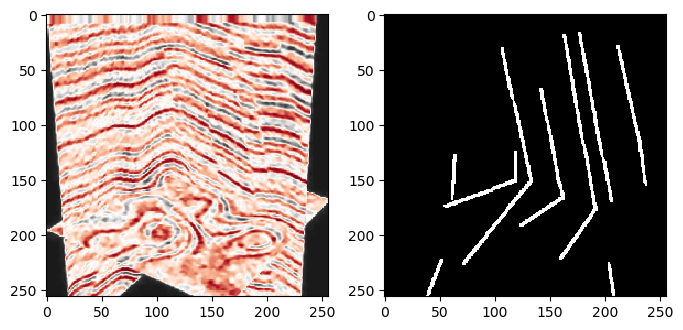

In [9]:
train_sample = random.randint(0, len(training_ids))
    
def TrainingSample_Plot():
    
    plt.style.use('default')
    fig = plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.imshow(Xtrain[train_sample,...,1], cmap ='RdGy')
    
    plt.subplot(1,2,2)
    plt.imshow(np.squeeze(ytrain[train_sample]) , cmap = 'gray')
    
TrainingSample_Plot()

## train, validate and save the model

In [12]:
results = model.fit(Xtrain, ytrain, validation_split=0.14, batch_size =16, epochs=150,callbacks=callbacks)
model.save('results/pre-trained model/FaultRecogCNN.h5')

Train on 577 samples, validate on 95 samples
Epoch 1/150
576/577 [============================>.] - ETA: 2:18 - loss: 0.2817 - accuracy: 0.8997 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 2:12 - loss: 0.2721 - accuracy: 0.9040 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 2:06 - loss: 0.2544 - accuracy: 0.9131 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 2:02 - loss: 0.2608 - accuracy: 0.9102 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 1:58 - loss: 0.2613 - accuracy: 0.9096 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 1:55 - loss: 0.2668 - accuracy: 0.9059 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 1:51 - loss: 0.2706 - accuracy: 0.9037 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 1:47 - loss: 0.2676 - accuracy: 0.9050 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 1:43 - loss: 0.2695 - accuracy: 0.9037 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 1:39 - loss: 0.2675 - accuracy: 0.9045 - precision: 0.0000e+00 - recall: 0.0000e+0 - 

576/577 [============================>.] - ETA: 2:13 - loss: 0.1848 - accuracy: 0.9211 - precision: 0.7775 - recall: 0.046 - ETA: 2:10 - loss: 0.2121 - accuracy: 0.9069 - precision: 0.7241 - recall: 0.036 - ETA: 2:06 - loss: 0.2245 - accuracy: 0.9039 - precision: 0.7229 - recall: 0.030 - ETA: 2:03 - loss: 0.2168 - accuracy: 0.9070 - precision: 0.7277 - recall: 0.032 - ETA: 1:59 - loss: 0.2072 - accuracy: 0.9110 - precision: 0.7326 - recall: 0.038 - ETA: 1:55 - loss: 0.2098 - accuracy: 0.9097 - precision: 0.7377 - recall: 0.038 - ETA: 1:51 - loss: 0.2059 - accuracy: 0.9112 - precision: 0.7360 - recall: 0.040 - ETA: 1:48 - loss: 0.2044 - accuracy: 0.9118 - precision: 0.7400 - recall: 0.041 - ETA: 1:45 - loss: 0.2043 - accuracy: 0.9117 - precision: 0.7415 - recall: 0.042 - ETA: 1:42 - loss: 0.2068 - accuracy: 0.9103 - precision: 0.7416 - recall: 0.043 - ETA: 1:38 - loss: 0.2090 - accuracy: 0.9090 - precision: 0.7480 - recall: 0.044 - ETA: 1:34 - loss: 0.2075 - accuracy: 0.9093 - precision

576/577 [============================>.] - ETA: 2:18 - loss: 0.1540 - accuracy: 0.9293 - precision: 0.7737 - recall: 0.261 - ETA: 2:13 - loss: 0.1391 - accuracy: 0.9368 - precision: 0.7630 - recall: 0.293 - ETA: 2:08 - loss: 0.1485 - accuracy: 0.9324 - precision: 0.7576 - recall: 0.277 - ETA: 2:04 - loss: 0.1407 - accuracy: 0.9360 - precision: 0.7499 - recall: 0.294 - ETA: 2:00 - loss: 0.1560 - accuracy: 0.9287 - precision: 0.7437 - recall: 0.249 - ETA: 1:57 - loss: 0.1607 - accuracy: 0.9266 - precision: 0.7416 - recall: 0.234 - ETA: 1:53 - loss: 0.1668 - accuracy: 0.9234 - precision: 0.7387 - recall: 0.224 - ETA: 1:48 - loss: 0.1660 - accuracy: 0.9237 - precision: 0.7418 - recall: 0.232 - ETA: 1:45 - loss: 0.1698 - accuracy: 0.9219 - precision: 0.7349 - recall: 0.224 - ETA: 1:41 - loss: 0.1712 - accuracy: 0.9213 - precision: 0.7334 - recall: 0.219 - ETA: 1:37 - loss: 0.1782 - accuracy: 0.9179 - precision: 0.7292 - recall: 0.205 - ETA: 1:33 - loss: 0.1792 - accuracy: 0.9176 - precision

576/577 [============================>.] - ETA: 2:15 - loss: 0.1678 - accuracy: 0.9197 - precision: 0.6652 - recall: 0.368 - ETA: 2:11 - loss: 0.1687 - accuracy: 0.9195 - precision: 0.6684 - recall: 0.332 - ETA: 2:08 - loss: 0.1821 - accuracy: 0.9132 - precision: 0.6835 - recall: 0.286 - ETA: 2:04 - loss: 0.1728 - accuracy: 0.9177 - precision: 0.7048 - recall: 0.297 - ETA: 2:00 - loss: 0.1672 - accuracy: 0.9204 - precision: 0.7080 - recall: 0.300 - ETA: 1:56 - loss: 0.1768 - accuracy: 0.9154 - precision: 0.7017 - recall: 0.284 - ETA: 1:52 - loss: 0.1668 - accuracy: 0.9204 - precision: 0.7108 - recall: 0.303 - ETA: 1:49 - loss: 0.1734 - accuracy: 0.9172 - precision: 0.7020 - recall: 0.293 - ETA: 1:45 - loss: 0.1683 - accuracy: 0.9197 - precision: 0.7075 - recall: 0.306 - ETA: 1:41 - loss: 0.1692 - accuracy: 0.9193 - precision: 0.7051 - recall: 0.302 - ETA: 1:37 - loss: 0.1653 - accuracy: 0.9211 - precision: 0.7101 - recall: 0.306 - ETA: 1:33 - loss: 0.1633 - accuracy: 0.9221 - precision

576/577 [============================>.] - ETA: 2:19 - loss: 0.1503 - accuracy: 0.9273 - precision: 0.6812 - recall: 0.418 - ETA: 2:13 - loss: 0.1754 - accuracy: 0.9138 - precision: 0.6572 - recall: 0.368 - ETA: 2:08 - loss: 0.1623 - accuracy: 0.9205 - precision: 0.6808 - recall: 0.388 - ETA: 2:04 - loss: 0.1543 - accuracy: 0.9246 - precision: 0.6893 - recall: 0.391 - ETA: 2:01 - loss: 0.1556 - accuracy: 0.9239 - precision: 0.6923 - recall: 0.380 - ETA: 1:57 - loss: 0.1533 - accuracy: 0.9250 - precision: 0.6968 - recall: 0.378 - ETA: 1:53 - loss: 0.1604 - accuracy: 0.9213 - precision: 0.6930 - recall: 0.367 - ETA: 1:49 - loss: 0.1613 - accuracy: 0.9208 - precision: 0.6957 - recall: 0.370 - ETA: 1:45 - loss: 0.1655 - accuracy: 0.9187 - precision: 0.6908 - recall: 0.366 - ETA: 1:41 - loss: 0.1571 - accuracy: 0.9229 - precision: 0.6940 - recall: 0.378 - ETA: 1:37 - loss: 0.1538 - accuracy: 0.9246 - precision: 0.6970 - recall: 0.385 - ETA: 1:33 - loss: 0.1531 - accuracy: 0.9250 - precision

576/577 [============================>.] - ETA: 2:14 - loss: 0.1333 - accuracy: 0.9346 - precision: 0.6832 - recall: 0.478 - ETA: 2:10 - loss: 0.1509 - accuracy: 0.9256 - precision: 0.6755 - recall: 0.454 - ETA: 2:07 - loss: 0.1459 - accuracy: 0.9281 - precision: 0.6872 - recall: 0.461 - ETA: 2:04 - loss: 0.1519 - accuracy: 0.9248 - precision: 0.6807 - recall: 0.446 - ETA: 2:00 - loss: 0.1532 - accuracy: 0.9241 - precision: 0.6803 - recall: 0.445 - ETA: 1:56 - loss: 0.1463 - accuracy: 0.9277 - precision: 0.6894 - recall: 0.458 - ETA: 1:52 - loss: 0.1471 - accuracy: 0.9273 - precision: 0.6923 - recall: 0.454 - ETA: 1:49 - loss: 0.1393 - accuracy: 0.9313 - precision: 0.6999 - recall: 0.463 - ETA: 1:45 - loss: 0.1410 - accuracy: 0.9305 - precision: 0.7008 - recall: 0.464 - ETA: 1:41 - loss: 0.1381 - accuracy: 0.9320 - precision: 0.7023 - recall: 0.469 - ETA: 1:37 - loss: 0.1347 - accuracy: 0.9338 - precision: 0.7071 - recall: 0.475 - ETA: 1:33 - loss: 0.1363 - accuracy: 0.9329 - precision

576/577 [============================>.] - ETA: 2:14 - loss: 0.0872 - accuracy: 0.9584 - precision: 0.7289 - recall: 0.623 - ETA: 2:13 - loss: 0.1229 - accuracy: 0.9398 - precision: 0.7068 - recall: 0.571 - ETA: 2:08 - loss: 0.1208 - accuracy: 0.9410 - precision: 0.7101 - recall: 0.566 - ETA: 2:04 - loss: 0.1210 - accuracy: 0.9408 - precision: 0.7115 - recall: 0.563 - ETA: 2:00 - loss: 0.1200 - accuracy: 0.9415 - precision: 0.7186 - recall: 0.566 - ETA: 1:56 - loss: 0.1179 - accuracy: 0.9425 - precision: 0.7222 - recall: 0.565 - ETA: 1:52 - loss: 0.1187 - accuracy: 0.9420 - precision: 0.7216 - recall: 0.567 - ETA: 1:48 - loss: 0.1186 - accuracy: 0.9421 - precision: 0.7219 - recall: 0.573 - ETA: 1:44 - loss: 0.1174 - accuracy: 0.9427 - precision: 0.7231 - recall: 0.575 - ETA: 1:41 - loss: 0.1167 - accuracy: 0.9430 - precision: 0.7253 - recall: 0.570 - ETA: 1:37 - loss: 0.1160 - accuracy: 0.9433 - precision: 0.7278 - recall: 0.565 - ETA: 1:33 - loss: 0.1164 - accuracy: 0.9431 - precision

576/577 [============================>.] - ETA: 2:14 - loss: 0.0802 - accuracy: 0.9620 - precision: 0.7512 - recall: 0.701 - ETA: 2:10 - loss: 0.0947 - accuracy: 0.9543 - precision: 0.7300 - recall: 0.653 - ETA: 2:07 - loss: 0.0977 - accuracy: 0.9528 - precision: 0.7321 - recall: 0.629 - ETA: 2:04 - loss: 0.1111 - accuracy: 0.9459 - precision: 0.7241 - recall: 0.601 - ETA: 2:00 - loss: 0.1166 - accuracy: 0.9432 - precision: 0.7150 - recall: 0.601 - ETA: 1:56 - loss: 0.1196 - accuracy: 0.9416 - precision: 0.7101 - recall: 0.598 - ETA: 1:52 - loss: 0.1175 - accuracy: 0.9426 - precision: 0.7132 - recall: 0.595 - ETA: 1:49 - loss: 0.1145 - accuracy: 0.9443 - precision: 0.7182 - recall: 0.596 - ETA: 1:45 - loss: 0.1137 - accuracy: 0.9447 - precision: 0.7196 - recall: 0.603 - ETA: 1:41 - loss: 0.1148 - accuracy: 0.9440 - precision: 0.7145 - recall: 0.609 - ETA: 1:37 - loss: 0.1134 - accuracy: 0.9447 - precision: 0.7154 - recall: 0.611 - ETA: 1:33 - loss: 0.1173 - accuracy: 0.9427 - precision

576/577 [============================>.] - ETA: 2:14 - loss: 0.1192 - accuracy: 0.9418 - precision: 0.7352 - recall: 0.647 - ETA: 2:12 - loss: 0.1282 - accuracy: 0.9375 - precision: 0.7234 - recall: 0.644 - ETA: 2:08 - loss: 0.1413 - accuracy: 0.9306 - precision: 0.7048 - recall: 0.636 - ETA: 2:04 - loss: 0.1263 - accuracy: 0.9383 - precision: 0.7139 - recall: 0.649 - ETA: 2:00 - loss: 0.1226 - accuracy: 0.9402 - precision: 0.7176 - recall: 0.648 - ETA: 1:56 - loss: 0.1186 - accuracy: 0.9423 - precision: 0.7192 - recall: 0.645 - ETA: 1:52 - loss: 0.1125 - accuracy: 0.9454 - precision: 0.7244 - recall: 0.649 - ETA: 1:48 - loss: 0.1063 - accuracy: 0.9486 - precision: 0.7304 - recall: 0.656 - ETA: 1:45 - loss: 0.1067 - accuracy: 0.9484 - precision: 0.7284 - recall: 0.657 - ETA: 1:41 - loss: 0.1073 - accuracy: 0.9481 - precision: 0.7264 - recall: 0.657 - ETA: 1:37 - loss: 0.1064 - accuracy: 0.9485 - precision: 0.7284 - recall: 0.657 - ETA: 1:33 - loss: 0.1060 - accuracy: 0.9487 - precision

576/577 [============================>.] - ETA: 2:14 - loss: 0.0801 - accuracy: 0.9618 - precision: 0.7567 - recall: 0.720 - ETA: 2:11 - loss: 0.1027 - accuracy: 0.9507 - precision: 0.7478 - recall: 0.687 - ETA: 2:07 - loss: 0.1044 - accuracy: 0.9499 - precision: 0.7483 - recall: 0.678 - ETA: 2:03 - loss: 0.1006 - accuracy: 0.9517 - precision: 0.7513 - recall: 0.682 - ETA: 2:00 - loss: 0.1022 - accuracy: 0.9510 - precision: 0.7473 - recall: 0.682 - ETA: 1:56 - loss: 0.1045 - accuracy: 0.9499 - precision: 0.7443 - recall: 0.681 - ETA: 1:52 - loss: 0.0984 - accuracy: 0.9530 - precision: 0.7473 - recall: 0.686 - ETA: 1:48 - loss: 0.1003 - accuracy: 0.9520 - precision: 0.7477 - recall: 0.687 - ETA: 1:45 - loss: 0.1031 - accuracy: 0.9506 - precision: 0.7439 - recall: 0.686 - ETA: 1:41 - loss: 0.1028 - accuracy: 0.9507 - precision: 0.7449 - recall: 0.688 - ETA: 1:37 - loss: 0.1046 - accuracy: 0.9498 - precision: 0.7434 - recall: 0.686 - ETA: 1:33 - loss: 0.1050 - accuracy: 0.9496 - precision

576/577 [============================>.] - ETA: 2:14 - loss: 0.1095 - accuracy: 0.9475 - precision: 0.7140 - recall: 0.724 - ETA: 2:10 - loss: 0.1112 - accuracy: 0.9467 - precision: 0.7192 - recall: 0.722 - ETA: 2:08 - loss: 0.1156 - accuracy: 0.9447 - precision: 0.7224 - recall: 0.707 - ETA: 2:04 - loss: 0.1142 - accuracy: 0.9453 - precision: 0.7339 - recall: 0.697 - ETA: 2:00 - loss: 0.1112 - accuracy: 0.9468 - precision: 0.7367 - recall: 0.695 - ETA: 1:56 - loss: 0.1124 - accuracy: 0.9462 - precision: 0.7349 - recall: 0.692 - ETA: 1:53 - loss: 0.1136 - accuracy: 0.9456 - precision: 0.7334 - recall: 0.692 - ETA: 1:50 - loss: 0.1123 - accuracy: 0.9463 - precision: 0.7343 - recall: 0.691 - ETA: 1:48 - loss: 0.1103 - accuracy: 0.9473 - precision: 0.7360 - recall: 0.692 - ETA: 1:44 - loss: 0.1111 - accuracy: 0.9469 - precision: 0.7360 - recall: 0.693 - ETA: 1:41 - loss: 0.1105 - accuracy: 0.9471 - precision: 0.7361 - recall: 0.693 - ETA: 1:37 - loss: 0.1115 - accuracy: 0.9467 - precision

576/577 [============================>.] - ETA: 2:15 - loss: 0.0942 - accuracy: 0.9555 - precision: 0.7821 - recall: 0.724 - ETA: 2:11 - loss: 0.0919 - accuracy: 0.9566 - precision: 0.7755 - recall: 0.732 - ETA: 2:07 - loss: 0.1093 - accuracy: 0.9482 - precision: 0.7533 - recall: 0.725 - ETA: 2:03 - loss: 0.1042 - accuracy: 0.9507 - precision: 0.7535 - recall: 0.728 - ETA: 2:00 - loss: 0.0997 - accuracy: 0.9529 - precision: 0.7608 - recall: 0.729 - ETA: 1:56 - loss: 0.1037 - accuracy: 0.9510 - precision: 0.7599 - recall: 0.721 - ETA: 1:52 - loss: 0.1026 - accuracy: 0.9515 - precision: 0.7623 - recall: 0.724 - ETA: 1:48 - loss: 0.1033 - accuracy: 0.9512 - precision: 0.7598 - recall: 0.728 - ETA: 1:45 - loss: 0.1026 - accuracy: 0.9515 - precision: 0.7586 - recall: 0.731 - ETA: 1:41 - loss: 0.1019 - accuracy: 0.9518 - precision: 0.7595 - recall: 0.731 - ETA: 1:37 - loss: 0.1019 - accuracy: 0.9518 - precision: 0.7593 - recall: 0.728 - ETA: 1:33 - loss: 0.1028 - accuracy: 0.9513 - precision

576/577 [============================>.] - ETA: 2:14 - loss: 0.1040 - accuracy: 0.9509 - precision: 0.7503 - recall: 0.767 - ETA: 2:10 - loss: 0.1004 - accuracy: 0.9527 - precision: 0.7529 - recall: 0.765 - ETA: 2:08 - loss: 0.1070 - accuracy: 0.9494 - precision: 0.7548 - recall: 0.747 - ETA: 2:04 - loss: 0.0997 - accuracy: 0.9530 - precision: 0.7615 - recall: 0.748 - ETA: 2:01 - loss: 0.0991 - accuracy: 0.9533 - precision: 0.7634 - recall: 0.746 - ETA: 1:57 - loss: 0.0932 - accuracy: 0.9562 - precision: 0.7687 - recall: 0.752 - ETA: 1:54 - loss: 0.0975 - accuracy: 0.9542 - precision: 0.7666 - recall: 0.749 - ETA: 1:49 - loss: 0.0967 - accuracy: 0.9545 - precision: 0.7681 - recall: 0.749 - ETA: 1:45 - loss: 0.1002 - accuracy: 0.9528 - precision: 0.7657 - recall: 0.744 - ETA: 1:41 - loss: 0.1013 - accuracy: 0.9522 - precision: 0.7654 - recall: 0.744 - ETA: 1:37 - loss: 0.0988 - accuracy: 0.9535 - precision: 0.7676 - recall: 0.747 - ETA: 1:33 - loss: 0.0998 - accuracy: 0.9531 - precision

576/577 [============================>.] - ETA: 2:19 - loss: 0.0960 - accuracy: 0.9552 - precision: 0.7626 - recall: 0.775 - ETA: 2:13 - loss: 0.0970 - accuracy: 0.9549 - precision: 0.7598 - recall: 0.761 - ETA: 2:08 - loss: 0.1025 - accuracy: 0.9522 - precision: 0.7610 - recall: 0.749 - ETA: 2:04 - loss: 0.1127 - accuracy: 0.9473 - precision: 0.7598 - recall: 0.736 - ETA: 2:01 - loss: 0.1037 - accuracy: 0.9516 - precision: 0.7658 - recall: 0.745 - ETA: 1:57 - loss: 0.0979 - accuracy: 0.9544 - precision: 0.7712 - recall: 0.752 - ETA: 1:53 - loss: 0.1001 - accuracy: 0.9532 - precision: 0.7678 - recall: 0.750 - ETA: 1:49 - loss: 0.1007 - accuracy: 0.9530 - precision: 0.7695 - recall: 0.747 - ETA: 1:45 - loss: 0.0972 - accuracy: 0.9547 - precision: 0.7702 - recall: 0.746 - ETA: 1:41 - loss: 0.0937 - accuracy: 0.9564 - precision: 0.7718 - recall: 0.748 - ETA: 1:37 - loss: 0.0922 - accuracy: 0.9571 - precision: 0.7720 - recall: 0.751 - ETA: 1:33 - loss: 0.0928 - accuracy: 0.9568 - precision

576/577 [============================>.] - ETA: 2:14 - loss: 0.1258 - accuracy: 0.9415 - precision: 0.7657 - recall: 0.758 - ETA: 2:11 - loss: 0.1075 - accuracy: 0.9500 - precision: 0.7736 - recall: 0.759 - ETA: 2:08 - loss: 0.0974 - accuracy: 0.9549 - precision: 0.7807 - recall: 0.767 - ETA: 2:04 - loss: 0.0944 - accuracy: 0.9562 - precision: 0.7791 - recall: 0.766 - ETA: 2:00 - loss: 0.0882 - accuracy: 0.9592 - precision: 0.7839 - recall: 0.772 - ETA: 1:56 - loss: 0.0877 - accuracy: 0.9595 - precision: 0.7863 - recall: 0.774 - ETA: 1:52 - loss: 0.0893 - accuracy: 0.9587 - precision: 0.7859 - recall: 0.771 - ETA: 1:48 - loss: 0.0855 - accuracy: 0.9605 - precision: 0.7890 - recall: 0.772 - ETA: 1:44 - loss: 0.0886 - accuracy: 0.9590 - precision: 0.7867 - recall: 0.770 - ETA: 1:40 - loss: 0.0902 - accuracy: 0.9583 - precision: 0.7852 - recall: 0.770 - ETA: 1:37 - loss: 0.0901 - accuracy: 0.9583 - precision: 0.7846 - recall: 0.769 - ETA: 1:33 - loss: 0.0911 - accuracy: 0.9578 - precision

576/577 [============================>.] - ETA: 2:17 - loss: 0.1186 - accuracy: 0.9452 - precision: 0.7819 - recall: 0.743 - ETA: 2:13 - loss: 0.1005 - accuracy: 0.9538 - precision: 0.7863 - recall: 0.752 - ETA: 2:08 - loss: 0.0888 - accuracy: 0.9592 - precision: 0.7915 - recall: 0.768 - ETA: 2:04 - loss: 0.0917 - accuracy: 0.9577 - precision: 0.7856 - recall: 0.769 - ETA: 2:00 - loss: 0.0921 - accuracy: 0.9575 - precision: 0.7808 - recall: 0.770 - ETA: 1:57 - loss: 0.0871 - accuracy: 0.9598 - precision: 0.7845 - recall: 0.774 - ETA: 1:52 - loss: 0.0846 - accuracy: 0.9610 - precision: 0.7874 - recall: 0.773 - ETA: 1:48 - loss: 0.0896 - accuracy: 0.9587 - precision: 0.7853 - recall: 0.768 - ETA: 1:45 - loss: 0.0886 - accuracy: 0.9591 - precision: 0.7863 - recall: 0.768 - ETA: 1:41 - loss: 0.0862 - accuracy: 0.9603 - precision: 0.7890 - recall: 0.771 - ETA: 1:37 - loss: 0.0884 - accuracy: 0.9592 - precision: 0.7867 - recall: 0.772 - ETA: 1:33 - loss: 0.0875 - accuracy: 0.9596 - precision

576/577 [============================>.] - ETA: 2:14 - loss: 0.0729 - accuracy: 0.9666 - precision: 0.8084 - recall: 0.796 - ETA: 2:11 - loss: 0.0754 - accuracy: 0.9657 - precision: 0.8047 - recall: 0.798 - ETA: 2:08 - loss: 0.0788 - accuracy: 0.9640 - precision: 0.7996 - recall: 0.794 - ETA: 2:04 - loss: 0.0762 - accuracy: 0.9652 - precision: 0.8015 - recall: 0.791 - ETA: 2:00 - loss: 0.0740 - accuracy: 0.9663 - precision: 0.8040 - recall: 0.788 - ETA: 1:56 - loss: 0.0765 - accuracy: 0.9651 - precision: 0.8037 - recall: 0.785 - ETA: 1:52 - loss: 0.0771 - accuracy: 0.9647 - precision: 0.8017 - recall: 0.787 - ETA: 1:49 - loss: 0.0819 - accuracy: 0.9624 - precision: 0.7955 - recall: 0.786 - ETA: 1:45 - loss: 0.0834 - accuracy: 0.9617 - precision: 0.7937 - recall: 0.783 - ETA: 1:41 - loss: 0.0827 - accuracy: 0.9620 - precision: 0.7950 - recall: 0.783 - ETA: 1:37 - loss: 0.0809 - accuracy: 0.9629 - precision: 0.7980 - recall: 0.785 - ETA: 1:33 - loss: 0.0826 - accuracy: 0.9621 - precision

576/577 [============================>.] - ETA: 2:14 - loss: 0.1085 - accuracy: 0.9499 - precision: 0.7972 - recall: 0.758 - ETA: 2:13 - loss: 0.0959 - accuracy: 0.9560 - precision: 0.7973 - recall: 0.769 - ETA: 2:08 - loss: 0.0957 - accuracy: 0.9561 - precision: 0.7916 - recall: 0.775 - ETA: 2:04 - loss: 0.0951 - accuracy: 0.9564 - precision: 0.7949 - recall: 0.779 - ETA: 2:00 - loss: 0.0898 - accuracy: 0.9589 - precision: 0.7978 - recall: 0.783 - ETA: 1:56 - loss: 0.0923 - accuracy: 0.9576 - precision: 0.7934 - recall: 0.781 - ETA: 1:52 - loss: 0.0899 - accuracy: 0.9588 - precision: 0.7934 - recall: 0.784 - ETA: 1:48 - loss: 0.0859 - accuracy: 0.9606 - precision: 0.7944 - recall: 0.785 - ETA: 1:44 - loss: 0.0836 - accuracy: 0.9617 - precision: 0.7986 - recall: 0.785 - ETA: 1:41 - loss: 0.0834 - accuracy: 0.9619 - precision: 0.7998 - recall: 0.782 - ETA: 1:37 - loss: 0.0825 - accuracy: 0.9623 - precision: 0.8009 - recall: 0.783 - ETA: 1:33 - loss: 0.0832 - accuracy: 0.9619 - precision

576/577 [============================>.] - ETA: 2:14 - loss: 0.0630 - accuracy: 0.9713 - precision: 0.8190 - recall: 0.791 - ETA: 2:10 - loss: 0.0762 - accuracy: 0.9653 - precision: 0.8142 - recall: 0.786 - ETA: 2:07 - loss: 0.0814 - accuracy: 0.9628 - precision: 0.8034 - recall: 0.783 - ETA: 2:04 - loss: 0.0834 - accuracy: 0.9620 - precision: 0.8009 - recall: 0.787 - ETA: 2:00 - loss: 0.0826 - accuracy: 0.9623 - precision: 0.8007 - recall: 0.792 - ETA: 1:56 - loss: 0.0836 - accuracy: 0.9618 - precision: 0.7977 - recall: 0.792 - ETA: 1:52 - loss: 0.0867 - accuracy: 0.9603 - precision: 0.7948 - recall: 0.791 - ETA: 1:48 - loss: 0.0837 - accuracy: 0.9617 - precision: 0.7977 - recall: 0.792 - ETA: 1:45 - loss: 0.0802 - accuracy: 0.9633 - precision: 0.8006 - recall: 0.793 - ETA: 1:41 - loss: 0.0802 - accuracy: 0.9633 - precision: 0.8026 - recall: 0.791 - ETA: 1:37 - loss: 0.0811 - accuracy: 0.9629 - precision: 0.8026 - recall: 0.789 - ETA: 1:33 - loss: 0.0809 - accuracy: 0.9630 - precision

576/577 [============================>.] - ETA: 2:17 - loss: 0.1067 - accuracy: 0.9515 - precision: 0.7957 - recall: 0.815 - ETA: 2:12 - loss: 0.0945 - accuracy: 0.9572 - precision: 0.7981 - recall: 0.807 - ETA: 2:09 - loss: 0.0947 - accuracy: 0.9571 - precision: 0.8023 - recall: 0.800 - ETA: 2:05 - loss: 0.0881 - accuracy: 0.9601 - precision: 0.8075 - recall: 0.801 - ETA: 2:01 - loss: 0.0818 - accuracy: 0.9630 - precision: 0.8068 - recall: 0.803 - ETA: 1:57 - loss: 0.0773 - accuracy: 0.9651 - precision: 0.8097 - recall: 0.808 - ETA: 1:53 - loss: 0.0753 - accuracy: 0.9660 - precision: 0.8108 - recall: 0.809 - ETA: 1:49 - loss: 0.0796 - accuracy: 0.9640 - precision: 0.8079 - recall: 0.802 - ETA: 1:45 - loss: 0.0807 - accuracy: 0.9634 - precision: 0.8067 - recall: 0.803 - ETA: 1:41 - loss: 0.0777 - accuracy: 0.9648 - precision: 0.8073 - recall: 0.805 - ETA: 1:37 - loss: 0.0772 - accuracy: 0.9651 - precision: 0.8072 - recall: 0.805 - ETA: 1:33 - loss: 0.0809 - accuracy: 0.9633 - precision

576/577 [============================>.] - ETA: 2:18 - loss: 0.0620 - accuracy: 0.9720 - precision: 0.8256 - recall: 0.809 - ETA: 2:12 - loss: 0.0767 - accuracy: 0.9652 - precision: 0.8097 - recall: 0.798 - ETA: 2:08 - loss: 0.0793 - accuracy: 0.9640 - precision: 0.8099 - recall: 0.803 - ETA: 2:04 - loss: 0.0811 - accuracy: 0.9633 - precision: 0.8078 - recall: 0.799 - ETA: 2:00 - loss: 0.0735 - accuracy: 0.9667 - precision: 0.8126 - recall: 0.805 - ETA: 1:56 - loss: 0.0777 - accuracy: 0.9648 - precision: 0.8077 - recall: 0.805 - ETA: 1:52 - loss: 0.0772 - accuracy: 0.9650 - precision: 0.8061 - recall: 0.804 - ETA: 1:49 - loss: 0.0755 - accuracy: 0.9658 - precision: 0.8080 - recall: 0.803 - ETA: 1:45 - loss: 0.0778 - accuracy: 0.9647 - precision: 0.8079 - recall: 0.800 - ETA: 1:41 - loss: 0.0808 - accuracy: 0.9634 - precision: 0.8062 - recall: 0.799 - ETA: 1:37 - loss: 0.0812 - accuracy: 0.9632 - precision: 0.8050 - recall: 0.800 - ETA: 1:33 - loss: 0.0800 - accuracy: 0.9637 - precision

576/577 [============================>.] - ETA: 2:14 - loss: 0.0600 - accuracy: 0.9731 - precision: 0.8224 - recall: 0.834 - ETA: 2:11 - loss: 0.0809 - accuracy: 0.9634 - precision: 0.8031 - recall: 0.811 - ETA: 2:08 - loss: 0.0800 - accuracy: 0.9637 - precision: 0.7997 - recall: 0.809 - ETA: 2:04 - loss: 0.0811 - accuracy: 0.9632 - precision: 0.8036 - recall: 0.805 - ETA: 2:00 - loss: 0.0836 - accuracy: 0.9621 - precision: 0.8070 - recall: 0.795 - ETA: 1:56 - loss: 0.0820 - accuracy: 0.9628 - precision: 0.8093 - recall: 0.793 - ETA: 1:52 - loss: 0.0825 - accuracy: 0.9625 - precision: 0.8065 - recall: 0.794 - ETA: 1:49 - loss: 0.0794 - accuracy: 0.9640 - precision: 0.8061 - recall: 0.798 - ETA: 1:45 - loss: 0.0826 - accuracy: 0.9626 - precision: 0.8010 - recall: 0.802 - ETA: 1:41 - loss: 0.0838 - accuracy: 0.9620 - precision: 0.8022 - recall: 0.800 - ETA: 1:37 - loss: 0.0840 - accuracy: 0.9620 - precision: 0.8047 - recall: 0.796 - ETA: 1:33 - loss: 0.0836 - accuracy: 0.9621 - precision

576/577 [============================>.] - ETA: 2:17 - loss: 0.0547 - accuracy: 0.9755 - precision: 0.8251 - recall: 0.830 - ETA: 2:13 - loss: 0.0682 - accuracy: 0.9693 - precision: 0.8153 - recall: 0.832 - ETA: 2:08 - loss: 0.0680 - accuracy: 0.9694 - precision: 0.8184 - recall: 0.828 - ETA: 2:04 - loss: 0.0722 - accuracy: 0.9674 - precision: 0.8171 - recall: 0.819 - ETA: 2:00 - loss: 0.0743 - accuracy: 0.9665 - precision: 0.8149 - recall: 0.815 - ETA: 1:56 - loss: 0.0759 - accuracy: 0.9657 - precision: 0.8127 - recall: 0.814 - ETA: 1:52 - loss: 0.0796 - accuracy: 0.9640 - precision: 0.8107 - recall: 0.809 - ETA: 1:48 - loss: 0.0817 - accuracy: 0.9631 - precision: 0.8113 - recall: 0.805 - ETA: 1:44 - loss: 0.0800 - accuracy: 0.9639 - precision: 0.8137 - recall: 0.805 - ETA: 1:41 - loss: 0.0814 - accuracy: 0.9633 - precision: 0.8127 - recall: 0.805 - ETA: 1:37 - loss: 0.0820 - accuracy: 0.9630 - precision: 0.8108 - recall: 0.805 - ETA: 1:33 - loss: 0.0801 - accuracy: 0.9638 - precision

576/577 [============================>.] - ETA: 2:15 - loss: 0.0435 - accuracy: 0.9806 - precision: 0.8377 - recall: 0.850 - ETA: 2:11 - loss: 0.0574 - accuracy: 0.9743 - precision: 0.8243 - recall: 0.819 - ETA: 2:07 - loss: 0.0667 - accuracy: 0.9699 - precision: 0.8217 - recall: 0.803 - ETA: 2:04 - loss: 0.0690 - accuracy: 0.9689 - precision: 0.8230 - recall: 0.801 - ETA: 2:00 - loss: 0.0775 - accuracy: 0.9650 - precision: 0.8146 - recall: 0.801 - ETA: 1:56 - loss: 0.0777 - accuracy: 0.9650 - precision: 0.8111 - recall: 0.804 - ETA: 1:52 - loss: 0.0782 - accuracy: 0.9647 - precision: 0.8099 - recall: 0.805 - ETA: 1:49 - loss: 0.0761 - accuracy: 0.9657 - precision: 0.8128 - recall: 0.805 - ETA: 1:45 - loss: 0.0763 - accuracy: 0.9656 - precision: 0.8144 - recall: 0.805 - ETA: 1:41 - loss: 0.0754 - accuracy: 0.9660 - precision: 0.8148 - recall: 0.807 - ETA: 1:37 - loss: 0.0770 - accuracy: 0.9652 - precision: 0.8128 - recall: 0.809 - ETA: 1:33 - loss: 0.0769 - accuracy: 0.9653 - precision

576/577 [============================>.] - ETA: 2:15 - loss: 0.0499 - accuracy: 0.9778 - precision: 0.8399 - recall: 0.850 - ETA: 2:13 - loss: 0.0656 - accuracy: 0.9706 - precision: 0.8284 - recall: 0.830 - ETA: 2:08 - loss: 0.0675 - accuracy: 0.9698 - precision: 0.8249 - recall: 0.822 - ETA: 2:04 - loss: 0.0730 - accuracy: 0.9672 - precision: 0.8189 - recall: 0.814 - ETA: 2:00 - loss: 0.0680 - accuracy: 0.9695 - precision: 0.8239 - recall: 0.818 - ETA: 1:56 - loss: 0.0700 - accuracy: 0.9685 - precision: 0.8211 - recall: 0.818 - ETA: 1:52 - loss: 0.0722 - accuracy: 0.9676 - precision: 0.8192 - recall: 0.817 - ETA: 1:48 - loss: 0.0733 - accuracy: 0.9671 - precision: 0.8190 - recall: 0.816 - ETA: 1:44 - loss: 0.0728 - accuracy: 0.9673 - precision: 0.8195 - recall: 0.817 - ETA: 1:41 - loss: 0.0740 - accuracy: 0.9668 - precision: 0.8182 - recall: 0.816 - ETA: 1:37 - loss: 0.0720 - accuracy: 0.9677 - precision: 0.8197 - recall: 0.816 - ETA: 1:33 - loss: 0.0715 - accuracy: 0.9679 - precision

576/577 [============================>.] - ETA: 2:14 - loss: 0.0578 - accuracy: 0.9742 - precision: 0.8382 - recall: 0.829 - ETA: 2:10 - loss: 0.0690 - accuracy: 0.9691 - precision: 0.8232 - recall: 0.827 - ETA: 2:06 - loss: 0.0758 - accuracy: 0.9660 - precision: 0.8155 - recall: 0.829 - ETA: 2:04 - loss: 0.0729 - accuracy: 0.9672 - precision: 0.8147 - recall: 0.828 - ETA: 2:00 - loss: 0.0712 - accuracy: 0.9680 - precision: 0.8182 - recall: 0.823 - ETA: 1:56 - loss: 0.0756 - accuracy: 0.9660 - precision: 0.8203 - recall: 0.815 - ETA: 1:52 - loss: 0.0774 - accuracy: 0.9652 - precision: 0.8204 - recall: 0.813 - ETA: 1:48 - loss: 0.0780 - accuracy: 0.9649 - precision: 0.8192 - recall: 0.816 - ETA: 1:44 - loss: 0.0760 - accuracy: 0.9659 - precision: 0.8182 - recall: 0.818 - ETA: 1:40 - loss: 0.0766 - accuracy: 0.9656 - precision: 0.8160 - recall: 0.821 - ETA: 1:36 - loss: 0.0782 - accuracy: 0.9649 - precision: 0.8170 - recall: 0.820 - ETA: 1:33 - loss: 0.0776 - accuracy: 0.9652 - precision

576/577 [============================>.] - ETA: 2:14 - loss: 0.0494 - accuracy: 0.9780 - precision: 0.8361 - recall: 0.841 - ETA: 2:13 - loss: 0.0683 - accuracy: 0.9695 - precision: 0.8216 - recall: 0.832 - ETA: 2:09 - loss: 0.0719 - accuracy: 0.9678 - precision: 0.8232 - recall: 0.826 - ETA: 2:05 - loss: 0.0723 - accuracy: 0.9676 - precision: 0.8252 - recall: 0.823 - ETA: 2:00 - loss: 0.0743 - accuracy: 0.9668 - precision: 0.8268 - recall: 0.821 - ETA: 1:57 - loss: 0.0748 - accuracy: 0.9666 - precision: 0.8267 - recall: 0.821 - ETA: 1:53 - loss: 0.0743 - accuracy: 0.9668 - precision: 0.8258 - recall: 0.822 - ETA: 1:49 - loss: 0.0733 - accuracy: 0.9672 - precision: 0.8252 - recall: 0.824 - ETA: 1:45 - loss: 0.0712 - accuracy: 0.9682 - precision: 0.8263 - recall: 0.827 - ETA: 1:41 - loss: 0.0721 - accuracy: 0.9678 - precision: 0.8259 - recall: 0.825 - ETA: 1:37 - loss: 0.0709 - accuracy: 0.9683 - precision: 0.8268 - recall: 0.824 - ETA: 1:33 - loss: 0.0720 - accuracy: 0.9678 - precision

576/577 [============================>.] - ETA: 2:15 - loss: 0.0623 - accuracy: 0.9723 - precision: 0.8335 - recall: 0.821 - ETA: 2:11 - loss: 0.0683 - accuracy: 0.9695 - precision: 0.8296 - recall: 0.820 - ETA: 2:07 - loss: 0.0725 - accuracy: 0.9676 - precision: 0.8236 - recall: 0.821 - ETA: 2:03 - loss: 0.0703 - accuracy: 0.9686 - precision: 0.8252 - recall: 0.823 - ETA: 2:00 - loss: 0.0691 - accuracy: 0.9691 - precision: 0.8255 - recall: 0.824 - ETA: 1:56 - loss: 0.0684 - accuracy: 0.9694 - precision: 0.8264 - recall: 0.826 - ETA: 1:52 - loss: 0.0711 - accuracy: 0.9683 - precision: 0.8260 - recall: 0.825 - ETA: 1:49 - loss: 0.0713 - accuracy: 0.9682 - precision: 0.8275 - recall: 0.826 - ETA: 1:45 - loss: 0.0710 - accuracy: 0.9683 - precision: 0.8272 - recall: 0.825 - ETA: 1:41 - loss: 0.0699 - accuracy: 0.9688 - precision: 0.8278 - recall: 0.824 - ETA: 1:37 - loss: 0.0720 - accuracy: 0.9678 - precision: 0.8260 - recall: 0.823 - ETA: 1:33 - loss: 0.0733 - accuracy: 0.9672 - precision

576/577 [============================>.] - ETA: 2:14 - loss: 0.0703 - accuracy: 0.9689 - precision: 0.8311 - recall: 0.830 - ETA: 2:10 - loss: 0.0808 - accuracy: 0.9641 - precision: 0.8179 - recall: 0.827 - ETA: 2:08 - loss: 0.0817 - accuracy: 0.9637 - precision: 0.8161 - recall: 0.827 - ETA: 2:04 - loss: 0.0807 - accuracy: 0.9641 - precision: 0.8187 - recall: 0.824 - ETA: 2:00 - loss: 0.0781 - accuracy: 0.9651 - precision: 0.8223 - recall: 0.819 - ETA: 1:56 - loss: 0.0786 - accuracy: 0.9649 - precision: 0.8221 - recall: 0.816 - ETA: 1:52 - loss: 0.0768 - accuracy: 0.9657 - precision: 0.8227 - recall: 0.818 - ETA: 1:48 - loss: 0.0749 - accuracy: 0.9666 - precision: 0.8238 - recall: 0.821 - ETA: 1:44 - loss: 0.0755 - accuracy: 0.9663 - precision: 0.8226 - recall: 0.823 - ETA: 1:40 - loss: 0.0754 - accuracy: 0.9663 - precision: 0.8224 - recall: 0.823 - ETA: 1:37 - loss: 0.0742 - accuracy: 0.9668 - precision: 0.8239 - recall: 0.823 - ETA: 1:33 - loss: 0.0722 - accuracy: 0.9677 - precision

576/577 [============================>.] - ETA: 2:18 - loss: 0.0618 - accuracy: 0.9726 - precision: 0.8482 - recall: 0.831 - ETA: 2:13 - loss: 0.0587 - accuracy: 0.9739 - precision: 0.8446 - recall: 0.835 - ETA: 2:08 - loss: 0.0673 - accuracy: 0.9699 - precision: 0.8326 - recall: 0.836 - ETA: 2:04 - loss: 0.0700 - accuracy: 0.9687 - precision: 0.8313 - recall: 0.833 - ETA: 2:01 - loss: 0.0686 - accuracy: 0.9694 - precision: 0.8340 - recall: 0.833 - ETA: 1:57 - loss: 0.0650 - accuracy: 0.9710 - precision: 0.8356 - recall: 0.832 - ETA: 1:52 - loss: 0.0657 - accuracy: 0.9707 - precision: 0.8349 - recall: 0.830 - ETA: 1:48 - loss: 0.0669 - accuracy: 0.9701 - precision: 0.8337 - recall: 0.830 - ETA: 1:45 - loss: 0.0669 - accuracy: 0.9701 - precision: 0.8334 - recall: 0.831 - ETA: 1:41 - loss: 0.0703 - accuracy: 0.9687 - precision: 0.8322 - recall: 0.830 - ETA: 1:37 - loss: 0.0697 - accuracy: 0.9689 - precision: 0.8333 - recall: 0.831 - ETA: 1:33 - loss: 0.0704 - accuracy: 0.9686 - precision

576/577 [============================>.] - ETA: 2:14 - loss: 0.0591 - accuracy: 0.9737 - precision: 0.8499 - recall: 0.829 - ETA: 2:11 - loss: 0.0722 - accuracy: 0.9677 - precision: 0.8360 - recall: 0.824 - ETA: 2:07 - loss: 0.0764 - accuracy: 0.9657 - precision: 0.8284 - recall: 0.828 - ETA: 2:04 - loss: 0.0742 - accuracy: 0.9667 - precision: 0.8299 - recall: 0.831 - ETA: 2:00 - loss: 0.0749 - accuracy: 0.9664 - precision: 0.8296 - recall: 0.829 - ETA: 1:56 - loss: 0.0733 - accuracy: 0.9671 - precision: 0.8301 - recall: 0.826 - ETA: 1:52 - loss: 0.0744 - accuracy: 0.9667 - precision: 0.8295 - recall: 0.825 - ETA: 1:48 - loss: 0.0731 - accuracy: 0.9672 - precision: 0.8289 - recall: 0.825 - ETA: 1:44 - loss: 0.0710 - accuracy: 0.9682 - precision: 0.8294 - recall: 0.826 - ETA: 1:40 - loss: 0.0721 - accuracy: 0.9677 - precision: 0.8281 - recall: 0.825 - ETA: 1:36 - loss: 0.0697 - accuracy: 0.9688 - precision: 0.8291 - recall: 0.826 - ETA: 1:33 - loss: 0.0696 - accuracy: 0.9688 - precision

576/577 [============================>.] - ETA: 2:14 - loss: 0.0778 - accuracy: 0.9650 - precision: 0.8131 - recall: 0.846 - ETA: 2:13 - loss: 0.0687 - accuracy: 0.9693 - precision: 0.8210 - recall: 0.846 - ETA: 2:08 - loss: 0.0736 - accuracy: 0.9671 - precision: 0.8247 - recall: 0.836 - ETA: 2:04 - loss: 0.0690 - accuracy: 0.9692 - precision: 0.8315 - recall: 0.833 - ETA: 2:00 - loss: 0.0670 - accuracy: 0.9701 - precision: 0.8328 - recall: 0.832 - ETA: 1:56 - loss: 0.0675 - accuracy: 0.9699 - precision: 0.8320 - recall: 0.833 - ETA: 1:52 - loss: 0.0675 - accuracy: 0.9699 - precision: 0.8314 - recall: 0.835 - ETA: 1:48 - loss: 0.0658 - accuracy: 0.9706 - precision: 0.8326 - recall: 0.836 - ETA: 1:44 - loss: 0.0667 - accuracy: 0.9702 - precision: 0.8326 - recall: 0.833 - ETA: 1:41 - loss: 0.0677 - accuracy: 0.9698 - precision: 0.8331 - recall: 0.831 - ETA: 1:37 - loss: 0.0693 - accuracy: 0.9691 - precision: 0.8329 - recall: 0.831 - ETA: 1:33 - loss: 0.0688 - accuracy: 0.9693 - precision

576/577 [============================>.] - ETA: 2:16 - loss: 0.0627 - accuracy: 0.9722 - precision: 0.8521 - recall: 0.823 - ETA: 2:11 - loss: 0.0715 - accuracy: 0.9681 - precision: 0.8386 - recall: 0.816 - ETA: 2:07 - loss: 0.0805 - accuracy: 0.9641 - precision: 0.8297 - recall: 0.821 - ETA: 2:03 - loss: 0.0798 - accuracy: 0.9644 - precision: 0.8239 - recall: 0.827 - ETA: 2:00 - loss: 0.0801 - accuracy: 0.9642 - precision: 0.8216 - recall: 0.829 - ETA: 1:56 - loss: 0.0781 - accuracy: 0.9652 - precision: 0.8250 - recall: 0.828 - ETA: 1:52 - loss: 0.0797 - accuracy: 0.9644 - precision: 0.8267 - recall: 0.824 - ETA: 1:48 - loss: 0.0774 - accuracy: 0.9655 - precision: 0.8293 - recall: 0.824 - ETA: 1:45 - loss: 0.0749 - accuracy: 0.9666 - precision: 0.8312 - recall: 0.826 - ETA: 1:41 - loss: 0.0742 - accuracy: 0.9669 - precision: 0.8317 - recall: 0.828 - ETA: 1:37 - loss: 0.0731 - accuracy: 0.9674 - precision: 0.8318 - recall: 0.830 - ETA: 1:33 - loss: 0.0731 - accuracy: 0.9674 - precision

576/577 [============================>.] - ETA: 2:15 - loss: 0.0657 - accuracy: 0.9712 - precision: 0.8542 - recall: 0.833 - ETA: 2:11 - loss: 0.0645 - accuracy: 0.9715 - precision: 0.8454 - recall: 0.830 - ETA: 2:08 - loss: 0.0675 - accuracy: 0.9701 - precision: 0.8394 - recall: 0.836 - ETA: 2:04 - loss: 0.0647 - accuracy: 0.9714 - precision: 0.8394 - recall: 0.838 - ETA: 2:00 - loss: 0.0634 - accuracy: 0.9719 - precision: 0.8420 - recall: 0.840 - ETA: 1:56 - loss: 0.0646 - accuracy: 0.9714 - precision: 0.8413 - recall: 0.837 - ETA: 1:52 - loss: 0.0629 - accuracy: 0.9721 - precision: 0.8427 - recall: 0.837 - ETA: 1:49 - loss: 0.0645 - accuracy: 0.9714 - precision: 0.8407 - recall: 0.836 - ETA: 1:45 - loss: 0.0641 - accuracy: 0.9716 - precision: 0.8402 - recall: 0.838 - ETA: 1:41 - loss: 0.0670 - accuracy: 0.9703 - precision: 0.8378 - recall: 0.836 - ETA: 1:37 - loss: 0.0659 - accuracy: 0.9708 - precision: 0.8391 - recall: 0.835 - ETA: 1:33 - loss: 0.0647 - accuracy: 0.9713 - precision

576/577 [============================>.] - ETA: 2:17 - loss: 0.0485 - accuracy: 0.9786 - precision: 0.8578 - recall: 0.830 - ETA: 2:13 - loss: 0.0638 - accuracy: 0.9718 - precision: 0.8496 - recall: 0.823 - ETA: 2:08 - loss: 0.0699 - accuracy: 0.9690 - precision: 0.8370 - recall: 0.824 - ETA: 2:04 - loss: 0.0696 - accuracy: 0.9691 - precision: 0.8327 - recall: 0.828 - ETA: 2:00 - loss: 0.0736 - accuracy: 0.9673 - precision: 0.8304 - recall: 0.830 - ETA: 1:57 - loss: 0.0732 - accuracy: 0.9675 - precision: 0.8325 - recall: 0.830 - ETA: 1:52 - loss: 0.0719 - accuracy: 0.9681 - precision: 0.8331 - recall: 0.829 - ETA: 1:48 - loss: 0.0721 - accuracy: 0.9680 - precision: 0.8333 - recall: 0.828 - ETA: 1:45 - loss: 0.0718 - accuracy: 0.9681 - precision: 0.8334 - recall: 0.830 - ETA: 1:41 - loss: 0.0725 - accuracy: 0.9678 - precision: 0.8318 - recall: 0.831 - ETA: 1:37 - loss: 0.0720 - accuracy: 0.9680 - precision: 0.8327 - recall: 0.831 - ETA: 1:33 - loss: 0.0727 - accuracy: 0.9677 - precision

576/577 [============================>.] - ETA: 2:15 - loss: 0.0816 - accuracy: 0.9638 - precision: 0.8228 - recall: 0.841 - ETA: 2:11 - loss: 0.0710 - accuracy: 0.9686 - precision: 0.8336 - recall: 0.848 - ETA: 2:07 - loss: 0.0649 - accuracy: 0.9713 - precision: 0.8381 - recall: 0.845 - ETA: 2:04 - loss: 0.0647 - accuracy: 0.9713 - precision: 0.8394 - recall: 0.840 - ETA: 2:00 - loss: 0.0669 - accuracy: 0.9703 - precision: 0.8357 - recall: 0.838 - ETA: 1:56 - loss: 0.0646 - accuracy: 0.9713 - precision: 0.8383 - recall: 0.843 - ETA: 1:52 - loss: 0.0687 - accuracy: 0.9695 - precision: 0.8361 - recall: 0.841 - ETA: 1:48 - loss: 0.0693 - accuracy: 0.9692 - precision: 0.8372 - recall: 0.839 - ETA: 1:44 - loss: 0.0679 - accuracy: 0.9698 - precision: 0.8391 - recall: 0.837 - ETA: 1:40 - loss: 0.0698 - accuracy: 0.9690 - precision: 0.8393 - recall: 0.836 - ETA: 1:36 - loss: 0.0712 - accuracy: 0.9684 - precision: 0.8374 - recall: 0.837 - ETA: 1:33 - loss: 0.0718 - accuracy: 0.9681 - precision

576/577 [============================>.] - ETA: 2:14 - loss: 0.0479 - accuracy: 0.9788 - precision: 0.8540 - recall: 0.859 - ETA: 2:13 - loss: 0.0597 - accuracy: 0.9735 - precision: 0.8462 - recall: 0.847 - ETA: 2:08 - loss: 0.0693 - accuracy: 0.9692 - precision: 0.8387 - recall: 0.839 - ETA: 2:04 - loss: 0.0719 - accuracy: 0.9681 - precision: 0.8360 - recall: 0.839 - ETA: 2:00 - loss: 0.0684 - accuracy: 0.9696 - precision: 0.8388 - recall: 0.842 - ETA: 1:57 - loss: 0.0693 - accuracy: 0.9692 - precision: 0.8392 - recall: 0.842 - ETA: 1:53 - loss: 0.0656 - accuracy: 0.9709 - precision: 0.8408 - recall: 0.842 - ETA: 1:49 - loss: 0.0642 - accuracy: 0.9715 - precision: 0.8423 - recall: 0.841 - ETA: 1:45 - loss: 0.0631 - accuracy: 0.9720 - precision: 0.8435 - recall: 0.842 - ETA: 1:41 - loss: 0.0648 - accuracy: 0.9713 - precision: 0.8428 - recall: 0.842 - ETA: 1:37 - loss: 0.0637 - accuracy: 0.9718 - precision: 0.8435 - recall: 0.843 - ETA: 1:33 - loss: 0.0650 - accuracy: 0.9712 - precision

576/577 [============================>.] - ETA: 2:14 - loss: 0.0707 - accuracy: 0.9685 - precision: 0.8380 - recall: 0.832 - ETA: 2:10 - loss: 0.0593 - accuracy: 0.9736 - precision: 0.8440 - recall: 0.843 - ETA: 2:06 - loss: 0.0695 - accuracy: 0.9691 - precision: 0.8361 - recall: 0.841 - ETA: 2:03 - loss: 0.0636 - accuracy: 0.9717 - precision: 0.8368 - recall: 0.842 - ETA: 1:59 - loss: 0.0643 - accuracy: 0.9714 - precision: 0.8378 - recall: 0.842 - ETA: 1:56 - loss: 0.0648 - accuracy: 0.9712 - precision: 0.8390 - recall: 0.840 - ETA: 1:52 - loss: 0.0635 - accuracy: 0.9718 - precision: 0.8405 - recall: 0.839 - ETA: 1:48 - loss: 0.0614 - accuracy: 0.9728 - precision: 0.8414 - recall: 0.840 - ETA: 1:44 - loss: 0.0613 - accuracy: 0.9728 - precision: 0.8412 - recall: 0.841 - ETA: 1:40 - loss: 0.0617 - accuracy: 0.9726 - precision: 0.8404 - recall: 0.841 - ETA: 1:36 - loss: 0.0610 - accuracy: 0.9729 - precision: 0.8406 - recall: 0.841 - ETA: 1:33 - loss: 0.0628 - accuracy: 0.9721 - precision

## plot the learning curves

### accuracy curve plot

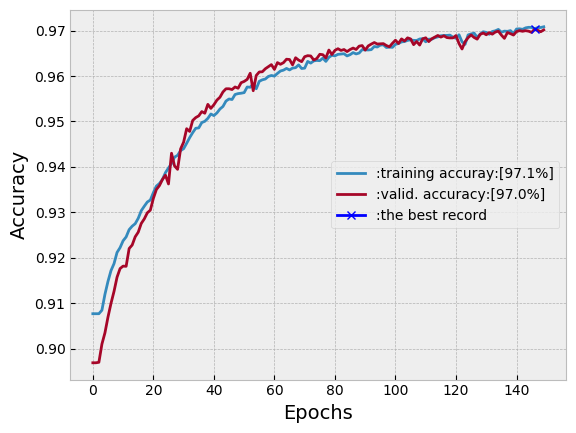

In [32]:
plt.style.use('bmh')

plt.plot(results.history['accuracy'],
         label=':training accuray:['+str(str(format(results.history['accuracy'][-1]*100,'.1f'))+'%]'))
plt.plot(results.history['val_accuracy'],
         label=':valid. accuracy:['+str(str(format(results.history['val_accuracy'][-1]*100,'.1f'))+'%]'))

plt.plot(np.argmax(results.history["val_accuracy"]),np.max(results.history["val_accuracy"]),marker="x",
         color='b', label=":the best record")
plt.ylabel('Accuracy',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.legend(loc='right');
#plt.savefig('results/graph/Accurcy.tiff', dpi=1200)

### loss curve plot

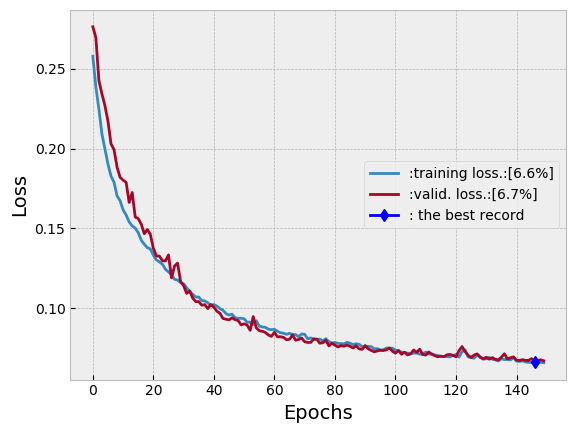

In [27]:
plt.style.use('bmh')
    
plt.plot(results.history['loss'],
         label=':training loss.:['+str(str(format(results.history['loss'][-1]*100,'.1f'))+'%]'))
plt.plot(results.history['val_loss'],
         label=':valid. loss.:['+str(str(format(results.history['val_loss'][-1]*100,'.1f'))+'%]'))

plt.plot(np.argmin(results.history["val_loss"]),np.min(results.history["val_loss"]), marker="d",
         color='b', label=": the best record")
plt.ylabel('Loss',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.legend(loc='right');
#plt.savefig('results/graph/Loss.tiff', dpi=1200)

# Step 2: Evaluate the Model

## define the IoU segmentation metric

In [33]:
def IoU(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

## recompile with evaluation functions

In [34]:
SegClassModelEval = UnetModel()
SegClassModelEval.compile(optimizer='adam', loss='binary_crossentropy', 
                          metrics= [IoU,tf.keras.metrics.Precision(thresholds=0.5),
                                    tf.keras.metrics.Recall(thresholds=0.5),tf.keras.metrics.TruePositives(),
                                    tf.keras.metrics.TrueNegatives(),tf.keras.metrics.FalsePositives(),tf.keras.metrics.FalseNegatives()])
#SegmodelEval.summary()

## fit the model for evaluation

In [35]:
EvalResults = SegClassModelEval.fit(Xtrain, ytrain, validation_split=0.14, batch_size =16, epochs=500)
#model.save('results/pre-trained model/FaultRecogCNN.h5')

Train on 577 samples, validate on 95 samples
Epoch 1/500
577/577 [==============================] - ETA: 3:24 - loss: 0.7725 - IoU: 0.0763 - precision_2: 0.0847 - recall_2: 0.6756 - true_positives: 60255.0000 - true_negatives: 307841.0000 - false_positives: 651554.0000 - false_negatives: 28926.00 - ETA: 2:45 - loss: 0.6857 - IoU: 0.0849 - precision_2: 0.0914 - recall_2: 0.4328 - true_positives: 88716.0000 - true_negatives: 1010275.0000 - false_positives: 881912.0000 - false_negatives: 116249.00 - ETA: 2:30 - loss: 0.5786 - IoU: 0.0743 - precision_2: 0.0896 - recall_2: 0.3400 - true_positives: 92941.0000 - true_negatives: 1927734.0000 - false_positives: 944623.0000 - false_negatives: 180430.00 - ETA: 2:21 - loss: 0.5753 - IoU: 0.0609 - precision_2: 0.0895 - recall_2: 0.2563 - true_positives: 93812.0000 - true_negatives: 2873601.0000 - false_positives: 954688.0000 - false_negatives: 272203.00 - ETA: 2:13 - loss: 0.5526 - IoU: 0.0594 - precision_2: 0.0899 - recall_2: 0.1927 - true_positiv

577/577 [==============================] - ETA: 2:20 - loss: 0.3371 - IoU: 0.0595 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - true_positives: 0.0000e+00 - true_negatives: 933308.0000 - false_positives: 2.0000 - false_negatives: 115266.00 - ETA: 2:13 - loss: 0.3236 - IoU: 0.0569 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - true_positives: 0.0000e+00 - true_negatives: 1879282.0000 - false_positives: 5.0000 - false_negatives: 217865.000 - ETA: 2:09 - loss: 0.3127 - IoU: 0.0560 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - true_positives: 0.0000e+00 - true_negatives: 2832026.0000 - false_positives: 9.0000 - false_negatives: 313693.000 - ETA: 2:05 - loss: 0.3187 - IoU: 0.0567 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - true_positives: 0.0000e+00 - true_negatives: 3765693.0000 - false_positives: 23.0000 - false_negatives: 428588.00 - ETA: 2:01 - loss: 0.3179 - IoU: 0.0583 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - true_positives: 0.0000e+00 - true_negatives: 

577/577 [==============================] - ETA: 2:14 - loss: 0.2489 - IoU: 0.0582 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - true_positives: 0.0000e+00 - true_negatives: 968679.0000 - false_positives: 0.0000e+00 - false_negatives: 79897.000 - ETA: 2:17 - loss: 0.2672 - IoU: 0.0652 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - true_positives: 0.0000e+00 - true_negatives: 1917819.0000 - false_positives: 0.0000e+00 - false_negatives: 179333.000 - ETA: 2:12 - loss: 0.2676 - IoU: 0.0646 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - true_positives: 0.0000e+00 - true_negatives: 2882386.0000 - false_positives: 0.0000e+00 - false_negatives: 263342.000 - ETA: 2:07 - loss: 0.2737 - IoU: 0.0666 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - true_positives: 0.0000e+00 - true_negatives: 3829769.0000 - false_positives: 0.0000e+00 - false_negatives: 364535.000 - ETA: 2:04 - loss: 0.2730 - IoU: 0.0673 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - true_positives: 0.0000e+00 - 

577/577 [==============================] - ETA: 2:21 - loss: 0.2622 - IoU: 0.0785 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - true_positives: 0.0000e+00 - true_negatives: 952434.0000 - false_positives: 0.0000e+00 - false_negatives: 96142.000 - ETA: 2:18 - loss: 0.2554 - IoU: 0.0748 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - true_positives: 0.0000e+00 - true_negatives: 1910516.0000 - false_positives: 0.0000e+00 - false_negatives: 186636.000 - ETA: 2:13 - loss: 0.2549 - IoU: 0.0744 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - true_positives: 0.0000e+00 - true_negatives: 2865553.0000 - false_positives: 0.0000e+00 - false_negatives: 280175.000 - ETA: 2:08 - loss: 0.2664 - IoU: 0.0779 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - true_positives: 0.0000e+00 - true_negatives: 3796442.0000 - false_positives: 0.0000e+00 - false_negatives: 397862.000 - ETA: 2:04 - loss: 0.2801 - IoU: 0.0833 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - true_positives: 0.0000e+00 - 

577/577 [==============================] - ETA: 3:01 - loss: 0.2240 - IoU: 0.1067 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - true_positives: 0.0000e+00 - true_negatives: 958241.0000 - false_positives: 0.0000e+00 - false_negatives: 90335.000 - ETA: 2:56 - loss: 0.2334 - IoU: 0.1014 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - true_positives: 0.0000e+00 - true_negatives: 1910732.0000 - false_positives: 0.0000e+00 - false_negatives: 186420.000 - ETA: 2:53 - loss: 0.2394 - IoU: 0.1023 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - true_positives: 0.0000e+00 - true_negatives: 2858318.0000 - false_positives: 0.0000e+00 - false_negatives: 287410.000 - ETA: 2:48 - loss: 0.2420 - IoU: 0.1045 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - true_positives: 0.0000e+00 - true_negatives: 3805801.0000 - false_positives: 0.0000e+00 - false_negatives: 388503.000 - ETA: 2:42 - loss: 0.2448 - IoU: 0.1056 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - true_positives: 0.0000e+00 - 

577/577 [==============================] - ETA: 3:07 - loss: 0.2197 - IoU: 0.1442 - precision_2: 0.7552 - recall_2: 0.0089 - true_positives: 839.0000 - true_negatives: 954358.0000 - false_positives: 272.0000 - false_negatives: 93107.000 - ETA: 2:59 - loss: 0.2147 - IoU: 0.1440 - precision_2: 0.6343 - recall_2: 0.0105 - true_positives: 1941.0000 - true_negatives: 1910844.0000 - false_positives: 1119.0000 - false_negatives: 183248.000 - ETA: 2:53 - loss: 0.2261 - IoU: 0.1380 - precision_2: 0.6080 - recall_2: 0.0082 - true_positives: 2398.0000 - true_negatives: 2851615.0000 - false_positives: 1546.0000 - false_negatives: 290169.000 - ETA: 2:49 - loss: 0.2205 - IoU: 0.1410 - precision_2: 0.6088 - recall_2: 0.0104 - true_positives: 3996.0000 - true_negatives: 3807952.0000 - false_positives: 2568.0000 - false_negatives: 379788.000 - ETA: 2:43 - loss: 0.2123 - IoU: 0.1419 - precision_2: 0.6071 - recall_2: 0.0142 - true_positives: 6517.0000 - true_negatives: 4780286.0000 - false_positives: 421

577/577 [==============================] - ETA: 3:03 - loss: 0.1890 - IoU: 0.1937 - precision_2: 0.7283 - recall_2: 0.0922 - true_positives: 8399.0000 - true_negatives: 954307.0000 - false_positives: 3134.0000 - false_negatives: 82736.000 - ETA: 3:00 - loss: 0.1947 - IoU: 0.1995 - precision_2: 0.7367 - recall_2: 0.0878 - true_positives: 16684.0000 - true_negatives: 1901237.0000 - false_positives: 5963.0000 - false_negatives: 173268.00 - ETA: 2:53 - loss: 0.1757 - IoU: 0.2182 - precision_2: 0.7124 - recall_2: 0.1187 - true_positives: 31548.0000 - true_negatives: 2867318.0000 - false_positives: 12734.0000 - false_negatives: 234128.000 - ETA: 2:48 - loss: 0.1656 - IoU: 0.2259 - precision_2: 0.7043 - recall_2: 0.1419 - true_positives: 47934.0000 - true_negatives: 3836313.0000 - false_positives: 20121.0000 - false_negatives: 289936.000 - ETA: 2:43 - loss: 0.1739 - IoU: 0.2290 - precision_2: 0.7075 - recall_2: 0.1403 - true_positives: 62346.0000 - true_negatives: 4772768.0000 - false_positiv

577/577 [==============================] - ETA: 3:01 - loss: 0.2281 - IoU: 0.2473 - precision_2: 0.7613 - recall_2: 0.0931 - true_positives: 10653.0000 - true_negatives: 930762.0000 - false_positives: 3341.0000 - false_negatives: 103820.000 - ETA: 2:58 - loss: 0.2019 - IoU: 0.2502 - precision_2: 0.7700 - recall_2: 0.1064 - true_positives: 22128.0000 - true_negatives: 1882668.0000 - false_positives: 6611.0000 - false_negatives: 185745.00 - ETA: 2:53 - loss: 0.1864 - IoU: 0.2522 - precision_2: 0.7831 - recall_2: 0.1282 - true_positives: 37397.0000 - true_negatives: 2843586.0000 - false_positives: 10360.0000 - false_negatives: 254385.000 - ETA: 2:48 - loss: 0.1791 - IoU: 0.2515 - precision_2: 0.7758 - recall_2: 0.1399 - true_positives: 52332.0000 - true_negatives: 3805198.0000 - false_positives: 15126.0000 - false_negatives: 321648.000 - ETA: 2:43 - loss: 0.1750 - IoU: 0.2559 - precision_2: 0.7585 - recall_2: 0.1511 - true_positives: 69535.0000 - true_negatives: 4760493.0000 - false_posit

577/577 [==============================] - ETA: 3:02 - loss: 0.1380 - IoU: 0.3555 - precision_2: 0.6911 - recall_2: 0.3627 - true_positives: 29685.0000 - true_negatives: 953457.0000 - false_positives: 13268.0000 - false_negatives: 52166.000 - ETA: 2:57 - loss: 0.1661 - IoU: 0.3328 - precision_2: 0.6739 - recall_2: 0.2914 - true_positives: 54548.0000 - true_negatives: 1883538.0000 - false_positives: 26397.0000 - false_negatives: 132669.000 - ETA: 2:54 - loss: 0.1733 - IoU: 0.3291 - precision_2: 0.6848 - recall_2: 0.2686 - true_positives: 78393.0000 - true_negatives: 2817813.0000 - false_positives: 36078.0000 - false_negatives: 213444.000 - ETA: 2:50 - loss: 0.1636 - IoU: 0.3363 - precision_2: 0.6944 - recall_2: 0.2811 - true_positives: 104692.0000 - true_negatives: 3775865.0000 - false_positives: 46067.0000 - false_negatives: 267680.00 - ETA: 2:45 - loss: 0.1681 - IoU: 0.3259 - precision_2: 0.7007 - recall_2: 0.2594 - true_positives: 122526.0000 - true_negatives: 4718107.0000 - false_po

577/577 [==============================] - ETA: 3:08 - loss: 0.1741 - IoU: 0.3073 - precision_2: 0.7319 - recall_2: 0.2077 - true_positives: 20293.0000 - true_negatives: 943425.0000 - false_positives: 7433.0000 - false_negatives: 77425.00 - ETA: 3:00 - loss: 0.1790 - IoU: 0.3452 - precision_2: 0.7339 - recall_2: 0.2410 - true_positives: 50021.0000 - true_negatives: 1871482.0000 - false_positives: 18140.0000 - false_negatives: 157509.000 - ETA: 2:54 - loss: 0.1742 - IoU: 0.3457 - precision_2: 0.7177 - recall_2: 0.2514 - true_positives: 75592.0000 - true_negatives: 2815286.0000 - false_positives: 29734.0000 - false_negatives: 225116.000 - ETA: 2:49 - loss: 0.1813 - IoU: 0.3360 - precision_2: 0.7127 - recall_2: 0.2341 - true_positives: 95914.0000 - true_negatives: 3745890.0000 - false_positives: 38670.0000 - false_negatives: 313830.000 - ETA: 2:44 - loss: 0.1828 - IoU: 0.3297 - precision_2: 0.7182 - recall_2: 0.2224 - true_positives: 114473.0000 - true_negatives: 4683256.0000 - false_posi

577/577 [==============================] - ETA: 3:02 - loss: 0.1192 - IoU: 0.4248 - precision_2: 0.8069 - recall_2: 0.3865 - true_positives: 31634.0000 - true_negatives: 959153.0000 - false_positives: 7571.0000 - false_negatives: 50218.00 - ETA: 3:00 - loss: 0.1291 - IoU: 0.3988 - precision_2: 0.8011 - recall_2: 0.3360 - true_positives: 56762.0000 - true_negatives: 1914127.0000 - false_positives: 14090.0000 - false_negatives: 112173.000 - ETA: 3:02 - loss: 0.1360 - IoU: 0.4002 - precision_2: 0.7897 - recall_2: 0.3357 - true_positives: 88630.0000 - true_negatives: 2858121.0000 - false_positives: 23601.0000 - false_negatives: 175376.000 - ETA: 2:56 - loss: 0.1572 - IoU: 0.3743 - precision_2: 0.7493 - recall_2: 0.3005 - true_positives: 115279.0000 - true_negatives: 3772059.0000 - false_positives: 38569.0000 - false_negatives: 268397.00 - ETA: 2:53 - loss: 0.1656 - IoU: 0.3637 - precision_2: 0.7399 - recall_2: 0.2836 - true_positives: 141250.0000 - true_negatives: 4695192.0000 - false_posi

577/577 [==============================] - ETA: 3:01 - loss: 0.1768 - IoU: 0.4029 - precision_2: 0.7552 - recall_2: 0.2862 - true_positives: 31803.0000 - true_negatives: 927159.0000 - false_positives: 10310.0000 - false_negatives: 79304.000 - ETA: 2:58 - loss: 0.1562 - IoU: 0.4079 - precision_2: 0.7467 - recall_2: 0.3296 - true_positives: 66017.0000 - true_negatives: 1874433.0000 - false_positives: 22399.0000 - false_negatives: 134303.000 - ETA: 2:53 - loss: 0.1564 - IoU: 0.3971 - precision_2: 0.7319 - recall_2: 0.3268 - true_positives: 96482.0000 - true_negatives: 2815137.0000 - false_positives: 35351.0000 - false_negatives: 198758.000 - ETA: 2:48 - loss: 0.1578 - IoU: 0.3897 - precision_2: 0.7327 - recall_2: 0.3169 - true_positives: 124608.0000 - true_negatives: 3755615.0000 - false_positives: 45462.0000 - false_negatives: 268619.00 - ETA: 2:43 - loss: 0.1750 - IoU: 0.3723 - precision_2: 0.7249 - recall_2: 0.2838 - true_positives: 150960.0000 - true_negatives: 4653600.0000 - false_po

577/577 [==============================] - ETA: 3:02 - loss: 0.1790 - IoU: 0.3788 - precision_2: 0.6834 - recall_2: 0.3260 - true_positives: 35876.0000 - true_negatives: 921923.0000 - false_positives: 16619.0000 - false_negatives: 74158.000 - ETA: 2:57 - loss: 0.1689 - IoU: 0.3617 - precision_2: 0.6879 - recall_2: 0.3074 - true_positives: 63005.0000 - true_negatives: 1863625.0000 - false_positives: 28588.0000 - false_negatives: 141934.000 - ETA: 2:54 - loss: 0.1640 - IoU: 0.3689 - precision_2: 0.7021 - recall_2: 0.3107 - true_positives: 94464.0000 - true_negatives: 2801657.0000 - false_positives: 40075.0000 - false_negatives: 209532.000 - ETA: 2:48 - loss: 0.1732 - IoU: 0.3643 - precision_2: 0.7031 - recall_2: 0.2998 - true_positives: 127238.0000 - true_negatives: 3716118.0000 - false_positives: 53736.0000 - false_negatives: 297212.00 - ETA: 2:43 - loss: 0.1748 - IoU: 0.3705 - precision_2: 0.6969 - recall_2: 0.3103 - true_positives: 166950.0000 - true_negatives: 4632245.0000 - false_po

577/577 [==============================] - ETA: 3:03 - loss: 0.1101 - IoU: 0.4033 - precision_2: 0.7543 - recall_2: 0.4163 - true_positives: 31712.0000 - true_negatives: 962064.0000 - false_positives: 10328.0000 - false_negatives: 44472.000 - ETA: 2:57 - loss: 0.1107 - IoU: 0.4371 - precision_2: 0.7464 - recall_2: 0.4373 - true_positives: 68491.0000 - true_negatives: 1917250.0000 - false_positives: 23266.0000 - false_negatives: 88145.00 - ETA: 2:53 - loss: 0.1315 - IoU: 0.4268 - precision_2: 0.7255 - recall_2: 0.4097 - true_positives: 110073.0000 - true_negatives: 2835374.0000 - false_positives: 41657.0000 - false_negatives: 158624.00 - ETA: 2:48 - loss: 0.1393 - IoU: 0.4020 - precision_2: 0.7063 - recall_2: 0.3860 - true_positives: 141266.0000 - true_negatives: 3769581.0000 - false_positives: 58742.0000 - false_negatives: 224715.00 - ETA: 2:42 - loss: 0.1453 - IoU: 0.4049 - precision_2: 0.7091 - recall_2: 0.3782 - true_positives: 179350.0000 - true_negatives: 4695048.0000 - false_posi

577/577 [==============================] - ETA: 3:06 - loss: 0.1291 - IoU: 0.4022 - precision_2: 0.7402 - recall_2: 0.3754 - true_positives: 33130.0000 - true_negatives: 948689.0000 - false_positives: 11629.0000 - false_negatives: 55128.000 - ETA: 3:00 - loss: 0.1301 - IoU: 0.4182 - precision_2: 0.7297 - recall_2: 0.3911 - true_positives: 69841.0000 - true_negatives: 1892693.0000 - false_positives: 25865.0000 - false_negatives: 108753.000 - ETA: 2:53 - loss: 0.1569 - IoU: 0.3899 - precision_2: 0.6836 - recall_2: 0.3744 - true_positives: 114565.0000 - true_negatives: 2786657.0000 - false_positives: 53034.0000 - false_negatives: 191472.00 - ETA: 2:48 - loss: 0.1530 - IoU: 0.3963 - precision_2: 0.6883 - recall_2: 0.3891 - true_positives: 157188.0000 - true_negatives: 3719144.0000 - false_positives: 71183.0000 - false_negatives: 246789.00 - ETA: 2:43 - loss: 0.1524 - IoU: 0.3970 - precision_2: 0.6967 - recall_2: 0.3872 - true_positives: 196039.0000 - true_negatives: 4651298.0000 - false_po

577/577 [==============================] - ETA: 3:05 - loss: 0.1245 - IoU: 0.4342 - precision_2: 0.7143 - recall_2: 0.4680 - true_positives: 41381.0000 - true_negatives: 943610.0000 - false_positives: 16554.0000 - false_negatives: 47031.000 - ETA: 3:02 - loss: 0.1039 - IoU: 0.4621 - precision_2: 0.7501 - recall_2: 0.5026 - true_positives: 79560.0000 - true_negatives: 1912347.0000 - false_positives: 26510.0000 - false_negatives: 78735.00 - ETA: 2:55 - loss: 0.1077 - IoU: 0.4696 - precision_2: 0.7596 - recall_2: 0.5013 - true_positives: 125399.0000 - true_negatives: 2855895.0000 - false_positives: 39677.0000 - false_negatives: 124757.00 - ETA: 2:49 - loss: 0.1189 - IoU: 0.4492 - precision_2: 0.7358 - recall_2: 0.4862 - true_positives: 171947.0000 - true_negatives: 3778956.0000 - false_positives: 61726.0000 - false_negatives: 181675.00 - ETA: 2:44 - loss: 0.1277 - IoU: 0.4379 - precision_2: 0.7198 - recall_2: 0.4759 - true_positives: 220027.0000 - true_negatives: 4694866.0000 - false_posi

577/577 [==============================] - ETA: 3:00 - loss: 0.1750 - IoU: 0.3948 - precision_2: 0.6827 - recall_2: 0.4408 - true_positives: 52700.0000 - true_negatives: 904519.0000 - false_positives: 24498.0000 - false_negatives: 66859.000 - ETA: 2:56 - loss: 0.1684 - IoU: 0.3997 - precision_2: 0.6862 - recall_2: 0.4350 - true_positives: 100590.0000 - true_negatives: 1819915.0000 - false_positives: 45990.0000 - false_negatives: 130657.00 - ETA: 2:53 - loss: 0.1465 - IoU: 0.4298 - precision_2: 0.7058 - recall_2: 0.4695 - true_positives: 148206.0000 - true_negatives: 2768243.0000 - false_positives: 61790.0000 - false_negatives: 167489.00 - ETA: 2:47 - loss: 0.1414 - IoU: 0.4428 - precision_2: 0.7123 - recall_2: 0.4862 - true_positives: 201803.0000 - true_negatives: 3697744.0000 - false_positives: 81498.0000 - false_negatives: 213259.00 - ETA: 2:42 - loss: 0.1417 - IoU: 0.4460 - precision_2: 0.7087 - recall_2: 0.4909 - true_positives: 254888.0000 - true_negatives: 4618906.0000 - false_po

577/577 [==============================] - ETA: 3:05 - loss: 0.1543 - IoU: 0.4460 - precision_2: 0.6990 - recall_2: 0.4950 - true_positives: 56203.0000 - true_negatives: 910843.0000 - false_positives: 24197.0000 - false_negatives: 57333.000 - ETA: 2:58 - loss: 0.1294 - IoU: 0.4808 - precision_2: 0.7154 - recall_2: 0.5440 - true_positives: 109464.0000 - true_negatives: 1852392.0000 - false_positives: 43540.0000 - false_negatives: 91756.000 - ETA: 2:53 - loss: 0.1335 - IoU: 0.4686 - precision_2: 0.7106 - recall_2: 0.5459 - true_positives: 168189.0000 - true_negatives: 2769099.0000 - false_positives: 68512.0000 - false_negatives: 139928.00 - ETA: 2:49 - loss: 0.1163 - IoU: 0.4865 - precision_2: 0.7238 - recall_2: 0.5716 - true_positives: 212393.0000 - true_negatives: 3741686.0000 - false_positives: 81031.0000 - false_negatives: 159194.00 - ETA: 2:43 - loss: 0.1279 - IoU: 0.4675 - precision_2: 0.7119 - recall_2: 0.5486 - true_positives: 270335.0000 - true_negatives: 4640731.0000 - false_po

577/577 [==============================] - ETA: 3:06 - loss: 0.1161 - IoU: 0.4377 - precision_2: 0.7046 - recall_2: 0.5387 - true_positives: 46543.0000 - true_negatives: 942670.0000 - false_positives: 19512.0000 - false_negatives: 39851.000 - ETA: 3:00 - loss: 0.1113 - IoU: 0.4561 - precision_2: 0.7206 - recall_2: 0.5654 - true_positives: 97992.0000 - true_negatives: 1885837.0000 - false_positives: 37992.0000 - false_negatives: 75331.00 - ETA: 2:55 - loss: 0.1060 - IoU: 0.4667 - precision_2: 0.7222 - recall_2: 0.5871 - true_positives: 148624.0000 - true_negatives: 2835411.0000 - false_positives: 57158.0000 - false_negatives: 104535.00 - ETA: 2:50 - loss: 0.1178 - IoU: 0.4512 - precision_2: 0.7021 - recall_2: 0.5824 - true_positives: 211300.0000 - true_negatives: 3741837.0000 - false_positives: 89671.0000 - false_negatives: 151496.00 - ETA: 2:44 - loss: 0.1263 - IoU: 0.4496 - precision_2: 0.6987 - recall_2: 0.5741 - true_positives: 276674.0000 - true_negatives: 4641629.0000 - false_posi

577/577 [==============================] - ETA: 3:01 - loss: 0.1309 - IoU: 0.4262 - precision_2: 0.7088 - recall_2: 0.5428 - true_positives: 53508.0000 - true_negatives: 928012.0000 - false_positives: 21981.0000 - false_negatives: 45075.000 - ETA: 3:00 - loss: 0.1159 - IoU: 0.4493 - precision_2: 0.7062 - recall_2: 0.5797 - true_positives: 104151.0000 - true_negatives: 1874170.0000 - false_positives: 43320.0000 - false_negatives: 75511.000 - ETA: 2:53 - loss: 0.1168 - IoU: 0.4652 - precision_2: 0.7110 - recall_2: 0.5995 - true_positives: 166781.0000 - true_negatives: 2799712.0000 - false_positives: 67794.0000 - false_negatives: 111441.00 - ETA: 2:47 - loss: 0.1311 - IoU: 0.4523 - precision_2: 0.7023 - recall_2: 0.5838 - true_positives: 237860.0000 - true_negatives: 3686035.0000 - false_positives: 100849.0000 - false_negatives: 169560.000 - ETA: 2:43 - loss: 0.1324 - IoU: 0.4484 - precision_2: 0.7028 - recall_2: 0.5742 - true_positives: 292983.0000 - true_negatives: 4608778.0000 - false_

577/577 [==============================] - ETA: 3:01 - loss: 0.1346 - IoU: 0.4589 - precision_2: 0.6788 - recall_2: 0.6384 - true_positives: 66973.0000 - true_negatives: 911979.0000 - false_positives: 31697.0000 - false_negatives: 37927.000 - ETA: 2:59 - loss: 0.1280 - IoU: 0.4630 - precision_2: 0.6812 - recall_2: 0.6500 - true_positives: 130850.0000 - true_negatives: 1834584.0000 - false_positives: 61246.0000 - false_negatives: 70472.000 - ETA: 2:53 - loss: 0.1220 - IoU: 0.4829 - precision_2: 0.6975 - recall_2: 0.6470 - true_positives: 191695.0000 - true_negatives: 2766325.0000 - false_positives: 83128.0000 - false_negatives: 104580.00 - ETA: 2:48 - loss: 0.1244 - IoU: 0.4821 - precision_2: 0.7023 - recall_2: 0.6353 - true_positives: 255214.0000 - true_negatives: 3684406.0000 - false_positives: 108190.0000 - false_negatives: 146494.000 - ETA: 2:43 - loss: 0.1250 - IoU: 0.4844 - precision_2: 0.7051 - recall_2: 0.6361 - true_positives: 322695.0000 - true_negatives: 4600609.0000 - false_

577/577 [==============================] - ETA: 3:02 - loss: 0.0984 - IoU: 0.5253 - precision_2: 0.7156 - recall_2: 0.7059 - true_positives: 60921.0000 - true_negatives: 938069.0000 - false_positives: 24208.0000 - false_negatives: 25378.000 - ETA: 2:57 - loss: 0.1046 - IoU: 0.5014 - precision_2: 0.7268 - recall_2: 0.6593 - true_positives: 118679.0000 - true_negatives: 1872542.0000 - false_positives: 44616.0000 - false_negatives: 61315.000 - ETA: 2:53 - loss: 0.1117 - IoU: 0.4980 - precision_2: 0.7275 - recall_2: 0.6284 - true_positives: 176297.0000 - true_negatives: 2799137.0000 - false_positives: 66044.0000 - false_negatives: 104250.00 - ETA: 2:48 - loss: 0.1160 - IoU: 0.4798 - precision_2: 0.7206 - recall_2: 0.6191 - true_positives: 235915.0000 - true_negatives: 3721764.0000 - false_positives: 91470.0000 - false_negatives: 145155.00 - ETA: 2:43 - loss: 0.1194 - IoU: 0.4753 - precision_2: 0.7138 - recall_2: 0.6159 - true_positives: 297327.0000 - true_negatives: 4640874.0000 - false_po

577/577 [==============================] - ETA: 3:04 - loss: 0.0568 - IoU: 0.5979 - precision_2: 0.8103 - recall_2: 0.7481 - true_positives: 48688.0000 - true_negatives: 972101.0000 - false_positives: 11396.0000 - false_negatives: 16391.000 - ETA: 2:57 - loss: 0.0844 - IoU: 0.5652 - precision_2: 0.7658 - recall_2: 0.6952 - true_positives: 113689.0000 - true_negatives: 1898852.0000 - false_positives: 34773.0000 - false_negatives: 49838.000 - ETA: 2:52 - loss: 0.0967 - IoU: 0.5447 - precision_2: 0.7449 - recall_2: 0.6883 - true_positives: 184171.0000 - true_negatives: 2815091.0000 - false_positives: 63065.0000 - false_negatives: 83401.000 - ETA: 2:48 - loss: 0.1047 - IoU: 0.5359 - precision_2: 0.7366 - recall_2: 0.6855 - true_positives: 259526.0000 - true_negatives: 3722876.0000 - false_positives: 92824.0000 - false_negatives: 119078.00 - ETA: 2:42 - loss: 0.1090 - IoU: 0.5299 - precision_2: 0.7330 - recall_2: 0.6816 - true_positives: 332063.0000 - true_negatives: 4634689.0000 - false_po

577/577 [==============================] - ETA: 3:04 - loss: 0.1398 - IoU: 0.4966 - precision_2: 0.7141 - recall_2: 0.6407 - true_positives: 74472.0000 - true_negatives: 902524.0000 - false_positives: 29817.0000 - false_negatives: 41763.000 - ETA: 3:00 - loss: 0.1285 - IoU: 0.5153 - precision_2: 0.7226 - recall_2: 0.6689 - true_positives: 148499.0000 - true_negatives: 1818132.0000 - false_positives: 57000.0000 - false_negatives: 73521.000 - ETA: 2:54 - loss: 0.1303 - IoU: 0.5100 - precision_2: 0.7133 - recall_2: 0.6725 - true_positives: 224086.0000 - true_negatives: 2722458.0000 - false_positives: 90066.0000 - false_negatives: 109118.00 - ETA: 2:49 - loss: 0.1276 - IoU: 0.5031 - precision_2: 0.7144 - recall_2: 0.6719 - true_positives: 292925.0000 - true_negatives: 3641288.0000 - false_positives: 117081.0000 - false_negatives: 143010.000 - ETA: 2:44 - loss: 0.1177 - IoU: 0.5180 - precision_2: 0.7264 - recall_2: 0.6777 - true_positives: 350328.0000 - true_negatives: 4593967.0000 - false_

577/577 [==============================] - ETA: 3:02 - loss: 0.0991 - IoU: 0.5165 - precision_2: 0.7304 - recall_2: 0.7273 - true_positives: 66395.0000 - true_negatives: 932772.0000 - false_positives: 24513.0000 - false_negatives: 24896.000 - ETA: 2:59 - loss: 0.0959 - IoU: 0.5046 - precision_2: 0.7320 - recall_2: 0.7140 - true_positives: 124760.0000 - true_negatives: 1876743.0000 - false_positives: 45670.0000 - false_negatives: 49979.000 - ETA: 2:55 - loss: 0.1041 - IoU: 0.5041 - precision_2: 0.7325 - recall_2: 0.6983 - true_positives: 196261.0000 - true_negatives: 2793000.0000 - false_positives: 71688.0000 - false_negatives: 84779.000 - ETA: 2:48 - loss: 0.1094 - IoU: 0.4997 - precision_2: 0.7289 - recall_2: 0.6896 - true_positives: 267540.0000 - true_negatives: 3706850.0000 - false_positives: 99517.0000 - false_negatives: 120397.00 - ETA: 2:43 - loss: 0.1148 - IoU: 0.5014 - precision_2: 0.7255 - recall_2: 0.6891 - true_positives: 349123.0000 - true_negatives: 4604129.0000 - false_po

577/577 [==============================] - ETA: 3:05 - loss: 0.0630 - IoU: 0.5810 - precision_2: 0.7903 - recall_2: 0.7487 - true_positives: 51773.0000 - true_negatives: 965686.0000 - false_positives: 13740.0000 - false_negatives: 17377.000 - ETA: 2:58 - loss: 0.0908 - IoU: 0.5520 - precision_2: 0.7536 - recall_2: 0.7222 - true_positives: 127961.0000 - true_negatives: 1878131.0000 - false_positives: 41849.0000 - false_negatives: 49211.000 - ETA: 2:54 - loss: 0.0881 - IoU: 0.5534 - precision_2: 0.7533 - recall_2: 0.7311 - true_positives: 190051.0000 - true_negatives: 2823520.0000 - false_positives: 62256.0000 - false_negatives: 69901.000 - ETA: 2:48 - loss: 0.0852 - IoU: 0.5505 - precision_2: 0.7547 - recall_2: 0.7308 - true_positives: 244295.0000 - true_negatives: 3780592.0000 - false_positives: 79419.0000 - false_negatives: 89998.000 - ETA: 2:43 - loss: 0.0895 - IoU: 0.5433 - precision_2: 0.7527 - recall_2: 0.7246 - true_positives: 313812.0000 - true_negatives: 4706715.0000 - false_po

577/577 [==============================] - ETA: 3:05 - loss: 0.1301 - IoU: 0.5007 - precision_2: 0.7073 - recall_2: 0.7302 - true_positives: 83972.0000 - true_negatives: 898817.0000 - false_positives: 34757.0000 - false_negatives: 31030.000 - ETA: 2:59 - loss: 0.1002 - IoU: 0.5566 - precision_2: 0.7262 - recall_2: 0.7622 - true_positives: 145403.0000 - true_negatives: 1851579.0000 - false_positives: 54809.0000 - false_negatives: 45361.000 - ETA: 2:53 - loss: 0.1037 - IoU: 0.5426 - precision_2: 0.7261 - recall_2: 0.7459 - true_positives: 216947.0000 - true_negatives: 2773006.0000 - false_positives: 81857.0000 - false_negatives: 73918.000 - ETA: 2:48 - loss: 0.1035 - IoU: 0.5317 - precision_2: 0.7316 - recall_2: 0.7265 - true_positives: 279591.0000 - true_negatives: 3706876.0000 - false_positives: 102574.0000 - false_negatives: 105263.000 - ETA: 2:43 - loss: 0.1069 - IoU: 0.5289 - precision_2: 0.7373 - recall_2: 0.7110 - true_positives: 352178.0000 - true_negatives: 4622042.0000 - false_

577/577 [==============================] - ETA: 3:01 - loss: 0.1076 - IoU: 0.4975 - precision_2: 0.7419 - recall_2: 0.7022 - true_positives: 69958.0000 - true_negatives: 924607.0000 - false_positives: 24338.0000 - false_negatives: 29673.000 - ETA: 2:59 - loss: 0.0880 - IoU: 0.5447 - precision_2: 0.7637 - recall_2: 0.7242 - true_positives: 126505.0000 - true_negatives: 1883329.0000 - false_positives: 39138.0000 - false_negatives: 48180.000 - ETA: 2:53 - loss: 0.0874 - IoU: 0.5666 - precision_2: 0.7709 - recall_2: 0.7396 - true_positives: 199890.0000 - true_negatives: 2816055.0000 - false_positives: 59401.0000 - false_negatives: 70382.000 - ETA: 2:47 - loss: 0.0981 - IoU: 0.5528 - precision_2: 0.7508 - recall_2: 0.7425 - true_positives: 288050.0000 - true_negatives: 3710738.0000 - false_positives: 95606.0000 - false_negatives: 99910.000 - ETA: 2:43 - loss: 0.1007 - IoU: 0.5470 - precision_2: 0.7484 - recall_2: 0.7400 - true_positives: 365446.0000 - true_negatives: 4626180.0000 - false_po

577/577 [==============================] - ETA: 3:03 - loss: 0.0625 - IoU: 0.6261 - precision_2: 0.8283 - recall_2: 0.7643 - true_positives: 58901.0000 - true_negatives: 959301.0000 - false_positives: 12209.0000 - false_negatives: 18165.000 - ETA: 2:57 - loss: 0.0753 - IoU: 0.6036 - precision_2: 0.7916 - recall_2: 0.7627 - true_positives: 128197.0000 - true_negatives: 1895327.0000 - false_positives: 33742.0000 - false_negatives: 39886.000 - ETA: 2:56 - loss: 0.0864 - IoU: 0.5876 - precision_2: 0.7675 - recall_2: 0.7586 - true_positives: 205292.0000 - true_negatives: 2812942.0000 - false_positives: 62179.0000 - false_negatives: 65315.000 - ETA: 2:49 - loss: 0.0893 - IoU: 0.5780 - precision_2: 0.7643 - recall_2: 0.7518 - true_positives: 275940.0000 - true_negatives: 3742182.0000 - false_positives: 85076.0000 - false_negatives: 91106.000 - ETA: 2:43 - loss: 0.0933 - IoU: 0.5749 - precision_2: 0.7663 - recall_2: 0.7404 - true_positives: 351358.0000 - true_negatives: 4661157.0000 - false_po

577/577 [==============================] - ETA: 3:01 - loss: 0.1126 - IoU: 0.5554 - precision_2: 0.7773 - recall_2: 0.6949 - true_positives: 77031.0000 - true_negatives: 915662.0000 - false_positives: 22069.0000 - false_negatives: 33814.000 - ETA: 2:56 - loss: 0.0815 - IoU: 0.5794 - precision_2: 0.7880 - recall_2: 0.7355 - true_positives: 126955.0000 - true_negatives: 1890395.0000 - false_positives: 34149.0000 - false_negatives: 45653.000 - ETA: 2:53 - loss: 0.0856 - IoU: 0.5695 - precision_2: 0.7720 - recall_2: 0.7436 - true_positives: 196881.0000 - true_negatives: 2822798.0000 - false_positives: 58155.0000 - false_negatives: 67894.000 - ETA: 2:47 - loss: 0.0960 - IoU: 0.5569 - precision_2: 0.7602 - recall_2: 0.7431 - true_positives: 286266.0000 - true_negatives: 3718731.0000 - false_positives: 90324.0000 - false_negatives: 98983.000 - ETA: 2:42 - loss: 0.0962 - IoU: 0.5538 - precision_2: 0.7617 - recall_2: 0.7387 - true_positives: 356008.0000 - true_negatives: 4649571.0000 - false_po

577/577 [==============================] - ETA: 3:05 - loss: 0.0988 - IoU: 0.5548 - precision_2: 0.7433 - recall_2: 0.7805 - true_positives: 78092.0000 - true_negatives: 921554.0000 - false_positives: 26972.0000 - false_negatives: 21958.000 - ETA: 2:58 - loss: 0.1023 - IoU: 0.5560 - precision_2: 0.7405 - recall_2: 0.7781 - true_positives: 159740.0000 - true_negatives: 1835856.0000 - false_positives: 55990.0000 - false_negatives: 45566.000 - ETA: 2:53 - loss: 0.1010 - IoU: 0.5621 - precision_2: 0.7498 - recall_2: 0.7659 - true_positives: 235331.0000 - true_negatives: 2759939.0000 - false_positives: 78548.0000 - false_negatives: 71910.000 - ETA: 2:48 - loss: 0.1036 - IoU: 0.5533 - precision_2: 0.7549 - recall_2: 0.7471 - true_positives: 309531.0000 - true_negatives: 3679507.0000 - false_positives: 100494.0000 - false_negatives: 104772.000 - ETA: 2:43 - loss: 0.0985 - IoU: 0.5618 - precision_2: 0.7602 - recall_2: 0.7495 - true_positives: 374890.0000 - true_negatives: 4624421.0000 - false_

577/577 [==============================] - ETA: 3:04 - loss: 0.1112 - IoU: 0.5241 - precision_2: 0.7489 - recall_2: 0.7431 - true_positives: 80711.0000 - true_negatives: 912904.0000 - false_positives: 27057.0000 - false_negatives: 27904.000 - ETA: 3:00 - loss: 0.1020 - IoU: 0.5372 - precision_2: 0.7521 - recall_2: 0.7487 - true_positives: 150570.0000 - true_negatives: 1846404.0000 - false_positives: 49638.0000 - false_negatives: 50540.000 - ETA: 2:56 - loss: 0.0998 - IoU: 0.5443 - precision_2: 0.7592 - recall_2: 0.7517 - true_positives: 226924.0000 - true_negatives: 2771894.0000 - false_positives: 71966.0000 - false_negatives: 74944.000 - ETA: 2:50 - loss: 0.1015 - IoU: 0.5367 - precision_2: 0.7572 - recall_2: 0.7473 - true_positives: 302836.0000 - true_negatives: 3691951.0000 - false_positives: 97105.0000 - false_negatives: 102412.00 - ETA: 2:46 - loss: 0.0984 - IoU: 0.5453 - precision_2: 0.7590 - recall_2: 0.7531 - true_positives: 374252.0000 - true_negatives: 4627046.0000 - false_po

577/577 [==============================] - ETA: 3:02 - loss: 0.0575 - IoU: 0.5829 - precision_2: 0.8117 - recall_2: 0.7707 - true_positives: 52127.0000 - true_negatives: 968847.0000 - false_positives: 12091.0000 - false_negatives: 15511.000 - ETA: 2:58 - loss: 0.0720 - IoU: 0.5911 - precision_2: 0.8021 - recall_2: 0.7645 - true_positives: 126127.0000 - true_negatives: 1901041.0000 - false_positives: 31126.0000 - false_negatives: 38858.000 - ETA: 2:53 - loss: 0.0777 - IoU: 0.5748 - precision_2: 0.7938 - recall_2: 0.7564 - true_positives: 194627.0000 - true_negatives: 2837868.0000 - false_positives: 50542.0000 - false_negatives: 62691.000 - ETA: 2:47 - loss: 0.0753 - IoU: 0.5828 - precision_2: 0.7930 - recall_2: 0.7655 - true_positives: 258135.0000 - true_negatives: 3789729.0000 - false_positives: 67362.0000 - false_negatives: 79078.000 - ETA: 2:42 - loss: 0.0901 - IoU: 0.5675 - precision_2: 0.7727 - recall_2: 0.7655 - true_positives: 366779.0000 - true_negatives: 4655833.0000 - false_po

577/577 [==============================] - ETA: 3:06 - loss: 0.1002 - IoU: 0.5953 - precision_2: 0.7648 - recall_2: 0.7966 - true_positives: 86610.0000 - true_negatives: 913218.0000 - false_positives: 26635.0000 - false_negatives: 22113.000 - ETA: 3:00 - loss: 0.1039 - IoU: 0.5756 - precision_2: 0.7605 - recall_2: 0.7756 - true_positives: 168290.0000 - true_negatives: 1827170.0000 - false_positives: 52990.0000 - false_negatives: 48702.000 - ETA: 2:57 - loss: 0.0947 - IoU: 0.5724 - precision_2: 0.7693 - recall_2: 0.7691 - true_positives: 231317.0000 - true_negatives: 2775604.0000 - false_positives: 69370.0000 - false_negatives: 69437.000 - ETA: 2:52 - loss: 0.0957 - IoU: 0.5637 - precision_2: 0.7722 - recall_2: 0.7582 - true_positives: 304848.0000 - true_negatives: 3702314.0000 - false_positives: 89944.0000 - false_negatives: 97198.000 - ETA: 2:45 - loss: 0.0895 - IoU: 0.5668 - precision_2: 0.7748 - recall_2: 0.7618 - true_positives: 361138.0000 - true_negatives: 4663867.0000 - false_po

577/577 [==============================] - ETA: 3:07 - loss: 0.0687 - IoU: 0.6278 - precision_2: 0.7990 - recall_2: 0.8102 - true_positives: 68198.0000 - true_negatives: 947254.0000 - false_positives: 17151.0000 - false_negatives: 15973.000 - ETA: 2:59 - loss: 0.0642 - IoU: 0.6339 - precision_2: 0.8029 - recall_2: 0.8123 - true_positives: 129228.0000 - true_negatives: 1906347.0000 - false_positives: 31717.0000 - false_negatives: 29860.000 - ETA: 2:53 - loss: 0.0858 - IoU: 0.5973 - precision_2: 0.7859 - recall_2: 0.7803 - true_positives: 224709.0000 - true_negatives: 2796562.0000 - false_positives: 61199.0000 - false_negatives: 63258.000 - ETA: 2:48 - loss: 0.0903 - IoU: 0.5854 - precision_2: 0.7831 - recall_2: 0.7739 - true_positives: 306907.0000 - true_negatives: 3712739.0000 - false_positives: 84994.0000 - false_negatives: 89664.000 - ETA: 2:43 - loss: 0.0977 - IoU: 0.5758 - precision_2: 0.7769 - recall_2: 0.7681 - true_positives: 403042.0000 - true_negatives: 4602413.0000 - false_po

577/577 [==============================] - ETA: 3:04 - loss: 0.0801 - IoU: 0.6175 - precision_2: 0.7912 - recall_2: 0.8058 - true_positives: 76640.0000 - true_negatives: 933245.0000 - false_positives: 20224.0000 - false_negatives: 18467.000 - ETA: 3:01 - loss: 0.0827 - IoU: 0.6075 - precision_2: 0.7859 - recall_2: 0.8019 - true_positives: 154045.0000 - true_negatives: 1863100.0000 - false_positives: 41954.0000 - false_negatives: 38053.000 - ETA: 2:55 - loss: 0.0877 - IoU: 0.6027 - precision_2: 0.7813 - recall_2: 0.7960 - true_positives: 238433.0000 - true_negatives: 2779465.0000 - false_positives: 66729.0000 - false_negatives: 61101.000 - ETA: 2:50 - loss: 0.0877 - IoU: 0.5973 - precision_2: 0.7809 - recall_2: 0.7890 - true_positives: 310708.0000 - true_negatives: 3713320.0000 - false_positives: 87195.0000 - false_negatives: 83081.000 - ETA: 2:46 - loss: 0.0901 - IoU: 0.5916 - precision_2: 0.7802 - recall_2: 0.7807 - true_positives: 388571.0000 - true_negatives: 4635696.0000 - false_po

577/577 [==============================] - ETA: 3:05 - loss: 0.0711 - IoU: 0.6205 - precision_2: 0.7944 - recall_2: 0.7959 - true_positives: 66110.0000 - true_negatives: 948403.0000 - false_positives: 17115.0000 - false_negatives: 16948.000 - ETA: 3:02 - loss: 0.0847 - IoU: 0.5954 - precision_2: 0.7911 - recall_2: 0.7696 - true_positives: 145153.0000 - true_negatives: 1870210.0000 - false_positives: 38339.0000 - false_negatives: 43450.000 - ETA: 2:56 - loss: 0.1003 - IoU: 0.5710 - precision_2: 0.7759 - recall_2: 0.7620 - true_positives: 243877.0000 - true_negatives: 2755242.0000 - false_positives: 70438.0000 - false_negatives: 76171.000 - ETA: 2:50 - loss: 0.0925 - IoU: 0.5769 - precision_2: 0.7789 - recall_2: 0.7693 - true_positives: 307164.0000 - true_negatives: 3707829.0000 - false_positives: 87190.0000 - false_negatives: 92121.000 - ETA: 2:45 - loss: 0.0935 - IoU: 0.5741 - precision_2: 0.7757 - recall_2: 0.7717 - true_positives: 387848.0000 - true_negatives: 4628118.0000 - false_po

577/577 [==============================] - ETA: 3:01 - loss: 0.0661 - IoU: 0.5854 - precision_2: 0.7999 - recall_2: 0.7885 - true_positives: 60982.0000 - true_negatives: 955977.0000 - false_positives: 15259.0000 - false_negatives: 16358.000 - ETA: 2:56 - loss: 0.0764 - IoU: 0.5786 - precision_2: 0.7908 - recall_2: 0.7774 - true_positives: 133462.0000 - true_negatives: 1890169.0000 - false_positives: 35297.0000 - false_negatives: 38224.000 - ETA: 2:53 - loss: 0.0856 - IoU: 0.5784 - precision_2: 0.7872 - recall_2: 0.7714 - true_positives: 219020.0000 - true_negatives: 2802609.0000 - false_positives: 59194.0000 - false_negatives: 64905.000 - ETA: 2:47 - loss: 0.0923 - IoU: 0.5732 - precision_2: 0.7818 - recall_2: 0.7702 - true_positives: 309929.0000 - true_negatives: 3705406.0000 - false_positives: 86521.0000 - false_negatives: 92448.000 - ETA: 2:42 - loss: 0.0934 - IoU: 0.5711 - precision_2: 0.7805 - recall_2: 0.7702 - true_positives: 390258.0000 - true_negatives: 4626426.0000 - false_po

577/577 [==============================] - ETA: 3:02 - loss: 0.0830 - IoU: 0.5930 - precision_2: 0.7917 - recall_2: 0.7846 - true_positives: 73996.0000 - true_negatives: 934795.0000 - false_positives: 19466.0000 - false_negatives: 20319.000 - ETA: 2:58 - loss: 0.0934 - IoU: 0.5724 - precision_2: 0.7844 - recall_2: 0.7791 - true_positives: 160810.0000 - true_negatives: 1846536.0000 - false_positives: 44209.0000 - false_negatives: 45597.000 - ETA: 2:54 - loss: 0.0840 - IoU: 0.6015 - precision_2: 0.7931 - recall_2: 0.7948 - true_positives: 232542.0000 - true_negatives: 2792479.0000 - false_positives: 60654.0000 - false_negatives: 60053.000 - ETA: 2:48 - loss: 0.0848 - IoU: 0.6005 - precision_2: 0.7893 - recall_2: 0.7921 - true_positives: 307306.0000 - true_negatives: 3724287.0000 - false_positives: 82051.0000 - false_negatives: 80660.000 - ETA: 2:43 - loss: 0.0890 - IoU: 0.5971 - precision_2: 0.7876 - recall_2: 0.7904 - true_positives: 399902.0000 - true_negatives: 4629075.0000 - false_po

577/577 [==============================] - ETA: 3:06 - loss: 0.0790 - IoU: 0.6250 - precision_2: 0.7978 - recall_2: 0.8021 - true_positives: 76873.0000 - true_negatives: 933258.0000 - false_positives: 19481.0000 - false_negatives: 18964.000 - ETA: 3:00 - loss: 0.0821 - IoU: 0.6139 - precision_2: 0.8018 - recall_2: 0.7958 - true_positives: 157113.0000 - true_negatives: 1860902.0000 - false_positives: 38830.0000 - false_negatives: 40307.000 - ETA: 2:54 - loss: 0.0846 - IoU: 0.6087 - precision_2: 0.8004 - recall_2: 0.7891 - true_positives: 236520.0000 - true_negatives: 2786988.0000 - false_positives: 58990.0000 - false_negatives: 63230.000 - ETA: 2:49 - loss: 0.0910 - IoU: 0.6028 - precision_2: 0.7946 - recall_2: 0.7880 - true_positives: 332995.0000 - true_negatives: 3685647.0000 - false_positives: 86053.0000 - false_negatives: 89609.000 - ETA: 2:43 - loss: 0.0925 - IoU: 0.6006 - precision_2: 0.7911 - recall_2: 0.7901 - true_positives: 421544.0000 - true_negatives: 4598043.0000 - false_po

577/577 [==============================] - ETA: 3:01 - loss: 0.0698 - IoU: 0.6302 - precision_2: 0.8047 - recall_2: 0.8078 - true_positives: 69532.0000 - true_negatives: 945619.0000 - false_positives: 16877.0000 - false_negatives: 16548.000 - ETA: 2:58 - loss: 0.0801 - IoU: 0.6111 - precision_2: 0.7987 - recall_2: 0.7796 - true_positives: 144267.0000 - true_negatives: 1875750.0000 - false_positives: 36355.0000 - false_negatives: 40780.000 - ETA: 2:53 - loss: 0.0769 - IoU: 0.6182 - precision_2: 0.8069 - recall_2: 0.7815 - true_positives: 213300.0000 - true_negatives: 2821765.0000 - false_positives: 51039.0000 - false_negatives: 59624.000 - ETA: 2:47 - loss: 0.0873 - IoU: 0.6067 - precision_2: 0.7958 - recall_2: 0.7775 - true_positives: 309975.0000 - true_negatives: 3716080.0000 - false_positives: 79537.0000 - false_negatives: 88712.000 - ETA: 2:42 - loss: 0.0861 - IoU: 0.6086 - precision_2: 0.7932 - recall_2: 0.7824 - true_positives: 384903.0000 - true_negatives: 4650580.0000 - false_po

577/577 [==============================] - ETA: 3:01 - loss: 0.0939 - IoU: 0.6030 - precision_2: 0.8122 - recall_2: 0.7684 - true_positives: 85032.0000 - true_negatives: 918254.0000 - false_positives: 19655.0000 - false_negatives: 25635.000 - ETA: 2:56 - loss: 0.0851 - IoU: 0.6051 - precision_2: 0.8230 - recall_2: 0.7623 - true_positives: 155290.0000 - true_negatives: 1860051.0000 - false_positives: 33400.0000 - false_negatives: 48411.000 - ETA: 2:52 - loss: 0.0890 - IoU: 0.5982 - precision_2: 0.8194 - recall_2: 0.7529 - true_positives: 234166.0000 - true_negatives: 2783096.0000 - false_positives: 51603.0000 - false_negatives: 76863.000 - ETA: 2:47 - loss: 0.0877 - IoU: 0.5958 - precision_2: 0.8122 - recall_2: 0.7628 - true_positives: 310535.0000 - true_negatives: 3715393.0000 - false_positives: 71820.0000 - false_negatives: 96556.000 - ETA: 2:43 - loss: 0.0850 - IoU: 0.6047 - precision_2: 0.8082 - recall_2: 0.7747 - true_positives: 386246.0000 - true_negatives: 4652673.0000 - false_po

577/577 [==============================] - ETA: 3:07 - loss: 0.0980 - IoU: 0.5985 - precision_2: 0.7949 - recall_2: 0.7940 - true_positives: 91440.0000 - true_negatives: 909815.0000 - false_positives: 23595.0000 - false_negatives: 23726.000 - ETA: 3:02 - loss: 0.0918 - IoU: 0.6012 - precision_2: 0.8013 - recall_2: 0.7898 - true_positives: 171407.0000 - true_negatives: 1837619.0000 - false_positives: 42499.0000 - false_negatives: 45627.000 - ETA: 2:55 - loss: 0.0968 - IoU: 0.5891 - precision_2: 0.7933 - recall_2: 0.7871 - true_positives: 263169.0000 - true_negatives: 2742790.0000 - false_positives: 68585.0000 - false_negatives: 71184.000 - ETA: 2:50 - loss: 0.0931 - IoU: 0.5922 - precision_2: 0.7956 - recall_2: 0.7899 - true_positives: 342155.0000 - true_negatives: 3673263.0000 - false_positives: 87878.0000 - false_negatives: 91008.000 - ETA: 2:45 - loss: 0.0879 - IoU: 0.5946 - precision_2: 0.7967 - recall_2: 0.7911 - true_positives: 405727.0000 - true_negatives: 4626467.0000 - false_po

577/577 [==============================] - ETA: 3:00 - loss: 0.0754 - IoU: 0.5959 - precision_2: 0.8040 - recall_2: 0.7971 - true_positives: 72244.0000 - true_negatives: 940340.0000 - false_positives: 17608.0000 - false_negatives: 18384.000 - ETA: 2:58 - loss: 0.0766 - IoU: 0.6074 - precision_2: 0.8059 - recall_2: 0.7975 - true_positives: 148081.0000 - true_negatives: 1875801.0000 - false_positives: 35658.0000 - false_negatives: 37612.000 - ETA: 2:53 - loss: 0.0699 - IoU: 0.6232 - precision_2: 0.8125 - recall_2: 0.8050 - true_positives: 211073.0000 - true_negatives: 2834823.0000 - false_positives: 48697.0000 - false_negatives: 51135.000 - ETA: 2:47 - loss: 0.0729 - IoU: 0.6164 - precision_2: 0.8081 - recall_2: 0.8008 - true_positives: 285832.0000 - true_negatives: 3769468.0000 - false_positives: 67887.0000 - false_negatives: 71117.000 - ETA: 2:43 - loss: 0.0733 - IoU: 0.6118 - precision_2: 0.8061 - recall_2: 0.8001 - true_positives: 355962.0000 - true_negatives: 4712361.0000 - false_po

577/577 [==============================] - ETA: 3:00 - loss: 0.0694 - IoU: 0.6230 - precision_2: 0.8257 - recall_2: 0.7902 - true_positives: 69144.0000 - true_negatives: 946479.0000 - false_positives: 14596.0000 - false_negatives: 18357.000 - ETA: 2:56 - loss: 0.0716 - IoU: 0.6335 - precision_2: 0.8217 - recall_2: 0.8016 - true_positives: 147035.0000 - true_negatives: 1881827.0000 - false_positives: 31900.0000 - false_negatives: 36390.000 - ETA: 2:53 - loss: 0.0723 - IoU: 0.6212 - precision_2: 0.8122 - recall_2: 0.8056 - true_positives: 219127.0000 - true_negatives: 2823053.0000 - false_positives: 50675.0000 - false_negatives: 52873.000 - ETA: 2:47 - loss: 0.0747 - IoU: 0.6168 - precision_2: 0.8082 - recall_2: 0.8072 - true_positives: 299615.0000 - true_negatives: 3752011.0000 - false_positives: 71102.0000 - false_negatives: 71576.000 - ETA: 2:42 - loss: 0.0742 - IoU: 0.6165 - precision_2: 0.8086 - recall_2: 0.8069 - true_positives: 372171.0000 - true_negatives: 4693513.0000 - false_po

577/577 [==============================] - ETA: 3:13 - loss: 0.0530 - IoU: 0.6492 - precision_2: 0.8307 - recall_2: 0.8398 - true_positives: 62469.0000 - true_negatives: 961457.0000 - false_positives: 12731.0000 - false_negatives: 11919.000 - ETA: 3:03 - loss: 0.0694 - IoU: 0.6364 - precision_2: 0.8177 - recall_2: 0.8231 - true_positives: 149373.0000 - true_negatives: 1882368.0000 - false_positives: 33305.0000 - false_negatives: 32106.000 - ETA: 2:55 - loss: 0.0773 - IoU: 0.6195 - precision_2: 0.8083 - recall_2: 0.8106 - true_positives: 233194.0000 - true_negatives: 2802729.0000 - false_positives: 55318.0000 - false_negatives: 54487.000 - ETA: 2:51 - loss: 0.0776 - IoU: 0.6167 - precision_2: 0.8065 - recall_2: 0.8084 - true_positives: 309017.0000 - true_negatives: 3737883.0000 - false_positives: 74157.0000 - false_negatives: 73247.000 - ETA: 2:44 - loss: 0.0797 - IoU: 0.6163 - precision_2: 0.8053 - recall_2: 0.8068 - true_positives: 393640.0000 - true_negatives: 4659820.0000 - false_po

577/577 [==============================] - ETA: 3:01 - loss: 0.0842 - IoU: 0.6183 - precision_2: 0.8085 - recall_2: 0.8037 - true_positives: 83625.0000 - true_negatives: 924712.0000 - false_positives: 19810.0000 - false_negatives: 20429.000 - ETA: 2:59 - loss: 0.0859 - IoU: 0.6157 - precision_2: 0.7999 - recall_2: 0.8097 - true_positives: 168714.0000 - true_negatives: 1846580.0000 - false_positives: 42212.0000 - false_negatives: 39646.000 - ETA: 2:53 - loss: 0.0833 - IoU: 0.6174 - precision_2: 0.7979 - recall_2: 0.8136 - true_positives: 246537.0000 - true_negatives: 2780231.0000 - false_positives: 62462.0000 - false_negatives: 56498.000 - ETA: 2:48 - loss: 0.0820 - IoU: 0.6163 - precision_2: 0.8011 - recall_2: 0.8092 - true_positives: 322380.0000 - true_negatives: 3715888.0000 - false_positives: 80027.0000 - false_negatives: 76009.000 - ETA: 2:43 - loss: 0.0828 - IoU: 0.6160 - precision_2: 0.8047 - recall_2: 0.8063 - true_positives: 407309.0000 - true_negatives: 4638909.0000 - false_po

577/577 [==============================] - ETA: 3:18 - loss: 0.0754 - IoU: 0.6221 - precision_2: 0.8078 - recall_2: 0.8183 - true_positives: 78354.0000 - true_negatives: 934172.0000 - false_positives: 18648.0000 - false_negatives: 17402.000 - ETA: 3:15 - loss: 0.0728 - IoU: 0.6168 - precision_2: 0.8005 - recall_2: 0.8147 - true_positives: 145483.0000 - true_negatives: 1882320.0000 - false_positives: 36252.0000 - false_negatives: 33097.000 - ETA: 3:09 - loss: 0.0697 - IoU: 0.6254 - precision_2: 0.8063 - recall_2: 0.8147 - true_positives: 212560.0000 - true_negatives: 2833762.0000 - false_positives: 51055.0000 - false_negatives: 48351.000 - ETA: 2:59 - loss: 0.0750 - IoU: 0.6188 - precision_2: 0.8093 - recall_2: 0.8039 - true_positives: 297978.0000 - true_negatives: 3753447.0000 - false_positives: 70196.0000 - false_negatives: 72683.000 - ETA: 2:52 - loss: 0.0801 - IoU: 0.6132 - precision_2: 0.8093 - recall_2: 0.7963 - true_positives: 388529.0000 - true_negatives: 4663403.0000 - false_po

577/577 [==============================] - ETA: 3:00 - loss: 0.0806 - IoU: 0.6047 - precision_2: 0.8098 - recall_2: 0.8092 - true_positives: 80634.0000 - true_negatives: 929996.0000 - false_positives: 18939.0000 - false_negatives: 19007.000 - ETA: 2:56 - loss: 0.0875 - IoU: 0.6072 - precision_2: 0.7996 - recall_2: 0.8114 - true_positives: 172045.0000 - true_negatives: 1841999.0000 - false_positives: 43118.0000 - false_negatives: 39990.000 - ETA: 2:53 - loss: 0.0837 - IoU: 0.6142 - precision_2: 0.7998 - recall_2: 0.8164 - true_positives: 251452.0000 - true_negatives: 2774808.0000 - false_positives: 62927.0000 - false_negatives: 56541.000 - ETA: 2:49 - loss: 0.0752 - IoU: 0.6201 - precision_2: 0.8063 - recall_2: 0.8189 - true_positives: 309165.0000 - true_negatives: 3742470.0000 - false_positives: 74275.0000 - false_negatives: 68394.000 - ETA: 2:43 - loss: 0.0792 - IoU: 0.6131 - precision_2: 0.8072 - recall_2: 0.8073 - true_positives: 394422.0000 - true_negatives: 4660125.0000 - false_po

577/577 [==============================] - ETA: 3:06 - loss: 0.0675 - IoU: 0.6355 - precision_2: 0.7930 - recall_2: 0.8450 - true_positives: 71209.0000 - true_negatives: 945720.0000 - false_positives: 18585.0000 - false_negatives: 13062.000 - ETA: 2:59 - loss: 0.0831 - IoU: 0.6203 - precision_2: 0.7937 - recall_2: 0.8299 - true_positives: 169393.0000 - true_negatives: 1849022.0000 - false_positives: 44029.0000 - false_negatives: 34708.000 - ETA: 2:53 - loss: 0.0781 - IoU: 0.6240 - precision_2: 0.8059 - recall_2: 0.8178 - true_positives: 239496.0000 - true_negatives: 2795183.0000 - false_positives: 57689.0000 - false_negatives: 53360.000 - ETA: 2:49 - loss: 0.0756 - IoU: 0.6269 - precision_2: 0.8137 - recall_2: 0.8117 - true_positives: 311031.0000 - true_negatives: 3739902.0000 - false_positives: 71196.0000 - false_negatives: 72175.000 - ETA: 2:43 - loss: 0.0744 - IoU: 0.6242 - precision_2: 0.8139 - recall_2: 0.8090 - true_positives: 379483.0000 - true_negatives: 4687015.0000 - false_po

577/577 [==============================] - ETA: 3:00 - loss: 0.0642 - IoU: 0.6477 - precision_2: 0.8156 - recall_2: 0.8280 - true_positives: 69692.0000 - true_negatives: 948642.0000 - false_positives: 15760.0000 - false_negatives: 14482.000 - ETA: 2:59 - loss: 0.0682 - IoU: 0.6475 - precision_2: 0.8193 - recall_2: 0.8270 - true_positives: 149556.0000 - true_negatives: 1883326.0000 - false_positives: 32986.0000 - false_negatives: 31284.000 - ETA: 2:53 - loss: 0.0705 - IoU: 0.6361 - precision_2: 0.8173 - recall_2: 0.8205 - true_positives: 225676.0000 - true_negatives: 2820249.0000 - false_positives: 50436.0000 - false_negatives: 49367.000 - ETA: 2:47 - loss: 0.0734 - IoU: 0.6321 - precision_2: 0.8171 - recall_2: 0.8136 - true_positives: 306469.0000 - true_negatives: 3749015.0000 - false_positives: 68587.0000 - false_negatives: 70233.000 - ETA: 2:43 - loss: 0.0750 - IoU: 0.6269 - precision_2: 0.8169 - recall_2: 0.8094 - true_positives: 386064.0000 - true_negatives: 4679349.0000 - false_po

577/577 [==============================] - ETA: 3:00 - loss: 0.0606 - IoU: 0.6213 - precision_2: 0.8253 - recall_2: 0.8131 - true_positives: 64811.0000 - true_negatives: 955149.0000 - false_positives: 13722.0000 - false_negatives: 14894.000 - ETA: 2:56 - loss: 0.0657 - IoU: 0.6105 - precision_2: 0.8231 - recall_2: 0.8042 - true_positives: 135521.0000 - true_negatives: 1899518.0000 - false_positives: 29120.0000 - false_negatives: 32993.000 - ETA: 2:53 - loss: 0.0643 - IoU: 0.6219 - precision_2: 0.8255 - recall_2: 0.8109 - true_positives: 204924.0000 - true_negatives: 2849702.0000 - false_positives: 43307.0000 - false_negatives: 47795.000 - ETA: 2:47 - loss: 0.0631 - IoU: 0.6267 - precision_2: 0.8258 - recall_2: 0.8141 - true_positives: 270919.0000 - true_negatives: 3804377.0000 - false_positives: 57136.0000 - false_negatives: 61872.000 - ETA: 2:42 - loss: 0.0669 - IoU: 0.6205 - precision_2: 0.8198 - recall_2: 0.8134 - true_positives: 351990.0000 - true_negatives: 4732772.0000 - false_po

577/577 [==============================] - ETA: 3:05 - loss: 0.1005 - IoU: 0.5876 - precision_2: 0.8012 - recall_2: 0.8084 - true_positives: 98141.0000 - true_negatives: 902816.0000 - false_positives: 24353.0000 - false_negatives: 23266.000 - ETA: 2:58 - loss: 0.0887 - IoU: 0.6040 - precision_2: 0.8097 - recall_2: 0.8074 - true_positives: 176969.0000 - true_negatives: 1836379.0000 - false_positives: 41596.0000 - false_negatives: 42208.000 - ETA: 2:53 - loss: 0.0862 - IoU: 0.6037 - precision_2: 0.8104 - recall_2: 0.8079 - true_positives: 258870.0000 - true_negatives: 2764708.0000 - false_positives: 60580.0000 - false_negatives: 61570.000 - ETA: 2:48 - loss: 0.0833 - IoU: 0.6101 - precision_2: 0.8107 - recall_2: 0.8106 - true_positives: 336552.0000 - true_negatives: 3700521.0000 - false_positives: 78585.0000 - false_negatives: 78646.000 - ETA: 2:43 - loss: 0.0811 - IoU: 0.6165 - precision_2: 0.8117 - recall_2: 0.8127 - true_positives: 414575.0000 - true_negatives: 4636571.0000 - false_po

577/577 [==============================] - ETA: 3:03 - loss: 0.0967 - IoU: 0.5762 - precision_2: 0.7896 - recall_2: 0.8053 - true_positives: 90124.0000 - true_negatives: 912658.0000 - false_positives: 24010.0000 - false_negatives: 21784.000 - ETA: 2:59 - loss: 0.0859 - IoU: 0.5942 - precision_2: 0.8014 - recall_2: 0.8074 - true_positives: 166849.0000 - true_negatives: 1849138.0000 - false_positives: 41352.0000 - false_negatives: 39813.000 - ETA: 2:53 - loss: 0.0784 - IoU: 0.6095 - precision_2: 0.8132 - recall_2: 0.8072 - true_positives: 236856.0000 - true_negatives: 2797887.0000 - false_positives: 54426.0000 - false_negatives: 56559.000 - ETA: 2:48 - loss: 0.0824 - IoU: 0.6066 - precision_2: 0.8137 - recall_2: 0.8009 - true_positives: 326485.0000 - true_negatives: 3711899.0000 - false_positives: 74742.0000 - false_negatives: 81178.000 - ETA: 2:43 - loss: 0.0832 - IoU: 0.6100 - precision_2: 0.8121 - recall_2: 0.8049 - true_positives: 415820.0000 - true_negatives: 4630056.0000 - false_po

577/577 [==============================] - ETA: 3:02 - loss: 0.0734 - IoU: 0.6289 - precision_2: 0.8141 - recall_2: 0.8276 - true_positives: 79693.0000 - true_negatives: 934086.0000 - false_positives: 18199.0000 - false_negatives: 16598.000 - ETA: 2:59 - loss: 0.0801 - IoU: 0.6209 - precision_2: 0.8092 - recall_2: 0.8214 - true_positives: 167104.0000 - true_negatives: 1854309.0000 - false_positives: 39397.0000 - false_negatives: 36342.000 - ETA: 2:54 - loss: 0.0721 - IoU: 0.6298 - precision_2: 0.8170 - recall_2: 0.8213 - true_positives: 231062.0000 - true_negatives: 2812626.0000 - false_positives: 51765.0000 - false_negatives: 50275.000 - ETA: 2:48 - loss: 0.0721 - IoU: 0.6284 - precision_2: 0.8204 - recall_2: 0.8146 - true_positives: 304663.0000 - true_negatives: 3753612.0000 - false_positives: 66689.0000 - false_negatives: 69340.000 - ETA: 2:43 - loss: 0.0699 - IoU: 0.6351 - precision_2: 0.8235 - recall_2: 0.8169 - true_positives: 375978.0000 - true_negatives: 4702019.0000 - false_po

577/577 [==============================] - ETA: 3:01 - loss: 0.0797 - IoU: 0.6424 - precision_2: 0.8047 - recall_2: 0.8460 - true_positives: 88446.0000 - true_negatives: 922560.0000 - false_positives: 21467.0000 - false_negatives: 16103.000 - ETA: 2:58 - loss: 0.0710 - IoU: 0.6356 - precision_2: 0.8098 - recall_2: 0.8357 - true_positives: 154260.0000 - true_negatives: 1876350.0000 - false_positives: 36221.0000 - false_negatives: 30321.000 - ETA: 2:53 - loss: 0.0712 - IoU: 0.6231 - precision_2: 0.8119 - recall_2: 0.8230 - true_positives: 224193.0000 - true_negatives: 2821383.0000 - false_positives: 51938.0000 - false_negatives: 48214.000 - ETA: 2:48 - loss: 0.0712 - IoU: 0.6195 - precision_2: 0.8140 - recall_2: 0.8185 - true_positives: 297891.0000 - true_negatives: 3762321.0000 - false_positives: 68054.0000 - false_negatives: 66038.000 - ETA: 2:43 - loss: 0.0736 - IoU: 0.6101 - precision_2: 0.8101 - recall_2: 0.8133 - true_positives: 374161.0000 - true_negatives: 4695113.0000 - false_po

577/577 [==============================] - ETA: 3:06 - loss: 0.0551 - IoU: 0.6623 - precision_2: 0.8520 - recall_2: 0.8193 - true_positives: 65412.0000 - true_negatives: 957372.0000 - false_positives: 11363.0000 - false_negatives: 14429.000 - ETA: 3:00 - loss: 0.0558 - IoU: 0.6524 - precision_2: 0.8457 - recall_2: 0.8189 - true_positives: 129552.0000 - true_negatives: 1915309.0000 - false_positives: 23646.0000 - false_negatives: 28645.000 - ETA: 2:53 - loss: 0.0626 - IoU: 0.6402 - precision_2: 0.8344 - recall_2: 0.8160 - true_positives: 208033.0000 - true_negatives: 2849509.0000 - false_positives: 41281.0000 - false_negatives: 46905.000 - ETA: 2:48 - loss: 0.0616 - IoU: 0.6459 - precision_2: 0.8339 - recall_2: 0.8226 - true_positives: 279033.0000 - true_negatives: 3799532.0000 - false_positives: 55582.0000 - false_negatives: 60157.000 - ETA: 2:43 - loss: 0.0593 - IoU: 0.6465 - precision_2: 0.8337 - recall_2: 0.8258 - true_positives: 339308.0000 - true_negatives: 4764327.0000 - false_po

577/577 [==============================] - ETA: 3:05 - loss: 0.0797 - IoU: 0.6315 - precision_2: 0.8153 - recall_2: 0.8318 - true_positives: 87182.0000 - true_negatives: 924016.0000 - false_positives: 19745.0000 - false_negatives: 17633.000 - ETA: 3:00 - loss: 0.0745 - IoU: 0.6446 - precision_2: 0.8236 - recall_2: 0.8360 - true_positives: 170312.0000 - true_negatives: 1856954.0000 - false_positives: 36480.0000 - false_negatives: 33406.000 - ETA: 2:54 - loss: 0.0735 - IoU: 0.6442 - precision_2: 0.8261 - recall_2: 0.8326 - true_positives: 251516.0000 - true_negatives: 2790716.0000 - false_positives: 52942.0000 - false_negatives: 50554.000 - ETA: 2:48 - loss: 0.0748 - IoU: 0.6327 - precision_2: 0.8250 - recall_2: 0.8225 - true_positives: 328126.0000 - true_negatives: 3725780.0000 - false_positives: 69610.0000 - false_negatives: 70788.000 - ETA: 2:44 - loss: 0.0722 - IoU: 0.6357 - precision_2: 0.8272 - recall_2: 0.8225 - true_positives: 398561.0000 - true_negatives: 4675025.0000 - false_po

577/577 [==============================] - ETA: 3:11 - loss: 0.0592 - IoU: 0.6408 - precision_2: 0.8355 - recall_2: 0.8258 - true_positives: 68316.0000 - true_negatives: 952402.0000 - false_positives: 13449.0000 - false_negatives: 14409.000 - ETA: 3:04 - loss: 0.0687 - IoU: 0.6407 - precision_2: 0.8318 - recall_2: 0.8205 - true_positives: 154404.0000 - true_negatives: 1877740.0000 - false_positives: 31232.0000 - false_negatives: 33776.000 - ETA: 2:58 - loss: 0.0632 - IoU: 0.6432 - precision_2: 0.8366 - recall_2: 0.8206 - true_positives: 216050.0000 - true_negatives: 2840221.0000 - false_positives: 42209.0000 - false_negatives: 47248.000 - ETA: 2:52 - loss: 0.0686 - IoU: 0.6407 - precision_2: 0.8323 - recall_2: 0.8200 - true_positives: 307327.0000 - true_negatives: 3757601.0000 - false_positives: 61927.0000 - false_negatives: 67449.000 - ETA: 2:47 - loss: 0.0679 - IoU: 0.6411 - precision_2: 0.8313 - recall_2: 0.8227 - true_positives: 381825.0000 - true_negatives: 4701253.0000 - false_po

577/577 [==============================] - ETA: 3:03 - loss: 0.0992 - IoU: 0.5842 - precision_2: 0.8143 - recall_2: 0.8084 - true_positives: 100199.0000 - true_negatives: 901772.0000 - false_positives: 22856.0000 - false_negatives: 23749.00 - ETA: 2:57 - loss: 0.0819 - IoU: 0.6211 - precision_2: 0.8255 - recall_2: 0.8182 - true_positives: 176851.0000 - true_negatives: 1843631.0000 - false_positives: 37377.0000 - false_negatives: 39293.000 - ETA: 2:53 - loss: 0.0782 - IoU: 0.6326 - precision_2: 0.8279 - recall_2: 0.8202 - true_positives: 257975.0000 - true_negatives: 2777548.0000 - false_positives: 53639.0000 - false_negatives: 56566.000 - ETA: 2:48 - loss: 0.0756 - IoU: 0.6360 - precision_2: 0.8297 - recall_2: 0.8231 - true_positives: 337669.0000 - true_negatives: 3714783.0000 - false_positives: 69291.0000 - false_negatives: 72561.000 - ETA: 2:42 - loss: 0.0724 - IoU: 0.6347 - precision_2: 0.8291 - recall_2: 0.8239 - true_positives: 404200.0000 - true_negatives: 4668972.0000 - false_po

577/577 [==============================] - ETA: 3:06 - loss: 0.0925 - IoU: 0.6401 - precision_2: 0.8080 - recall_2: 0.8433 - true_positives: 103246.0000 - true_negatives: 901609.0000 - false_positives: 24538.0000 - false_negatives: 19183.00 - ETA: 3:00 - loss: 0.0889 - IoU: 0.6241 - precision_2: 0.8114 - recall_2: 0.8270 - true_positives: 190415.0000 - true_negatives: 1822646.0000 - false_positives: 44255.0000 - false_negatives: 39836.000 - ETA: 2:54 - loss: 0.0835 - IoU: 0.6174 - precision_2: 0.8176 - recall_2: 0.8185 - true_positives: 265336.0000 - true_negatives: 2762341.0000 - false_positives: 59211.0000 - false_negatives: 58840.000 - ETA: 2:49 - loss: 0.0772 - IoU: 0.6223 - precision_2: 0.8223 - recall_2: 0.8163 - true_positives: 329238.0000 - true_negatives: 3719839.0000 - false_positives: 71157.0000 - false_negatives: 74070.000 - ETA: 2:44 - loss: 0.0761 - IoU: 0.6275 - precision_2: 0.8234 - recall_2: 0.8188 - true_positives: 410789.0000 - true_negatives: 4653041.0000 - false_po

577/577 [==============================] - ETA: 3:02 - loss: 0.0573 - IoU: 0.6360 - precision_2: 0.8267 - recall_2: 0.8366 - true_positives: 66404.0000 - true_negatives: 955279.0000 - false_positives: 13923.0000 - false_negatives: 12970.000 - ETA: 2:59 - loss: 0.0730 - IoU: 0.6259 - precision_2: 0.8057 - recall_2: 0.8339 - true_positives: 157491.0000 - true_negatives: 1870325.0000 - false_positives: 37974.0000 - false_negatives: 31362.000 - ETA: 2:54 - loss: 0.0791 - IoU: 0.6251 - precision_2: 0.8080 - recall_2: 0.8310 - true_positives: 254400.0000 - true_negatives: 2779137.0000 - false_positives: 60450.0000 - false_negatives: 51741.000 - ETA: 2:47 - loss: 0.0793 - IoU: 0.6195 - precision_2: 0.8103 - recall_2: 0.8219 - true_positives: 333030.0000 - true_negatives: 3711125.0000 - false_positives: 77966.0000 - false_negatives: 72183.000 - ETA: 2:43 - loss: 0.0786 - IoU: 0.6190 - precision_2: 0.8153 - recall_2: 0.8159 - true_positives: 410696.0000 - true_negatives: 4646488.0000 - false_po

577/577 [==============================] - ETA: 3:05 - loss: 0.0894 - IoU: 0.6366 - precision_2: 0.7951 - recall_2: 0.8316 - true_positives: 91220.0000 - true_negatives: 915374.0000 - false_positives: 23513.0000 - false_negatives: 18469.000 - ETA: 2:59 - loss: 0.0731 - IoU: 0.6459 - precision_2: 0.8157 - recall_2: 0.8296 - true_positives: 159144.0000 - true_negatives: 1869369.0000 - false_positives: 35962.0000 - false_negatives: 32677.000 - ETA: 2:54 - loss: 0.0804 - IoU: 0.6267 - precision_2: 0.8156 - recall_2: 0.8111 - true_positives: 247331.0000 - true_negatives: 2784900.0000 - false_positives: 55907.0000 - false_negatives: 57590.000 - ETA: 2:49 - loss: 0.0710 - IoU: 0.6327 - precision_2: 0.8232 - recall_2: 0.8120 - true_positives: 299058.0000 - true_negatives: 3761761.0000 - false_positives: 64242.0000 - false_negatives: 69243.000 - ETA: 2:43 - loss: 0.0739 - IoU: 0.6262 - precision_2: 0.8166 - recall_2: 0.8164 - true_positives: 386770.0000 - true_negatives: 4682260.0000 - false_po

577/577 [==============================] - ETA: 3:08 - loss: 0.0852 - IoU: 0.6029 - precision_2: 0.8135 - recall_2: 0.8159 - true_positives: 88402.0000 - true_negatives: 919963.0000 - false_positives: 20269.0000 - false_negatives: 19942.000 - ETA: 3:00 - loss: 0.0667 - IoU: 0.6313 - precision_2: 0.8302 - recall_2: 0.8179 - true_positives: 147067.0000 - true_negatives: 1887260.0000 - false_positives: 30077.0000 - false_negatives: 32748.000 - ETA: 2:54 - loss: 0.0679 - IoU: 0.6323 - precision_2: 0.8342 - recall_2: 0.8128 - true_positives: 223463.0000 - true_negatives: 2826391.0000 - false_positives: 44414.0000 - false_negatives: 51460.000 - ETA: 2:50 - loss: 0.0674 - IoU: 0.6376 - precision_2: 0.8341 - recall_2: 0.8164 - true_positives: 299424.0000 - true_negatives: 3767977.0000 - false_positives: 59567.0000 - false_negatives: 67336.000 - ETA: 2:44 - loss: 0.0655 - IoU: 0.6442 - precision_2: 0.8330 - recall_2: 0.8241 - true_positives: 372279.0000 - true_negatives: 4716495.0000 - false_po

577/577 [==============================] - ETA: 3:03 - loss: 0.0557 - IoU: 0.6694 - precision_2: 0.8393 - recall_2: 0.8465 - true_positives: 69441.0000 - true_negatives: 953252.0000 - false_positives: 13292.0000 - false_negatives: 12591.000 - ETA: 2:59 - loss: 0.0588 - IoU: 0.6585 - precision_2: 0.8366 - recall_2: 0.8372 - true_positives: 140817.0000 - true_negatives: 1901453.0000 - false_positives: 27498.0000 - false_negatives: 27384.000 - ETA: 2:53 - loss: 0.0641 - IoU: 0.6544 - precision_2: 0.8355 - recall_2: 0.8318 - true_positives: 225824.0000 - true_negatives: 2829767.0000 - false_positives: 44460.0000 - false_negatives: 45677.000 - ETA: 2:47 - loss: 0.0647 - IoU: 0.6580 - precision_2: 0.8389 - recall_2: 0.8325 - true_positives: 308173.0000 - true_negatives: 3764946.0000 - false_positives: 59174.0000 - false_negatives: 62011.000 - ETA: 2:43 - loss: 0.0648 - IoU: 0.6592 - precision_2: 0.8382 - recall_2: 0.8338 - true_positives: 385821.0000 - true_negatives: 4705666.0000 - false_po

577/577 [==============================] - ETA: 3:02 - loss: 0.0473 - IoU: 0.6747 - precision_2: 0.8621 - recall_2: 0.8283 - true_positives: 59694.0000 - true_negatives: 966962.0000 - false_positives: 9548.0000 - false_negatives: 12372.00 - ETA: 2:58 - loss: 0.0608 - IoU: 0.6682 - precision_2: 0.8475 - recall_2: 0.8273 - true_positives: 146061.0000 - true_negatives: 1894314.0000 - false_positives: 26280.0000 - false_negatives: 30497.000 - ETA: 2:55 - loss: 0.0628 - IoU: 0.6637 - precision_2: 0.8411 - recall_2: 0.8327 - true_positives: 225139.0000 - true_negatives: 2832813.0000 - false_positives: 42549.0000 - false_negatives: 45227.000 - ETA: 2:51 - loss: 0.0590 - IoU: 0.6637 - precision_2: 0.8401 - recall_2: 0.8367 - true_positives: 285610.0000 - true_negatives: 3798609.0000 - false_positives: 54352.0000 - false_negatives: 55733.000 - ETA: 2:49 - loss: 0.0606 - IoU: 0.6643 - precision_2: 0.8404 - recall_2: 0.8371 - true_positives: 367635.0000 - true_negatives: 4733912.0000 - false_posi

577/577 [==============================] - ETA: 3:02 - loss: 0.0602 - IoU: 0.6655 - precision_2: 0.8364 - recall_2: 0.8354 - true_positives: 71798.0000 - true_negatives: 948589.0000 - false_positives: 14042.0000 - false_negatives: 14147.000 - ETA: 2:57 - loss: 0.0695 - IoU: 0.6496 - precision_2: 0.8342 - recall_2: 0.8237 - true_positives: 158637.0000 - true_negatives: 1873024.0000 - false_positives: 31529.0000 - false_negatives: 33962.000 - ETA: 2:53 - loss: 0.0624 - IoU: 0.6440 - precision_2: 0.8356 - recall_2: 0.8217 - true_positives: 212646.0000 - true_negatives: 2845096.0000 - false_positives: 41845.0000 - false_negatives: 46141.000 - ETA: 2:48 - loss: 0.0639 - IoU: 0.6448 - precision_2: 0.8346 - recall_2: 0.8238 - true_positives: 290799.0000 - true_negatives: 3783671.0000 - false_positives: 57631.0000 - false_negatives: 62203.000 - ETA: 2:43 - loss: 0.0652 - IoU: 0.6462 - precision_2: 0.8345 - recall_2: 0.8264 - true_positives: 374243.0000 - true_negatives: 4715781.0000 - false_po

577/577 [==============================] - ETA: 3:08 - loss: 0.0754 - IoU: 0.6458 - precision_2: 0.8217 - recall_2: 0.8333 - true_positives: 85291.0000 - true_negatives: 927710.0000 - false_positives: 18513.0000 - false_negatives: 17062.000 - ETA: 2:59 - loss: 0.0663 - IoU: 0.6650 - precision_2: 0.8334 - recall_2: 0.8385 - true_positives: 158507.0000 - true_negatives: 1876434.0000 - false_positives: 31675.0000 - false_negatives: 30536.000 - ETA: 2:53 - loss: 0.0689 - IoU: 0.6636 - precision_2: 0.8340 - recall_2: 0.8391 - true_positives: 248075.0000 - true_negatives: 2800717.0000 - false_positives: 49373.0000 - false_negatives: 47563.000 - ETA: 2:49 - loss: 0.0670 - IoU: 0.6655 - precision_2: 0.8350 - recall_2: 0.8404 - true_positives: 324664.0000 - true_negatives: 3743813.0000 - false_positives: 64153.0000 - false_negatives: 61674.000 - ETA: 2:43 - loss: 0.0628 - IoU: 0.6684 - precision_2: 0.8380 - recall_2: 0.8422 - true_positives: 386738.0000 - true_negatives: 4708953.0000 - false_po

577/577 [==============================] - ETA: 3:02 - loss: 0.0656 - IoU: 0.6681 - precision_2: 0.8505 - recall_2: 0.8163 - true_positives: 77417.0000 - true_negatives: 940131.0000 - false_positives: 13603.0000 - false_negatives: 17425.000 - ETA: 3:00 - loss: 0.0570 - IoU: 0.6664 - precision_2: 0.8496 - recall_2: 0.8234 - true_positives: 136908.0000 - true_negatives: 1906658.0000 - false_positives: 24227.0000 - false_negatives: 29359.000 - ETA: 2:53 - loss: 0.0610 - IoU: 0.6524 - precision_2: 0.8330 - recall_2: 0.8270 - true_positives: 210429.0000 - true_negatives: 2849091.0000 - false_positives: 42199.0000 - false_negatives: 44009.000 - ETA: 2:48 - loss: 0.0714 - IoU: 0.6407 - precision_2: 0.8197 - recall_2: 0.8300 - true_positives: 317323.0000 - true_negatives: 3742188.0000 - false_positives: 69779.0000 - false_negatives: 65014.000 - ETA: 2:44 - loss: 0.0758 - IoU: 0.6331 - precision_2: 0.8197 - recall_2: 0.8236 - true_positives: 411571.0000 - true_negatives: 4652629.0000 - false_po

577/577 [==============================] - ETA: 3:03 - loss: 0.0617 - IoU: 0.6952 - precision_2: 0.8539 - recall_2: 0.8462 - true_positives: 81228.0000 - true_negatives: 938679.0000 - false_positives: 13902.0000 - false_negatives: 14767.000 - ETA: 3:00 - loss: 0.0791 - IoU: 0.6639 - precision_2: 0.8401 - recall_2: 0.8364 - true_positives: 190910.0000 - true_negatives: 1832558.0000 - false_positives: 36342.0000 - false_negatives: 37342.000 - ETA: 2:56 - loss: 0.0794 - IoU: 0.6521 - precision_2: 0.8335 - recall_2: 0.8372 - true_positives: 281515.0000 - true_negatives: 2753259.0000 - false_positives: 56222.0000 - false_negatives: 54732.000 - ETA: 2:50 - loss: 0.0776 - IoU: 0.6529 - precision_2: 0.8309 - recall_2: 0.8408 - true_positives: 368178.0000 - true_negatives: 3681466.0000 - false_positives: 74935.0000 - false_negatives: 69725.000 - ETA: 2:44 - loss: 0.0726 - IoU: 0.6597 - precision_2: 0.8344 - recall_2: 0.8415 - true_positives: 437725.0000 - true_negatives: 4635861.0000 - false_po

577/577 [==============================] - ETA: 3:03 - loss: 0.0744 - IoU: 0.6101 - precision_2: 0.8217 - recall_2: 0.8198 - true_positives: 80109.0000 - true_negatives: 933480.0000 - false_positives: 17381.0000 - false_negatives: 17606.000 - ETA: 2:57 - loss: 0.0714 - IoU: 0.6279 - precision_2: 0.8300 - recall_2: 0.8228 - true_positives: 158965.0000 - true_negatives: 1871384.0000 - false_positives: 32558.0000 - false_negatives: 34245.000 - ETA: 2:53 - loss: 0.0730 - IoU: 0.6302 - precision_2: 0.8312 - recall_2: 0.8194 - true_positives: 242587.0000 - true_negatives: 2800403.0000 - false_positives: 49280.0000 - false_negatives: 53458.000 - ETA: 2:48 - loss: 0.0743 - IoU: 0.6316 - precision_2: 0.8304 - recall_2: 0.8205 - true_positives: 329384.0000 - true_negatives: 3725632.0000 - false_positives: 67252.0000 - false_negatives: 72036.000 - ETA: 2:42 - loss: 0.0748 - IoU: 0.6316 - precision_2: 0.8270 - recall_2: 0.8234 - true_positives: 414537.0000 - true_negatives: 4652706.0000 - false_po

577/577 [==============================] - ETA: 3:02 - loss: 0.0543 - IoU: 0.6709 - precision_2: 0.8423 - recall_2: 0.8579 - true_positives: 71889.0000 - true_negatives: 951316.0000 - false_positives: 13461.0000 - false_negatives: 11910.000 - ETA: 2:59 - loss: 0.0597 - IoU: 0.6706 - precision_2: 0.8419 - recall_2: 0.8522 - true_positives: 154245.0000 - true_negatives: 1887205.0000 - false_positives: 28957.0000 - false_negatives: 26745.000 - ETA: 2:53 - loss: 0.0640 - IoU: 0.6651 - precision_2: 0.8416 - recall_2: 0.8441 - true_positives: 240395.0000 - true_negatives: 2815699.0000 - false_positives: 45244.0000 - false_negatives: 44390.000 - ETA: 2:48 - loss: 0.0653 - IoU: 0.6662 - precision_2: 0.8426 - recall_2: 0.8400 - true_positives: 323204.0000 - true_negatives: 3749163.0000 - false_positives: 60370.0000 - false_negatives: 61567.000 - ETA: 2:43 - loss: 0.0630 - IoU: 0.6660 - precision_2: 0.8425 - recall_2: 0.8395 - true_positives: 388939.0000 - true_negatives: 4706846.0000 - false_po

577/577 [==============================] - ETA: 3:09 - loss: 0.0880 - IoU: 0.6516 - precision_2: 0.8396 - recall_2: 0.8153 - true_positives: 99267.0000 - true_negatives: 907862.0000 - false_positives: 18964.0000 - false_negatives: 22483.000 - ETA: 3:03 - loss: 0.0785 - IoU: 0.6503 - precision_2: 0.8376 - recall_2: 0.8252 - true_positives: 181583.0000 - true_negatives: 1841891.0000 - false_positives: 35210.0000 - false_negatives: 38468.000 - ETA: 2:56 - loss: 0.0736 - IoU: 0.6478 - precision_2: 0.8344 - recall_2: 0.8321 - true_positives: 258508.0000 - true_negatives: 2783755.0000 - false_positives: 51308.0000 - false_negatives: 52157.000 - ETA: 2:49 - loss: 0.0683 - IoU: 0.6551 - precision_2: 0.8355 - recall_2: 0.8377 - true_positives: 326956.0000 - true_negatives: 3739628.0000 - false_positives: 64381.0000 - false_negatives: 63339.000 - ETA: 2:45 - loss: 0.0684 - IoU: 0.6528 - precision_2: 0.8352 - recall_2: 0.8380 - true_positives: 409178.0000 - true_negatives: 4673867.0000 - false_po

577/577 [==============================] - ETA: 3:02 - loss: 0.0812 - IoU: 0.6361 - precision_2: 0.8303 - recall_2: 0.8361 - true_positives: 94744.0000 - true_negatives: 915905.0000 - false_positives: 19358.0000 - false_negatives: 18569.000 - ETA: 2:57 - loss: 0.0663 - IoU: 0.6586 - precision_2: 0.8373 - recall_2: 0.8462 - true_positives: 164253.0000 - true_negatives: 1871122.0000 - false_positives: 31924.0000 - false_negatives: 29853.000 - ETA: 2:53 - loss: 0.0612 - IoU: 0.6614 - precision_2: 0.8382 - recall_2: 0.8470 - true_positives: 229014.0000 - true_negatives: 2831150.0000 - false_positives: 44193.0000 - false_negatives: 41371.000 - ETA: 2:48 - loss: 0.0592 - IoU: 0.6622 - precision_2: 0.8385 - recall_2: 0.8455 - true_positives: 293955.0000 - true_negatives: 3790025.0000 - false_positives: 56618.0000 - false_negatives: 53706.000 - ETA: 2:43 - loss: 0.0616 - IoU: 0.6635 - precision_2: 0.8420 - recall_2: 0.8415 - true_positives: 381370.0000 - true_negatives: 4718100.0000 - false_po

577/577 [==============================] - ETA: 3:08 - loss: 0.0682 - IoU: 0.6471 - precision_2: 0.8430 - recall_2: 0.8212 - true_positives: 79155.0000 - true_negatives: 937448.0000 - false_positives: 14743.0000 - false_negatives: 17230.000 - ETA: 3:00 - loss: 0.0755 - IoU: 0.6440 - precision_2: 0.8398 - recall_2: 0.8167 - true_positives: 171106.0000 - true_negatives: 1855008.0000 - false_positives: 32643.0000 - false_negatives: 38395.000 - ETA: 2:54 - loss: 0.0632 - IoU: 0.6626 - precision_2: 0.8457 - recall_2: 0.8280 - true_positives: 228477.0000 - true_negatives: 2828100.0000 - false_positives: 41682.0000 - false_negatives: 47469.000 - ETA: 2:49 - loss: 0.0612 - IoU: 0.6631 - precision_2: 0.8421 - recall_2: 0.8348 - true_positives: 297598.0000 - true_negatives: 3782017.0000 - false_positives: 55790.0000 - false_negatives: 58899.000 - ETA: 2:44 - loss: 0.0655 - IoU: 0.6588 - precision_2: 0.8357 - recall_2: 0.8368 - true_positives: 392173.0000 - true_negatives: 4697123.0000 - false_po

577/577 [==============================] - ETA: 3:05 - loss: 0.0537 - IoU: 0.6799 - precision_2: 0.8500 - recall_2: 0.8446 - true_positives: 69825.0000 - true_negatives: 953581.0000 - false_positives: 12319.0000 - false_negatives: 12851.000 - ETA: 3:00 - loss: 0.0562 - IoU: 0.6728 - precision_2: 0.8471 - recall_2: 0.8402 - true_positives: 142044.0000 - true_negatives: 1902457.0000 - false_positives: 25635.0000 - false_negatives: 27016.000 - ETA: 2:55 - loss: 0.0594 - IoU: 0.6667 - precision_2: 0.8405 - recall_2: 0.8352 - true_positives: 216409.0000 - true_negatives: 2845533.0000 - false_positives: 41076.0000 - false_negatives: 42710.000 - ETA: 2:50 - loss: 0.0613 - IoU: 0.6600 - precision_2: 0.8380 - recall_2: 0.8322 - true_positives: 291564.0000 - true_negatives: 3787552.0000 - false_positives: 56382.0000 - false_negatives: 58806.000 - ETA: 2:44 - loss: 0.0596 - IoU: 0.6646 - precision_2: 0.8401 - recall_2: 0.8341 - true_positives: 359346.0000 - true_negatives: 4743676.0000 - false_po

577/577 [==============================] - ETA: 3:01 - loss: 0.0737 - IoU: 0.6402 - precision_2: 0.8301 - recall_2: 0.8344 - true_positives: 85526.0000 - true_negatives: 928567.0000 - false_positives: 17508.0000 - false_negatives: 16975.000 - ETA: 2:58 - loss: 0.0820 - IoU: 0.6469 - precision_2: 0.8326 - recall_2: 0.8370 - true_positives: 193622.0000 - true_negatives: 1826900.0000 - false_positives: 38931.0000 - false_negatives: 37699.000 - ETA: 2:53 - loss: 0.0777 - IoU: 0.6531 - precision_2: 0.8352 - recall_2: 0.8369 - true_positives: 277756.0000 - true_negatives: 2759041.0000 - false_positives: 54809.0000 - false_negatives: 54122.000 - ETA: 2:47 - loss: 0.0786 - IoU: 0.6461 - precision_2: 0.8350 - recall_2: 0.8331 - true_positives: 369125.0000 - true_negatives: 3678309.0000 - false_positives: 72927.0000 - false_negatives: 73943.000 - ETA: 2:42 - loss: 0.0743 - IoU: 0.6468 - precision_2: 0.8361 - recall_2: 0.8340 - true_positives: 439233.0000 - true_negatives: 4630101.0000 - false_po

577/577 [==============================] - ETA: 3:03 - loss: 0.0578 - IoU: 0.6554 - precision_2: 0.8411 - recall_2: 0.8421 - true_positives: 71237.0000 - true_negatives: 950520.0000 - false_positives: 13461.0000 - false_negatives: 13358.000 - ETA: 2:57 - loss: 0.0510 - IoU: 0.6632 - precision_2: 0.8515 - recall_2: 0.8394 - true_positives: 129156.0000 - true_negatives: 1920758.0000 - false_positives: 22522.0000 - false_negatives: 24716.000 - ETA: 2:53 - loss: 0.0610 - IoU: 0.6529 - precision_2: 0.8449 - recall_2: 0.8348 - true_positives: 222437.0000 - true_negatives: 2838421.0000 - false_positives: 40839.0000 - false_negatives: 44031.000 - ETA: 2:48 - loss: 0.0626 - IoU: 0.6525 - precision_2: 0.8440 - recall_2: 0.8349 - true_positives: 303993.0000 - true_negatives: 3774009.0000 - false_positives: 56186.0000 - false_negatives: 60116.000 - ETA: 2:43 - loss: 0.0616 - IoU: 0.6577 - precision_2: 0.8452 - recall_2: 0.8369 - true_positives: 378986.0000 - true_negatives: 4720591.0000 - false_po

577/577 [==============================] - ETA: 3:05 - loss: 0.0654 - IoU: 0.6688 - precision_2: 0.8388 - recall_2: 0.8482 - true_positives: 82365.0000 - true_negatives: 935639.0000 - false_positives: 15830.0000 - false_negatives: 14742.000 - ETA: 2:59 - loss: 0.0561 - IoU: 0.6808 - precision_2: 0.8422 - recall_2: 0.8532 - true_positives: 145202.0000 - true_negatives: 1899761.0000 - false_positives: 27203.0000 - false_negatives: 24986.000 - ETA: 2:52 - loss: 0.0602 - IoU: 0.6776 - precision_2: 0.8415 - recall_2: 0.8485 - true_positives: 228960.0000 - true_negatives: 2832775.0000 - false_positives: 43126.0000 - false_negatives: 40867.000 - ETA: 2:48 - loss: 0.0634 - IoU: 0.6681 - precision_2: 0.8405 - recall_2: 0.8418 - true_positives: 312045.0000 - true_negatives: 3764427.0000 - false_positives: 59207.0000 - false_negatives: 58625.000 - ETA: 2:43 - loss: 0.0652 - IoU: 0.6666 - precision_2: 0.8408 - recall_2: 0.8399 - true_positives: 399000.0000 - true_negatives: 4692240.0000 - false_po

577/577 [==============================] - ETA: 3:01 - loss: 0.0726 - IoU: 0.6157 - precision_2: 0.8305 - recall_2: 0.8121 - true_positives: 77742.0000 - true_negatives: 936986.0000 - false_positives: 15862.0000 - false_negatives: 17986.000 - ETA: 2:59 - loss: 0.0767 - IoU: 0.6303 - precision_2: 0.8330 - recall_2: 0.8139 - true_positives: 165489.0000 - true_negatives: 1860650.0000 - false_positives: 33181.0000 - false_negatives: 37832.000 - ETA: 2:54 - loss: 0.0808 - IoU: 0.6303 - precision_2: 0.8307 - recall_2: 0.8189 - true_positives: 265350.0000 - true_negatives: 2767614.0000 - false_positives: 54079.0000 - false_negatives: 58685.000 - ETA: 2:48 - loss: 0.0744 - IoU: 0.6378 - precision_2: 0.8326 - recall_2: 0.8242 - true_positives: 334635.0000 - true_negatives: 3721003.0000 - false_positives: 67296.0000 - false_negatives: 71370.000 - ETA: 2:43 - loss: 0.0746 - IoU: 0.6353 - precision_2: 0.8294 - recall_2: 0.8263 - true_positives: 418761.0000 - true_negatives: 4649937.0000 - false_po

577/577 [==============================] - ETA: 3:05 - loss: 0.0963 - IoU: 0.6359 - precision_2: 0.8333 - recall_2: 0.8300 - true_positives: 110555.0000 - true_negatives: 893263.0000 - false_positives: 22117.0000 - false_negatives: 22641.00 - ETA: 2:59 - loss: 0.0854 - IoU: 0.6403 - precision_2: 0.8365 - recall_2: 0.8307 - true_positives: 198928.0000 - true_negatives: 1818809.0000 - false_positives: 38885.0000 - false_negatives: 40530.000 - ETA: 2:55 - loss: 0.0821 - IoU: 0.6408 - precision_2: 0.8371 - recall_2: 0.8305 - true_positives: 287406.0000 - true_negatives: 2743763.0000 - false_positives: 55912.0000 - false_negatives: 58647.000 - ETA: 2:50 - loss: 0.0741 - IoU: 0.6471 - precision_2: 0.8396 - recall_2: 0.8342 - true_positives: 352574.0000 - true_negatives: 3704272.0000 - false_positives: 67360.0000 - false_negatives: 70098.000 - ETA: 2:44 - loss: 0.0669 - IoU: 0.6506 - precision_2: 0.8406 - recall_2: 0.8372 - true_positives: 403498.0000 - true_negatives: 4684382.0000 - false_po

577/577 [==============================] - ETA: 3:07 - loss: 0.0703 - IoU: 0.6618 - precision_2: 0.8293 - recall_2: 0.8520 - true_positives: 85831.0000 - true_negatives: 930160.0000 - false_positives: 17670.0000 - false_negatives: 14915.000 - ETA: 2:59 - loss: 0.0596 - IoU: 0.6767 - precision_2: 0.8358 - recall_2: 0.8639 - true_positives: 155829.0000 - true_negatives: 1886166.0000 - false_positives: 30607.0000 - false_negatives: 24550.000 - ETA: 2:53 - loss: 0.0682 - IoU: 0.6642 - precision_2: 0.8347 - recall_2: 0.8528 - true_positives: 256225.0000 - true_negatives: 2794557.0000 - false_positives: 50734.0000 - false_negatives: 44212.000 - ETA: 2:49 - loss: 0.0685 - IoU: 0.6643 - precision_2: 0.8390 - recall_2: 0.8464 - true_positives: 340567.0000 - true_negatives: 3726540.0000 - false_positives: 65371.0000 - false_negatives: 61826.000 - ETA: 2:43 - loss: 0.0647 - IoU: 0.6663 - precision_2: 0.8443 - recall_2: 0.8440 - true_positives: 406444.0000 - true_negatives: 4686365.0000 - false_po

577/577 [==============================] - ETA: 3:03 - loss: 0.0589 - IoU: 0.6691 - precision_2: 0.8454 - recall_2: 0.8356 - true_positives: 72513.0000 - true_negatives: 948532.0000 - false_positives: 13263.0000 - false_negatives: 14268.000 - ETA: 3:03 - loss: 0.0643 - IoU: 0.6593 - precision_2: 0.8431 - recall_2: 0.8335 - true_positives: 156308.0000 - true_negatives: 1880547.0000 - false_positives: 29084.0000 - false_negatives: 31213.000 - ETA: 2:56 - loss: 0.0672 - IoU: 0.6546 - precision_2: 0.8416 - recall_2: 0.8343 - true_positives: 243135.0000 - true_negatives: 2808527.0000 - false_positives: 45778.0000 - false_negatives: 48288.000 - ETA: 2:50 - loss: 0.0663 - IoU: 0.6549 - precision_2: 0.8417 - recall_2: 0.8346 - true_positives: 319787.0000 - true_negatives: 3750977.0000 - false_positives: 60157.0000 - false_negatives: 63383.000 - ETA: 2:45 - loss: 0.0683 - IoU: 0.6554 - precision_2: 0.8406 - recall_2: 0.8353 - true_positives: 411620.0000 - true_negatives: 4672053.0000 - false_po

577/577 [==============================] - ETA: 3:04 - loss: 0.0529 - IoU: 0.6785 - precision_2: 0.8503 - recall_2: 0.8504 - true_positives: 69774.0000 - true_negatives: 954243.0000 - false_positives: 12281.0000 - false_negatives: 12278.000 - ETA: 2:58 - loss: 0.0604 - IoU: 0.6677 - precision_2: 0.8459 - recall_2: 0.8422 - true_positives: 152629.0000 - true_negatives: 1888132.0000 - false_positives: 27803.0000 - false_negatives: 28588.000 - ETA: 2:54 - loss: 0.0605 - IoU: 0.6722 - precision_2: 0.8475 - recall_2: 0.8415 - true_positives: 230167.0000 - true_negatives: 2830793.0000 - false_positives: 41405.0000 - false_negatives: 43363.000 - ETA: 2:48 - loss: 0.0622 - IoU: 0.6670 - precision_2: 0.8454 - recall_2: 0.8396 - true_positives: 311219.0000 - true_negatives: 3766690.0000 - false_positives: 56922.0000 - false_negatives: 59473.000 - ETA: 2:43 - loss: 0.0632 - IoU: 0.6650 - precision_2: 0.8432 - recall_2: 0.8408 - true_positives: 393855.0000 - true_negatives: 4701223.0000 - false_po

577/577 [==============================] - ETA: 3:01 - loss: 0.0419 - IoU: 0.6898 - precision_2: 0.8621 - recall_2: 0.8616 - true_positives: 60790.0000 - true_negatives: 968301.0000 - false_positives: 9722.0000 - false_negatives: 9763.000 - ETA: 2:57 - loss: 0.0630 - IoU: 0.6667 - precision_2: 0.8475 - recall_2: 0.8454 - true_positives: 161022.0000 - true_negatives: 1877710.0000 - false_positives: 28975.0000 - false_negatives: 29445.000 - ETA: 2:54 - loss: 0.0623 - IoU: 0.6669 - precision_2: 0.8473 - recall_2: 0.8434 - true_positives: 237105.0000 - true_negatives: 2821861.0000 - false_positives: 42747.0000 - false_negatives: 44015.000 - ETA: 2:48 - loss: 0.0595 - IoU: 0.6681 - precision_2: 0.8480 - recall_2: 0.8432 - true_positives: 302278.0000 - true_negatives: 3781625.0000 - false_positives: 54178.0000 - false_negatives: 56223.000 - ETA: 2:43 - loss: 0.0611 - IoU: 0.6674 - precision_2: 0.8462 - recall_2: 0.8438 - true_positives: 385665.0000 - true_negatives: 4715748.0000 - false_posi

577/577 [==============================] - ETA: 3:09 - loss: 0.0714 - IoU: 0.6631 - precision_2: 0.8491 - recall_2: 0.8337 - true_positives: 88173.0000 - true_negatives: 927148.0000 - false_positives: 15671.0000 - false_negatives: 17584.000 - ETA: 3:00 - loss: 0.0743 - IoU: 0.6561 - precision_2: 0.8391 - recall_2: 0.8347 - true_positives: 178206.0000 - true_negatives: 1849483.0000 - false_positives: 34173.0000 - false_negatives: 35290.000 - ETA: 2:54 - loss: 0.0739 - IoU: 0.6467 - precision_2: 0.8330 - recall_2: 0.8335 - true_positives: 259357.0000 - true_negatives: 2782546.0000 - false_positives: 52005.0000 - false_negatives: 51820.000 - ETA: 2:51 - loss: 0.0791 - IoU: 0.6415 - precision_2: 0.8282 - recall_2: 0.8345 - true_positives: 365321.0000 - true_negatives: 3680771.0000 - false_positives: 75775.0000 - false_negatives: 72437.000 - ETA: 2:44 - loss: 0.0799 - IoU: 0.6422 - precision_2: 0.8299 - recall_2: 0.8347 - true_positives: 463436.0000 - true_negatives: 4592713.0000 - false_po

577/577 [==============================] - ETA: 3:01 - loss: 0.0742 - IoU: 0.6508 - precision_2: 0.8497 - recall_2: 0.8245 - true_positives: 88207.0000 - true_negatives: 925987.0000 - false_positives: 15605.0000 - false_negatives: 18777.000 - ETA: 2:59 - loss: 0.0757 - IoU: 0.6612 - precision_2: 0.8438 - recall_2: 0.8295 - true_positives: 180285.0000 - true_negatives: 1846420.0000 - false_positives: 33379.0000 - false_negatives: 37068.000 - ETA: 2:52 - loss: 0.0684 - IoU: 0.6649 - precision_2: 0.8415 - recall_2: 0.8367 - true_positives: 248673.0000 - true_negatives: 2801657.0000 - false_positives: 46855.0000 - false_negatives: 48543.000 - ETA: 2:47 - loss: 0.0659 - IoU: 0.6674 - precision_2: 0.8399 - recall_2: 0.8401 - true_positives: 322236.0000 - true_negatives: 3749301.0000 - false_positives: 61429.0000 - false_negatives: 61338.000 - ETA: 2:43 - loss: 0.0660 - IoU: 0.6641 - precision_2: 0.8409 - recall_2: 0.8373 - true_positives: 400920.0000 - true_negatives: 4688213.0000 - false_po

577/577 [==============================] - ETA: 3:03 - loss: 0.0713 - IoU: 0.6749 - precision_2: 0.8347 - recall_2: 0.8542 - true_positives: 90409.0000 - true_negatives: 924825.0000 - false_positives: 17905.0000 - false_negatives: 15437.000 - ETA: 2:59 - loss: 0.0597 - IoU: 0.6897 - precision_2: 0.8370 - recall_2: 0.8691 - true_positives: 160598.0000 - true_negatives: 1881073.0000 - false_positives: 31284.0000 - false_negatives: 24197.000 - ETA: 2:54 - loss: 0.0658 - IoU: 0.6788 - precision_2: 0.8366 - recall_2: 0.8590 - true_positives: 254797.0000 - true_negatives: 2799340.0000 - false_positives: 49752.0000 - false_negatives: 41839.000 - ETA: 2:48 - loss: 0.0651 - IoU: 0.6735 - precision_2: 0.8401 - recall_2: 0.8520 - true_positives: 331465.0000 - true_negatives: 3742179.0000 - false_positives: 63095.0000 - false_negatives: 57565.000 - ETA: 2:44 - loss: 0.0640 - IoU: 0.6716 - precision_2: 0.8433 - recall_2: 0.8473 - true_positives: 405168.0000 - true_negatives: 4689407.0000 - false_po

577/577 [==============================] - ETA: 3:01 - loss: 0.0632 - IoU: 0.6631 - precision_2: 0.8383 - recall_2: 0.8556 - true_positives: 80793.0000 - true_negatives: 938554.0000 - false_positives: 15589.0000 - false_negatives: 13640.000 - ETA: 2:56 - loss: 0.0521 - IoU: 0.6654 - precision_2: 0.8442 - recall_2: 0.8544 - true_positives: 136294.0000 - true_negatives: 1912481.0000 - false_positives: 25160.0000 - false_negatives: 23217.000 - ETA: 2:53 - loss: 0.0547 - IoU: 0.6565 - precision_2: 0.8457 - recall_2: 0.8423 - true_positives: 206502.0000 - true_negatives: 2862873.0000 - false_positives: 37681.0000 - false_negatives: 38672.000 - ETA: 2:47 - loss: 0.0561 - IoU: 0.6597 - precision_2: 0.8474 - recall_2: 0.8379 - true_positives: 279718.0000 - true_negatives: 3810089.0000 - false_positives: 50374.0000 - false_negatives: 54123.000 - ETA: 2:42 - loss: 0.0572 - IoU: 0.6646 - precision_2: 0.8482 - recall_2: 0.8424 - true_positives: 363171.0000 - true_negatives: 4746813.0000 - false_po

577/577 [==============================] - ETA: 3:05 - loss: 0.0492 - IoU: 0.6850 - precision_2: 0.8588 - recall_2: 0.8508 - true_positives: 67317.0000 - true_negatives: 958388.0000 - false_positives: 11067.0000 - false_negatives: 11804.000 - ETA: 2:59 - loss: 0.0698 - IoU: 0.6675 - precision_2: 0.8443 - recall_2: 0.8430 - true_positives: 174841.0000 - true_negatives: 1857502.0000 - false_positives: 32245.0000 - false_negatives: 32564.000 - ETA: 2:54 - loss: 0.0588 - IoU: 0.6795 - precision_2: 0.8503 - recall_2: 0.8485 - true_positives: 231217.0000 - true_negatives: 2832520.0000 - false_positives: 40702.0000 - false_negatives: 41289.000 - ETA: 2:49 - loss: 0.0647 - IoU: 0.6730 - precision_2: 0.8470 - recall_2: 0.8448 - true_positives: 329761.0000 - true_negatives: 3744371.0000 - false_positives: 59583.0000 - false_negatives: 60589.000 - ETA: 2:43 - loss: 0.0636 - IoU: 0.6711 - precision_2: 0.8462 - recall_2: 0.8440 - true_positives: 402618.0000 - true_negatives: 4692661.0000 - false_po

577/577 [==============================] - ETA: 3:05 - loss: 0.0815 - IoU: 0.6530 - precision_2: 0.8373 - recall_2: 0.8448 - true_positives: 100245.0000 - true_negatives: 910427.0000 - false_positives: 19484.0000 - false_negatives: 18420.00 - ETA: 2:59 - loss: 0.0728 - IoU: 0.6659 - precision_2: 0.8406 - recall_2: 0.8485 - true_positives: 183908.0000 - true_negatives: 1845521.0000 - false_positives: 34880.0000 - false_negatives: 32843.000 - ETA: 2:53 - loss: 0.0665 - IoU: 0.6642 - precision_2: 0.8418 - recall_2: 0.8469 - true_positives: 251042.0000 - true_negatives: 2802121.0000 - false_positives: 47185.0000 - false_negatives: 45380.000 - ETA: 2:48 - loss: 0.0655 - IoU: 0.6648 - precision_2: 0.8431 - recall_2: 0.8449 - true_positives: 329503.0000 - true_negatives: 3742996.0000 - false_positives: 61303.0000 - false_negatives: 60502.000 - ETA: 2:43 - loss: 0.0649 - IoU: 0.6656 - precision_2: 0.8444 - recall_2: 0.8445 - true_positives: 409502.0000 - true_negatives: 4682522.0000 - false_po

577/577 [==============================] - ETA: 3:05 - loss: 0.0568 - IoU: 0.6980 - precision_2: 0.8548 - recall_2: 0.8624 - true_positives: 79616.0000 - true_negatives: 942733.0000 - false_positives: 13521.0000 - false_negatives: 12706.000 - ETA: 3:00 - loss: 0.0558 - IoU: 0.6905 - precision_2: 0.8530 - recall_2: 0.8580 - true_positives: 152508.0000 - true_negatives: 1893120.0000 - false_positives: 26278.0000 - false_negatives: 25246.000 - ETA: 2:55 - loss: 0.0612 - IoU: 0.6706 - precision_2: 0.8474 - recall_2: 0.8480 - true_positives: 236964.0000 - true_negatives: 2823614.0000 - false_positives: 42684.0000 - false_negatives: 42466.000 - ETA: 2:49 - loss: 0.0668 - IoU: 0.6740 - precision_2: 0.8483 - recall_2: 0.8498 - true_positives: 348099.0000 - true_negatives: 3722439.0000 - false_positives: 62243.0000 - false_negatives: 61523.000 - ETA: 2:44 - loss: 0.0660 - IoU: 0.6742 - precision_2: 0.8490 - recall_2: 0.8503 - true_positives: 432022.0000 - true_negatives: 4657972.0000 - false_po

577/577 [==============================] - ETA: 3:07 - loss: 0.0582 - IoU: 0.6869 - precision_2: 0.8729 - recall_2: 0.8293 - true_positives: 77204.0000 - true_negatives: 944236.0000 - false_positives: 11240.0000 - false_negatives: 15896.000 - ETA: 3:01 - loss: 0.0644 - IoU: 0.6761 - precision_2: 0.8711 - recall_2: 0.8170 - true_positives: 160035.0000 - true_negatives: 1877581.0000 - false_positives: 23685.0000 - false_negatives: 35851.000 - ETA: 2:55 - loss: 0.0713 - IoU: 0.6641 - precision_2: 0.8602 - recall_2: 0.8210 - true_positives: 259717.0000 - true_negatives: 2787166.0000 - false_positives: 42215.0000 - false_negatives: 56630.000 - ETA: 2:49 - loss: 0.0705 - IoU: 0.6657 - precision_2: 0.8492 - recall_2: 0.8316 - true_positives: 344008.0000 - true_negatives: 3719558.0000 - false_positives: 61083.0000 - false_negatives: 69655.000 - ETA: 2:46 - loss: 0.0701 - IoU: 0.6691 - precision_2: 0.8431 - recall_2: 0.8411 - true_positives: 433022.0000 - true_negatives: 4647492.0000 - false_po

577/577 [==============================] - ETA: 3:01 - loss: 0.0579 - IoU: 0.6701 - precision_2: 0.8423 - recall_2: 0.8593 - true_positives: 76341.0000 - true_negatives: 945437.0000 - false_positives: 14295.0000 - false_negatives: 12503.000 - ETA: 2:57 - loss: 0.0765 - IoU: 0.6535 - precision_2: 0.8330 - recall_2: 0.8574 - true_positives: 192910.0000 - true_negatives: 1833508.0000 - false_positives: 38661.0000 - false_negatives: 32073.000 - ETA: 2:53 - loss: 0.0665 - IoU: 0.6662 - precision_2: 0.8388 - recall_2: 0.8602 - true_positives: 259647.0000 - true_negatives: 2793973.0000 - false_positives: 49902.0000 - false_negatives: 42206.000 - ETA: 2:48 - loss: 0.0644 - IoU: 0.6590 - precision_2: 0.8422 - recall_2: 0.8497 - true_positives: 326583.0000 - true_negatives: 3748755.0000 - false_positives: 61189.0000 - false_negatives: 57777.000 - ETA: 2:43 - loss: 0.0662 - IoU: 0.6529 - precision_2: 0.8428 - recall_2: 0.8379 - true_positives: 403927.0000 - true_negatives: 4685518.0000 - false_po

577/577 [==============================] - ETA: 3:06 - loss: 0.0658 - IoU: 0.6877 - precision_2: 0.8517 - recall_2: 0.8529 - true_positives: 87865.0000 - true_negatives: 930257.0000 - false_positives: 15300.0000 - false_negatives: 15154.000 - ETA: 2:59 - loss: 0.0579 - IoU: 0.6707 - precision_2: 0.8485 - recall_2: 0.8466 - true_positives: 149412.0000 - true_negatives: 1893991.0000 - false_positives: 26673.0000 - false_negatives: 27076.000 - ETA: 2:54 - loss: 0.0689 - IoU: 0.6589 - precision_2: 0.8389 - recall_2: 0.8374 - true_positives: 248485.0000 - true_negatives: 2801282.0000 - false_positives: 47726.0000 - false_negatives: 48235.000 - ETA: 2:49 - loss: 0.0666 - IoU: 0.6647 - precision_2: 0.8417 - recall_2: 0.8426 - true_positives: 329588.0000 - true_negatives: 3741130.0000 - false_positives: 62001.0000 - false_negatives: 61585.000 - ETA: 2:43 - loss: 0.0628 - IoU: 0.6661 - precision_2: 0.8430 - recall_2: 0.8450 - true_positives: 394373.0000 - true_negatives: 4702726.0000 - false_po

577/577 [==============================] - ETA: 3:09 - loss: 0.0491 - IoU: 0.6723 - precision_2: 0.8652 - recall_2: 0.8342 - true_positives: 64598.0000 - true_negatives: 961075.0000 - false_positives: 10061.0000 - false_negatives: 12842.000 - ETA: 3:02 - loss: 0.0676 - IoU: 0.6526 - precision_2: 0.8518 - recall_2: 0.8177 - true_positives: 159003.0000 - true_negatives: 1875046.0000 - false_positives: 27666.0000 - false_negatives: 35437.000 - ETA: 2:57 - loss: 0.0605 - IoU: 0.6612 - precision_2: 0.8473 - recall_2: 0.8329 - true_positives: 221896.0000 - true_negatives: 2839323.0000 - false_positives: 39987.0000 - false_negatives: 44522.000 - ETA: 2:52 - loss: 0.0620 - IoU: 0.6565 - precision_2: 0.8380 - recall_2: 0.8350 - true_positives: 296509.0000 - true_negatives: 3781880.0000 - false_positives: 57312.0000 - false_negatives: 58603.000 - ETA: 2:46 - loss: 0.0606 - IoU: 0.6589 - precision_2: 0.8398 - recall_2: 0.8370 - true_positives: 366971.0000 - true_negatives: 4734394.0000 - false_po

577/577 [==============================] - ETA: 3:02 - loss: 0.0697 - IoU: 0.6738 - precision_2: 0.8487 - recall_2: 0.8315 - true_positives: 85524.0000 - true_negatives: 930480.0000 - false_positives: 15245.0000 - false_negatives: 17327.000 - ETA: 3:00 - loss: 0.0704 - IoU: 0.6584 - precision_2: 0.8478 - recall_2: 0.8290 - true_positives: 169988.0000 - true_negatives: 1861574.0000 - false_positives: 30522.0000 - false_negatives: 35068.000 - ETA: 2:54 - loss: 0.0661 - IoU: 0.6635 - precision_2: 0.8497 - recall_2: 0.8338 - true_positives: 245753.0000 - true_negatives: 2807496.0000 - false_positives: 43484.0000 - false_negatives: 48995.000 - ETA: 2:48 - loss: 0.0614 - IoU: 0.6658 - precision_2: 0.8505 - recall_2: 0.8363 - true_positives: 307791.0000 - true_negatives: 3772173.0000 - false_positives: 54105.0000 - false_negatives: 60235.000 - ETA: 2:44 - loss: 0.0623 - IoU: 0.6621 - precision_2: 0.8453 - recall_2: 0.8386 - true_positives: 385451.0000 - true_negatives: 4712692.0000 - false_po

577/577 [==============================] - ETA: 3:01 - loss: 0.0529 - IoU: 0.7057 - precision_2: 0.8635 - recall_2: 0.8601 - true_positives: 76317.0000 - true_negatives: 947778.0000 - false_positives: 12065.0000 - false_negatives: 12416.000 - ETA: 2:58 - loss: 0.0646 - IoU: 0.6789 - precision_2: 0.8503 - recall_2: 0.8483 - true_positives: 168055.0000 - true_negatives: 1869438.0000 - false_positives: 29596.0000 - false_negatives: 30063.000 - ETA: 2:53 - loss: 0.0619 - IoU: 0.6756 - precision_2: 0.8507 - recall_2: 0.8488 - true_positives: 242827.0000 - true_negatives: 2817020.0000 - false_positives: 42609.0000 - false_negatives: 43272.000 - ETA: 2:48 - loss: 0.0626 - IoU: 0.6721 - precision_2: 0.8495 - recall_2: 0.8474 - true_positives: 324771.0000 - true_negatives: 3753493.0000 - false_positives: 57548.0000 - false_negatives: 58492.000 - ETA: 2:43 - loss: 0.0577 - IoU: 0.6764 - precision_2: 0.8528 - recall_2: 0.8496 - true_positives: 382552.0000 - true_negatives: 4726543.0000 - false_po

577/577 [==============================] - ETA: 3:02 - loss: 0.0888 - IoU: 0.6534 - precision_2: 0.8214 - recall_2: 0.8485 - true_positives: 105022.0000 - true_negatives: 901961.0000 - false_positives: 22843.0000 - false_negatives: 18750.00 - ETA: 2:57 - loss: 0.0804 - IoU: 0.6528 - precision_2: 0.8295 - recall_2: 0.8429 - true_positives: 191557.0000 - true_negatives: 1830507.0000 - false_positives: 39380.0000 - false_negatives: 35708.000 - ETA: 2:53 - loss: 0.0774 - IoU: 0.6572 - precision_2: 0.8367 - recall_2: 0.8396 - true_positives: 280656.0000 - true_negatives: 2756653.0000 - false_positives: 54791.0000 - false_negatives: 53628.000 - ETA: 2:48 - loss: 0.0741 - IoU: 0.6577 - precision_2: 0.8395 - recall_2: 0.8370 - true_positives: 357421.0000 - true_negatives: 3698953.0000 - false_positives: 68330.0000 - false_negatives: 69600.000 - ETA: 2:44 - loss: 0.0713 - IoU: 0.6594 - precision_2: 0.8410 - recall_2: 0.8381 - true_positives: 433661.0000 - true_negatives: 4643473.0000 - false_po

577/577 [==============================] - ETA: 3:09 - loss: 0.0604 - IoU: 0.6819 - precision_2: 0.8498 - recall_2: 0.8541 - true_positives: 80437.0000 - true_negatives: 940175.0000 - false_positives: 14218.0000 - false_negatives: 13746.000 - ETA: 3:01 - loss: 0.0738 - IoU: 0.6693 - precision_2: 0.8413 - recall_2: 0.8523 - true_positives: 189694.0000 - true_negatives: 1838816.0000 - false_positives: 35776.0000 - false_negatives: 32866.000 - ETA: 2:55 - loss: 0.0778 - IoU: 0.6638 - precision_2: 0.8395 - recall_2: 0.8488 - true_positives: 293437.0000 - true_negatives: 2743933.0000 - false_positives: 56090.0000 - false_negatives: 52268.000 - ETA: 2:50 - loss: 0.0730 - IoU: 0.6699 - precision_2: 0.8441 - recall_2: 0.8500 - true_positives: 374707.0000 - true_negatives: 3684274.0000 - false_positives: 69217.0000 - false_negatives: 66106.000 - ETA: 2:45 - loss: 0.0676 - IoU: 0.6768 - precision_2: 0.8476 - recall_2: 0.8517 - true_positives: 442368.0000 - true_negatives: 4643955.0000 - false_po

577/577 [==============================] - ETA: 3:02 - loss: 0.0629 - IoU: 0.6654 - precision_2: 0.8637 - recall_2: 0.8358 - true_positives: 81530.0000 - true_negatives: 938163.0000 - false_positives: 12870.0000 - false_negatives: 16013.000 - ETA: 3:00 - loss: 0.0670 - IoU: 0.6730 - precision_2: 0.8562 - recall_2: 0.8443 - true_positives: 176021.0000 - true_negatives: 1859112.0000 - false_positives: 29563.0000 - false_negatives: 32456.000 - ETA: 2:53 - loss: 0.0606 - IoU: 0.6689 - precision_2: 0.8522 - recall_2: 0.8479 - true_positives: 238556.0000 - true_negatives: 2823014.0000 - false_positives: 41375.0000 - false_negatives: 42783.000 - ETA: 2:48 - loss: 0.0622 - IoU: 0.6758 - precision_2: 0.8490 - recall_2: 0.8544 - true_positives: 331321.0000 - true_negatives: 3747628.0000 - false_positives: 58907.0000 - false_negatives: 56448.000 - ETA: 2:43 - loss: 0.0640 - IoU: 0.6729 - precision_2: 0.8477 - recall_2: 0.8536 - true_positives: 422687.0000 - true_negatives: 4671768.0000 - false_po

577/577 [==============================] - ETA: 3:02 - loss: 0.0605 - IoU: 0.6894 - precision_2: 0.8484 - recall_2: 0.8636 - true_positives: 83580.0000 - true_negatives: 936866.0000 - false_positives: 14930.0000 - false_negatives: 13200.000 - ETA: 2:57 - loss: 0.0580 - IoU: 0.6889 - precision_2: 0.8450 - recall_2: 0.8613 - true_positives: 156888.0000 - true_negatives: 1886217.0000 - false_positives: 28776.0000 - false_negatives: 25271.000 - ETA: 2:54 - loss: 0.0573 - IoU: 0.6890 - precision_2: 0.8476 - recall_2: 0.8573 - true_positives: 231623.0000 - true_negatives: 2833887.0000 - false_positives: 41656.0000 - false_negatives: 38562.000 - ETA: 2:48 - loss: 0.0619 - IoU: 0.6840 - precision_2: 0.8495 - recall_2: 0.8504 - true_positives: 326093.0000 - true_negatives: 3753075.0000 - false_positives: 57773.0000 - false_negatives: 57363.000 - ETA: 2:43 - loss: 0.0574 - IoU: 0.6842 - precision_2: 0.8529 - recall_2: 0.8485 - true_positives: 380484.0000 - true_negatives: 4728863.0000 - false_po

577/577 [==============================] - ETA: 3:06 - loss: 0.0577 - IoU: 0.6363 - precision_2: 0.8389 - recall_2: 0.8415 - true_positives: 70348.0000 - true_negatives: 951470.0000 - false_positives: 13508.0000 - false_negatives: 13250.000 - ETA: 3:01 - loss: 0.0568 - IoU: 0.6540 - precision_2: 0.8453 - recall_2: 0.8476 - true_positives: 144860.0000 - true_negatives: 1899739.0000 - false_positives: 26514.0000 - false_negatives: 26039.000 - ETA: 2:57 - loss: 0.0575 - IoU: 0.6629 - precision_2: 0.8502 - recall_2: 0.8474 - true_positives: 224011.0000 - true_negatives: 2841909.0000 - false_positives: 39476.0000 - false_negatives: 40332.000 - ETA: 2:50 - loss: 0.0539 - IoU: 0.6715 - precision_2: 0.8568 - recall_2: 0.8483 - true_positives: 288337.0000 - true_negatives: 3806217.0000 - false_positives: 48201.0000 - false_negatives: 51549.000 - ETA: 2:45 - loss: 0.0559 - IoU: 0.6667 - precision_2: 0.8531 - recall_2: 0.8451 - true_positives: 363899.0000 - true_negatives: 4749626.0000 - false_po

577/577 [==============================] - ETA: 3:04 - loss: 0.0706 - IoU: 0.6842 - precision_2: 0.8488 - recall_2: 0.8528 - true_positives: 93514.0000 - true_negatives: 922267.0000 - false_positives: 16659.0000 - false_negatives: 16136.000 - ETA: 2:58 - loss: 0.0577 - IoU: 0.6842 - precision_2: 0.8519 - recall_2: 0.8531 - true_positives: 155102.0000 - true_negatives: 1888387.0000 - false_positives: 26957.0000 - false_negatives: 26706.000 - ETA: 2:53 - loss: 0.0602 - IoU: 0.6840 - precision_2: 0.8515 - recall_2: 0.8548 - true_positives: 243083.0000 - true_negatives: 2818958.0000 - false_positives: 42381.0000 - false_negatives: 41306.000 - ETA: 2:48 - loss: 0.0604 - IoU: 0.6787 - precision_2: 0.8515 - recall_2: 0.8532 - true_positives: 323193.0000 - true_negatives: 3759116.0000 - false_positives: 56374.0000 - false_negatives: 55621.000 - ETA: 2:43 - loss: 0.0561 - IoU: 0.6857 - precision_2: 0.8559 - recall_2: 0.8559 - true_positives: 385626.0000 - true_negatives: 4727389.0000 - false_po

577/577 [==============================] - ETA: 3:05 - loss: 0.0735 - IoU: 0.6726 - precision_2: 0.8620 - recall_2: 0.8350 - true_positives: 94914.0000 - true_negatives: 919720.0000 - false_positives: 15190.0000 - false_negatives: 18752.000 - ETA: 3:00 - loss: 0.0628 - IoU: 0.6802 - precision_2: 0.8662 - recall_2: 0.8419 - true_positives: 169227.0000 - true_negatives: 1870021.0000 - false_positives: 26136.0000 - false_negatives: 31768.000 - ETA: 2:53 - loss: 0.0583 - IoU: 0.6821 - precision_2: 0.8606 - recall_2: 0.8473 - true_positives: 235874.0000 - true_negatives: 2829124.0000 - false_positives: 38221.0000 - false_negatives: 42509.000 - ETA: 2:48 - loss: 0.0600 - IoU: 0.6768 - precision_2: 0.8531 - recall_2: 0.8502 - true_positives: 318365.0000 - true_negatives: 3764995.0000 - false_positives: 54841.0000 - false_negatives: 56103.000 - ETA: 2:43 - loss: 0.0596 - IoU: 0.6775 - precision_2: 0.8511 - recall_2: 0.8502 - true_positives: 392411.0000 - true_negatives: 4712677.0000 - false_po

577/577 [==============================] - ETA: 3:01 - loss: 0.0571 - IoU: 0.6729 - precision_2: 0.8470 - recall_2: 0.8623 - true_positives: 77332.0000 - true_negatives: 944924.0000 - false_positives: 13972.0000 - false_negatives: 12348.000 - ETA: 2:59 - loss: 0.0594 - IoU: 0.6736 - precision_2: 0.8508 - recall_2: 0.8582 - true_positives: 161162.0000 - true_negatives: 1881099.0000 - false_positives: 28258.0000 - false_negatives: 26633.000 - ETA: 2:55 - loss: 0.0603 - IoU: 0.6758 - precision_2: 0.8523 - recall_2: 0.8557 - true_positives: 244971.0000 - true_negatives: 2817003.0000 - false_positives: 42446.0000 - false_negatives: 41308.000 - ETA: 2:49 - loss: 0.0604 - IoU: 0.6758 - precision_2: 0.8540 - recall_2: 0.8543 - true_positives: 327761.0000 - true_negatives: 3754610.0000 - false_positives: 56054.0000 - false_negatives: 55879.000 - ETA: 2:44 - loss: 0.0605 - IoU: 0.6749 - precision_2: 0.8541 - recall_2: 0.8533 - true_positives: 408409.0000 - true_negatives: 4694465.0000 - false_po

577/577 [==============================] - ETA: 3:04 - loss: 0.0632 - IoU: 0.6749 - precision_2: 0.8432 - recall_2: 0.8627 - true_positives: 85211.0000 - true_negatives: 933963.0000 - false_positives: 15841.0000 - false_negatives: 13561.000 - ETA: 3:00 - loss: 0.0685 - IoU: 0.6766 - precision_2: 0.8416 - recall_2: 0.8639 - true_positives: 184085.0000 - true_negatives: 1849429.0000 - false_positives: 34638.0000 - false_negatives: 29000.000 - ETA: 2:56 - loss: 0.0674 - IoU: 0.6721 - precision_2: 0.8439 - recall_2: 0.8571 - true_positives: 266851.0000 - true_negatives: 2785060.0000 - false_positives: 49343.0000 - false_negatives: 44474.000 - ETA: 2:50 - loss: 0.0668 - IoU: 0.6690 - precision_2: 0.8461 - recall_2: 0.8519 - true_positives: 349393.0000 - true_negatives: 3720625.0000 - false_positives: 63535.0000 - false_negatives: 60751.000 - ETA: 2:45 - loss: 0.0685 - IoU: 0.6649 - precision_2: 0.8476 - recall_2: 0.8490 - true_positives: 445235.0000 - true_negatives: 4638428.0000 - false_po

577/577 [==============================] - ETA: 3:02 - loss: 0.0452 - IoU: 0.7056 - precision_2: 0.8572 - recall_2: 0.8830 - true_positives: 69819.0000 - true_negatives: 957870.0000 - false_positives: 11634.0000 - false_negatives: 9253.00 - ETA: 2:57 - loss: 0.0524 - IoU: 0.6810 - precision_2: 0.8467 - recall_2: 0.8669 - true_positives: 145602.0000 - true_negatives: 1902834.0000 - false_positives: 26361.0000 - false_negatives: 22355.000 - ETA: 2:53 - loss: 0.0565 - IoU: 0.6725 - precision_2: 0.8481 - recall_2: 0.8588 - true_positives: 228891.0000 - true_negatives: 2838203.0000 - false_positives: 41005.0000 - false_negatives: 37629.000 - ETA: 2:48 - loss: 0.0562 - IoU: 0.6691 - precision_2: 0.8504 - recall_2: 0.8545 - true_positives: 300189.0000 - true_negatives: 3790207.0000 - false_positives: 52791.0000 - false_negatives: 51117.000 - ETA: 2:42 - loss: 0.0631 - IoU: 0.6600 - precision_2: 0.8475 - recall_2: 0.8491 - true_positives: 408029.0000 - true_negatives: 4688938.0000 - false_posi

577/577 [==============================] - ETA: 3:07 - loss: 0.0535 - IoU: 0.6736 - precision_2: 0.8338 - recall_2: 0.8616 - true_positives: 69407.0000 - true_negatives: 954186.0000 - false_positives: 13832.0000 - false_negatives: 11151.000 - ETA: 3:00 - loss: 0.0572 - IoU: 0.6825 - precision_2: 0.8428 - recall_2: 0.8641 - true_positives: 154234.0000 - true_negatives: 1889908.0000 - false_positives: 28761.0000 - false_negatives: 24249.000 - ETA: 2:54 - loss: 0.0516 - IoU: 0.6883 - precision_2: 0.8518 - recall_2: 0.8644 - true_positives: 216427.0000 - true_negatives: 2857699.0000 - false_positives: 37654.0000 - false_negatives: 33948.000 - ETA: 2:51 - loss: 0.0532 - IoU: 0.6763 - precision_2: 0.8524 - recall_2: 0.8534 - true_positives: 286246.0000 - true_negatives: 3809322.0000 - false_positives: 49550.0000 - false_negatives: 49186.000 - ETA: 2:45 - loss: 0.0534 - IoU: 0.6788 - precision_2: 0.8566 - recall_2: 0.8514 - true_positives: 362171.0000 - true_negatives: 4756838.0000 - false_po

577/577 [==============================] - ETA: 3:01 - loss: 0.0732 - IoU: 0.6539 - precision_2: 0.8535 - recall_2: 0.8286 - true_positives: 89790.0000 - true_negatives: 924800.0000 - false_positives: 15414.0000 - false_negatives: 18572.000 - ETA: 2:59 - loss: 0.0616 - IoU: 0.6685 - precision_2: 0.8497 - recall_2: 0.8445 - true_positives: 158056.0000 - true_negatives: 1882039.0000 - false_positives: 27961.0000 - false_negatives: 29096.000 - ETA: 2:53 - loss: 0.0610 - IoU: 0.6707 - precision_2: 0.8444 - recall_2: 0.8522 - true_positives: 236542.0000 - true_negatives: 2824565.0000 - false_positives: 43604.0000 - false_negatives: 41017.000 - ETA: 2:47 - loss: 0.0594 - IoU: 0.6787 - precision_2: 0.8469 - recall_2: 0.8572 - true_positives: 316190.0000 - true_negatives: 3768270.0000 - false_positives: 57170.0000 - false_negatives: 52674.000 - ETA: 2:43 - loss: 0.0613 - IoU: 0.6763 - precision_2: 0.8483 - recall_2: 0.8562 - true_positives: 408101.0000 - true_negatives: 4693260.0000 - false_po

577/577 [==============================] - ETA: 3:03 - loss: 0.0598 - IoU: 0.7000 - precision_2: 0.8596 - recall_2: 0.8638 - true_positives: 86129.0000 - true_negatives: 934806.0000 - false_positives: 14063.0000 - false_negatives: 13578.000 - ETA: 2:58 - loss: 0.0492 - IoU: 0.6998 - precision_2: 0.8611 - recall_2: 0.8632 - true_positives: 142669.0000 - true_negatives: 1908871.0000 - false_positives: 23008.0000 - false_negatives: 22604.000 - ETA: 2:54 - loss: 0.0566 - IoU: 0.6972 - precision_2: 0.8580 - recall_2: 0.8592 - true_positives: 238917.0000 - true_negatives: 2828114.0000 - false_positives: 39545.0000 - false_negatives: 39152.000 - ETA: 2:48 - loss: 0.0609 - IoU: 0.6918 - precision_2: 0.8541 - recall_2: 0.8564 - true_positives: 333699.0000 - true_negatives: 3747615.0000 - false_positives: 57024.0000 - false_negatives: 55966.000 - ETA: 2:43 - loss: 0.0621 - IoU: 0.6883 - precision_2: 0.8528 - recall_2: 0.8552 - true_positives: 421175.0000 - true_negatives: 4677692.0000 - false_po

577/577 [==============================] - ETA: 3:00 - loss: 0.0543 - IoU: 0.6746 - precision_2: 0.8678 - recall_2: 0.8376 - true_positives: 72986.0000 - true_negatives: 950317.0000 - false_positives: 11119.0000 - false_negatives: 14154.000 - ETA: 2:55 - loss: 0.0600 - IoU: 0.6792 - precision_2: 0.8608 - recall_2: 0.8413 - true_positives: 159763.0000 - true_negatives: 1881417.0000 - false_positives: 25837.0000 - false_negatives: 30135.000 - ETA: 2:52 - loss: 0.0682 - IoU: 0.6695 - precision_2: 0.8542 - recall_2: 0.8461 - true_positives: 269038.0000 - true_negatives: 2781829.0000 - false_positives: 45923.0000 - false_negatives: 48938.000 - ETA: 2:47 - loss: 0.0688 - IoU: 0.6701 - precision_2: 0.8509 - recall_2: 0.8498 - true_positives: 361858.0000 - true_negatives: 3705099.0000 - false_positives: 63392.0000 - false_negatives: 63955.000 - ETA: 2:42 - loss: 0.0666 - IoU: 0.6732 - precision_2: 0.8508 - recall_2: 0.8510 - true_positives: 439504.0000 - true_negatives: 4649360.0000 - false_po

577/577 [==============================] - ETA: 3:06 - loss: 0.0627 - IoU: 0.6872 - precision_2: 0.8522 - recall_2: 0.8589 - true_positives: 85814.0000 - true_negatives: 933786.0000 - false_positives: 14878.0000 - false_negatives: 14098.000 - ETA: 2:59 - loss: 0.0565 - IoU: 0.6888 - precision_2: 0.8553 - recall_2: 0.8588 - true_positives: 156325.0000 - true_negatives: 1888683.0000 - false_positives: 26438.0000 - false_negatives: 25706.000 - ETA: 2:53 - loss: 0.0599 - IoU: 0.6832 - precision_2: 0.8552 - recall_2: 0.8552 - true_positives: 244996.0000 - true_negatives: 2817739.0000 - false_positives: 41496.0000 - false_negatives: 41497.000 - ETA: 2:49 - loss: 0.0621 - IoU: 0.6796 - precision_2: 0.8540 - recall_2: 0.8529 - true_positives: 334519.0000 - true_negatives: 3744898.0000 - false_positives: 57200.0000 - false_negatives: 57687.000 - ETA: 2:43 - loss: 0.0613 - IoU: 0.6761 - precision_2: 0.8537 - recall_2: 0.8510 - true_positives: 409692.0000 - true_negatives: 4691284.0000 - false_po

577/577 [==============================] - ETA: 3:03 - loss: 0.0821 - IoU: 0.6627 - precision_2: 0.8433 - recall_2: 0.8565 - true_positives: 108057.0000 - true_negatives: 902335.0000 - false_positives: 20085.0000 - false_negatives: 18099.00 - ETA: 2:59 - loss: 0.0794 - IoU: 0.6596 - precision_2: 0.8433 - recall_2: 0.8548 - true_positives: 206737.0000 - true_negatives: 1816881.0000 - false_positives: 38427.0000 - false_negatives: 35107.000 - ETA: 2:54 - loss: 0.0679 - IoU: 0.6784 - precision_2: 0.8493 - recall_2: 0.8606 - true_positives: 277451.0000 - true_negatives: 2774086.0000 - false_positives: 49245.0000 - false_negatives: 44946.000 - ETA: 2:49 - loss: 0.0641 - IoU: 0.6786 - precision_2: 0.8520 - recall_2: 0.8573 - true_positives: 348725.0000 - true_negatives: 3726934.0000 - false_positives: 60597.0000 - false_negatives: 58048.000 - ETA: 2:44 - loss: 0.0625 - IoU: 0.6750 - precision_2: 0.8542 - recall_2: 0.8520 - true_positives: 419794.0000 - true_negatives: 4678515.0000 - false_po

577/577 [==============================] - ETA: 3:02 - loss: 0.0516 - IoU: 0.6998 - precision_2: 0.8694 - recall_2: 0.8589 - true_positives: 76313.0000 - true_negatives: 948265.0000 - false_positives: 11466.0000 - false_negatives: 12532.000 - ETA: 2:59 - loss: 0.0555 - IoU: 0.6843 - precision_2: 0.8662 - recall_2: 0.8471 - true_positives: 154162.0000 - true_negatives: 1891345.0000 - false_positives: 23822.0000 - false_negatives: 27823.000 - ETA: 2:54 - loss: 0.0550 - IoU: 0.6863 - precision_2: 0.8653 - recall_2: 0.8496 - true_positives: 230287.0000 - true_negatives: 2838840.0000 - false_positives: 35836.0000 - false_negatives: 40765.000 - ETA: 2:48 - loss: 0.0568 - IoU: 0.6838 - precision_2: 0.8632 - recall_2: 0.8506 - true_positives: 315728.0000 - true_negatives: 3773082.0000 - false_positives: 50056.0000 - false_negatives: 55438.000 - ETA: 2:43 - loss: 0.0567 - IoU: 0.6834 - precision_2: 0.8601 - recall_2: 0.8535 - true_positives: 393754.0000 - true_negatives: 4717517.0000 - false_po

577/577 [==============================] - ETA: 3:01 - loss: 0.0500 - IoU: 0.6978 - precision_2: 0.8710 - recall_2: 0.8516 - true_positives: 71224.0000 - true_negatives: 954393.0000 - false_positives: 10551.0000 - false_negatives: 12408.000 - ETA: 3:00 - loss: 0.0609 - IoU: 0.6833 - precision_2: 0.8587 - recall_2: 0.8502 - true_positives: 165539.0000 - true_negatives: 1875199.0000 - false_positives: 27242.0000 - false_negatives: 29172.000 - ETA: 2:56 - loss: 0.0577 - IoU: 0.6866 - precision_2: 0.8589 - recall_2: 0.8540 - true_positives: 239036.0000 - true_negatives: 2826554.0000 - false_positives: 39273.0000 - false_negatives: 40865.000 - ETA: 2:49 - loss: 0.0554 - IoU: 0.6851 - precision_2: 0.8575 - recall_2: 0.8552 - true_positives: 304957.0000 - true_negatives: 3787016.0000 - false_positives: 50677.0000 - false_negatives: 51654.000 - ETA: 2:44 - loss: 0.0527 - IoU: 0.6902 - precision_2: 0.8596 - recall_2: 0.8584 - true_positives: 370128.0000 - true_negatives: 4751250.0000 - false_po

577/577 [==============================] - ETA: 3:05 - loss: 0.0535 - IoU: 0.6948 - precision_2: 0.8655 - recall_2: 0.8586 - true_positives: 77564.0000 - true_negatives: 946188.0000 - false_positives: 12049.0000 - false_negatives: 12775.000 - ETA: 2:59 - loss: 0.0624 - IoU: 0.6898 - precision_2: 0.8604 - recall_2: 0.8564 - true_positives: 175190.0000 - true_negatives: 1864161.0000 - false_positives: 28414.0000 - false_negatives: 29387.000 - ETA: 2:53 - loss: 0.0642 - IoU: 0.6823 - precision_2: 0.8553 - recall_2: 0.8563 - true_positives: 264001.0000 - true_negatives: 2792766.0000 - false_positives: 44666.0000 - false_negatives: 44295.000 - ETA: 2:48 - loss: 0.0618 - IoU: 0.6813 - precision_2: 0.8539 - recall_2: 0.8556 - true_positives: 336688.0000 - true_negatives: 3743196.0000 - false_positives: 57616.0000 - false_negatives: 56804.000 - ETA: 2:43 - loss: 0.0574 - IoU: 0.6867 - precision_2: 0.8576 - recall_2: 0.8574 - true_positives: 399115.0000 - true_negatives: 4711114.0000 - false_po

577/577 [==============================] - ETA: 3:11 - loss: 0.0618 - IoU: 0.6742 - precision_2: 0.8546 - recall_2: 0.8524 - true_positives: 83192.0000 - true_negatives: 936818.0000 - false_positives: 14159.0000 - false_negatives: 14407.000 - ETA: 3:04 - loss: 0.0555 - IoU: 0.7029 - precision_2: 0.8590 - recall_2: 0.8642 - true_positives: 159194.0000 - true_negatives: 1886807.0000 - false_positives: 26133.0000 - false_negatives: 25018.000 - ETA: 2:56 - loss: 0.0633 - IoU: 0.6924 - precision_2: 0.8504 - recall_2: 0.8546 - true_positives: 253020.0000 - true_negatives: 2805165.0000 - false_positives: 44506.0000 - false_negatives: 43037.000 - ETA: 2:50 - loss: 0.0593 - IoU: 0.6928 - precision_2: 0.8524 - recall_2: 0.8556 - true_positives: 320668.0000 - true_negatives: 3763970.0000 - false_positives: 55540.0000 - false_negatives: 54126.000 - ETA: 2:45 - loss: 0.0640 - IoU: 0.6863 - precision_2: 0.8479 - recall_2: 0.8516 - true_positives: 419149.0000 - true_negatives: 4675475.0000 - false_po

577/577 [==============================] - ETA: 3:01 - loss: 0.0303 - IoU: 0.7237 - precision_2: 0.8891 - recall_2: 0.8793 - true_positives: 52710.0000 - true_negatives: 982054.0000 - false_positives: 6576.0000 - false_negatives: 7236.000 - ETA: 2:58 - loss: 0.0480 - IoU: 0.6978 - precision_2: 0.8614 - recall_2: 0.8615 - true_positives: 137327.0000 - true_negatives: 1915669.0000 - false_positives: 22087.0000 - false_negatives: 22069.000 - ETA: 2:53 - loss: 0.0602 - IoU: 0.6809 - precision_2: 0.8498 - recall_2: 0.8597 - true_positives: 245272.0000 - true_negatives: 2817099.0000 - false_positives: 43343.0000 - false_negatives: 40014.000 - ETA: 2:48 - loss: 0.0569 - IoU: 0.6871 - precision_2: 0.8527 - recall_2: 0.8630 - true_positives: 317020.0000 - true_negatives: 3772180.0000 - false_positives: 54761.0000 - false_negatives: 50343.000 - ETA: 2:43 - loss: 0.0607 - IoU: 0.6793 - precision_2: 0.8517 - recall_2: 0.8567 - true_positives: 411063.0000 - true_negatives: 4691500.0000 - false_posi

577/577 [==============================] - ETA: 3:02 - loss: 0.0415 - IoU: 0.6962 - precision_2: 0.8609 - recall_2: 0.8652 - true_positives: 59376.0000 - true_negatives: 970360.0000 - false_positives: 9591.0000 - false_negatives: 9249.000 - ETA: 2:57 - loss: 0.0506 - IoU: 0.6859 - precision_2: 0.8510 - recall_2: 0.8662 - true_positives: 140288.0000 - true_negatives: 1910637.0000 - false_positives: 24554.0000 - false_negatives: 21673.000 - ETA: 2:53 - loss: 0.0510 - IoU: 0.6842 - precision_2: 0.8536 - recall_2: 0.8630 - true_positives: 212003.0000 - true_negatives: 2863730.0000 - false_positives: 36346.0000 - false_negatives: 33649.000 - ETA: 2:48 - loss: 0.0536 - IoU: 0.6793 - precision_2: 0.8551 - recall_2: 0.8564 - true_positives: 292343.0000 - true_negatives: 3803437.0000 - false_positives: 49520.0000 - false_negatives: 49004.000 - ETA: 2:42 - loss: 0.0547 - IoU: 0.6752 - precision_2: 0.8553 - recall_2: 0.8526 - true_positives: 367213.0000 - true_negatives: 4750023.0000 - false_posi

577/577 [==============================] - ETA: 3:04 - loss: 0.0754 - IoU: 0.6740 - precision_2: 0.8576 - recall_2: 0.8474 - true_positives: 101032.0000 - true_negatives: 912577.0000 - false_positives: 16776.0000 - false_negatives: 18191.00 - ETA: 2:58 - loss: 0.0606 - IoU: 0.6924 - precision_2: 0.8641 - recall_2: 0.8549 - true_positives: 171142.0000 - true_negatives: 1870042.0000 - false_positives: 26912.0000 - false_negatives: 29056.000 - ETA: 2:54 - loss: 0.0607 - IoU: 0.6947 - precision_2: 0.8613 - recall_2: 0.8581 - true_positives: 257341.0000 - true_negatives: 2804376.0000 - false_positives: 41443.0000 - false_negatives: 42568.000 - ETA: 2:49 - loss: 0.0590 - IoU: 0.6941 - precision_2: 0.8596 - recall_2: 0.8595 - true_positives: 333034.0000 - true_negatives: 3752408.0000 - false_positives: 54412.0000 - false_negatives: 54450.000 - ETA: 2:43 - loss: 0.0597 - IoU: 0.6913 - precision_2: 0.8584 - recall_2: 0.8579 - true_positives: 417049.0000 - true_negatives: 4687950.0000 - false_po

577/577 [==============================] - ETA: 3:06 - loss: 0.0569 - IoU: 0.6983 - precision_2: 0.8578 - recall_2: 0.8728 - true_positives: 84119.0000 - true_negatives: 938264.0000 - false_positives: 13939.0000 - false_negatives: 12254.000 - ETA: 3:00 - loss: 0.0549 - IoU: 0.6929 - precision_2: 0.8559 - recall_2: 0.8688 - true_positives: 157700.0000 - true_negatives: 1889105.0000 - false_positives: 26541.0000 - false_negatives: 23806.000 - ETA: 2:54 - loss: 0.0557 - IoU: 0.6864 - precision_2: 0.8566 - recall_2: 0.8620 - true_positives: 234361.0000 - true_negatives: 2834594.0000 - false_positives: 39239.0000 - false_negatives: 37534.000 - ETA: 2:49 - loss: 0.0583 - IoU: 0.6813 - precision_2: 0.8588 - recall_2: 0.8562 - true_positives: 322417.0000 - true_negatives: 3764693.0000 - false_positives: 53027.0000 - false_negatives: 54167.000 - ETA: 2:44 - loss: 0.0566 - IoU: 0.6816 - precision_2: 0.8599 - recall_2: 0.8554 - true_positives: 392040.0000 - true_negatives: 4720734.0000 - false_po

577/577 [==============================] - ETA: 3:03 - loss: 0.0593 - IoU: 0.6913 - precision_2: 0.8671 - recall_2: 0.8536 - true_positives: 84261.0000 - true_negatives: 936948.0000 - false_positives: 12916.0000 - false_negatives: 14451.000 - ETA: 2:59 - loss: 0.0536 - IoU: 0.6916 - precision_2: 0.8650 - recall_2: 0.8586 - true_positives: 154006.0000 - true_negatives: 1893760.0000 - false_positives: 24031.0000 - false_negatives: 25355.000 - ETA: 2:54 - loss: 0.0597 - IoU: 0.6865 - precision_2: 0.8566 - recall_2: 0.8579 - true_positives: 248294.0000 - true_negatives: 2814752.0000 - false_positives: 41565.0000 - false_negatives: 41117.000 - ETA: 2:48 - loss: 0.0590 - IoU: 0.6908 - precision_2: 0.8582 - recall_2: 0.8619 - true_positives: 333849.0000 - true_negatives: 3751818.0000 - false_positives: 55157.0000 - false_negatives: 53480.000 - ETA: 2:44 - loss: 0.0585 - IoU: 0.6934 - precision_2: 0.8598 - recall_2: 0.8618 - true_positives: 416336.0000 - true_negatives: 4691863.0000 - false_po

577/577 [==============================] - ETA: 3:01 - loss: 0.0685 - IoU: 0.6663 - precision_2: 0.8596 - recall_2: 0.8465 - true_positives: 92034.0000 - true_negatives: 924816.0000 - false_positives: 15036.0000 - false_negatives: 16690.000 - ETA: 2:56 - loss: 0.0660 - IoU: 0.6737 - precision_2: 0.8577 - recall_2: 0.8505 - true_positives: 178661.0000 - true_negatives: 1857431.0000 - false_positives: 29647.0000 - false_negatives: 31413.000 - ETA: 2:52 - loss: 0.0618 - IoU: 0.6872 - precision_2: 0.8563 - recall_2: 0.8594 - true_positives: 258702.0000 - true_negatives: 2801265.0000 - false_positives: 43424.0000 - false_negatives: 42337.000 - ETA: 2:47 - loss: 0.0578 - IoU: 0.6865 - precision_2: 0.8554 - recall_2: 0.8602 - true_positives: 321082.0000 - true_negatives: 3766781.0000 - false_positives: 54276.0000 - false_negatives: 52165.000 - ETA: 2:42 - loss: 0.0610 - IoU: 0.6815 - precision_2: 0.8520 - recall_2: 0.8582 - true_positives: 414905.0000 - true_negatives: 4687327.0000 - false_po

577/577 [==============================] - ETA: 3:09 - loss: 0.0790 - IoU: 0.6741 - precision_2: 0.8567 - recall_2: 0.8427 - true_positives: 103305.0000 - true_negatives: 908713.0000 - false_positives: 17280.0000 - false_negatives: 19278.00 - ETA: 3:01 - loss: 0.0730 - IoU: 0.6792 - precision_2: 0.8602 - recall_2: 0.8488 - true_positives: 197312.0000 - true_negatives: 1832618.0000 - false_positives: 32074.0000 - false_negatives: 35148.000 - ETA: 2:54 - loss: 0.0629 - IoU: 0.6922 - precision_2: 0.8635 - recall_2: 0.8539 - true_positives: 264173.0000 - true_negatives: 2794609.0000 - false_positives: 41756.0000 - false_negatives: 45190.000 - ETA: 2:50 - loss: 0.0641 - IoU: 0.6908 - precision_2: 0.8595 - recall_2: 0.8568 - true_positives: 356874.0000 - true_negatives: 3719417.0000 - false_positives: 58353.0000 - false_negatives: 59660.000 - ETA: 2:44 - loss: 0.0627 - IoU: 0.6922 - precision_2: 0.8580 - recall_2: 0.8596 - true_positives: 438822.0000 - true_negatives: 4659756.0000 - false_po

577/577 [==============================] - ETA: 3:03 - loss: 0.0587 - IoU: 0.7020 - precision_2: 0.8697 - recall_2: 0.8569 - true_positives: 84494.0000 - true_negatives: 937305.0000 - false_positives: 12661.0000 - false_negatives: 14116.000 - ETA: 3:03 - loss: 0.0595 - IoU: 0.6830 - precision_2: 0.8629 - recall_2: 0.8498 - true_positives: 163106.0000 - true_negatives: 1879301.0000 - false_positives: 25908.0000 - false_negatives: 28837.000 - ETA: 2:56 - loss: 0.0612 - IoU: 0.6849 - precision_2: 0.8620 - recall_2: 0.8526 - true_positives: 253822.0000 - true_negatives: 2807368.0000 - false_positives: 40642.0000 - false_negatives: 43896.000 - ETA: 2:50 - loss: 0.0640 - IoU: 0.6832 - precision_2: 0.8602 - recall_2: 0.8549 - true_positives: 354574.0000 - true_negatives: 3721945.0000 - false_positives: 57623.0000 - false_negatives: 60162.000 - ETA: 2:45 - loss: 0.0630 - IoU: 0.6914 - precision_2: 0.8611 - recall_2: 0.8604 - true_positives: 447971.0000 - true_negatives: 4649945.0000 - false_po

577/577 [==============================] - ETA: 3:01 - loss: 0.0655 - IoU: 0.6824 - precision_2: 0.8593 - recall_2: 0.8506 - true_positives: 89149.0000 - true_negatives: 929179.0000 - false_positives: 14592.0000 - false_negatives: 15656.000 - ETA: 2:57 - loss: 0.0659 - IoU: 0.6854 - precision_2: 0.8612 - recall_2: 0.8536 - true_positives: 182895.0000 - true_negatives: 1853418.0000 - false_positives: 29476.0000 - false_negatives: 31363.000 - ETA: 2:52 - loss: 0.0611 - IoU: 0.6891 - precision_2: 0.8613 - recall_2: 0.8564 - true_positives: 256903.0000 - true_negatives: 2804386.0000 - false_positives: 41360.0000 - false_negatives: 43079.000 - ETA: 2:47 - loss: 0.0595 - IoU: 0.6890 - precision_2: 0.8606 - recall_2: 0.8572 - true_positives: 333300.0000 - true_negatives: 3751494.0000 - false_positives: 54008.0000 - false_negatives: 55502.000 - ETA: 2:42 - loss: 0.0627 - IoU: 0.6876 - precision_2: 0.8579 - recall_2: 0.8572 - true_positives: 434011.0000 - true_negatives: 4664658.0000 - false_po

577/577 [==============================] - ETA: 3:01 - loss: 0.0605 - IoU: 0.6712 - precision_2: 0.8580 - recall_2: 0.8475 - true_positives: 81316.0000 - true_negatives: 939161.0000 - false_positives: 13463.0000 - false_negatives: 14636.000 - ETA: 2:58 - loss: 0.0593 - IoU: 0.6812 - precision_2: 0.8565 - recall_2: 0.8526 - true_positives: 161579.0000 - true_negatives: 1880576.0000 - false_positives: 27068.0000 - false_negatives: 27929.000 - ETA: 2:54 - loss: 0.0577 - IoU: 0.6861 - precision_2: 0.8556 - recall_2: 0.8564 - true_positives: 238574.0000 - true_negatives: 2826902.0000 - false_positives: 40264.0000 - false_negatives: 39988.000 - ETA: 2:49 - loss: 0.0578 - IoU: 0.6856 - precision_2: 0.8548 - recall_2: 0.8564 - true_positives: 317333.0000 - true_negatives: 3769861.0000 - false_positives: 53917.0000 - false_negatives: 53193.000 - ETA: 2:43 - loss: 0.0626 - IoU: 0.6777 - precision_2: 0.8534 - recall_2: 0.8516 - true_positives: 419463.0000 - true_negatives: 4678213.0000 - false_po

577/577 [==============================] - ETA: 3:06 - loss: 0.0528 - IoU: 0.6885 - precision_2: 0.8596 - recall_2: 0.8583 - true_positives: 73894.0000 - true_negatives: 950413.0000 - false_positives: 12069.0000 - false_negatives: 12200.000 - ETA: 3:00 - loss: 0.0554 - IoU: 0.6880 - precision_2: 0.8589 - recall_2: 0.8583 - true_positives: 154587.0000 - true_negatives: 1891663.0000 - false_positives: 25386.0000 - false_negatives: 25516.000 - ETA: 2:54 - loss: 0.0543 - IoU: 0.6909 - precision_2: 0.8581 - recall_2: 0.8626 - true_positives: 230156.0000 - true_negatives: 2840847.0000 - false_positives: 38075.0000 - false_negatives: 36650.000 - ETA: 2:49 - loss: 0.0600 - IoU: 0.6881 - precision_2: 0.8550 - recall_2: 0.8630 - true_positives: 335676.0000 - true_negatives: 3748438.0000 - false_positives: 56909.0000 - false_negatives: 53281.000 - ETA: 2:45 - loss: 0.0601 - IoU: 0.6846 - precision_2: 0.8541 - recall_2: 0.8599 - true_positives: 414855.0000 - true_negatives: 4689530.0000 - false_po

577/577 [==============================] - ETA: 3:07 - loss: 0.0633 - IoU: 0.6771 - precision_2: 0.8613 - recall_2: 0.8479 - true_positives: 85412.0000 - true_negatives: 934095.0000 - false_positives: 13750.0000 - false_negatives: 15319.000 - ETA: 3:00 - loss: 0.0699 - IoU: 0.6781 - precision_2: 0.8586 - recall_2: 0.8489 - true_positives: 188316.0000 - true_negatives: 1844310.0000 - false_positives: 31018.0000 - false_negatives: 33508.000 - ETA: 2:54 - loss: 0.0647 - IoU: 0.6883 - precision_2: 0.8607 - recall_2: 0.8557 - true_positives: 270676.0000 - true_negatives: 2785578.0000 - false_positives: 43825.0000 - false_negatives: 45649.000 - ETA: 2:49 - loss: 0.0626 - IoU: 0.6850 - precision_2: 0.8577 - recall_2: 0.8566 - true_positives: 346264.0000 - true_negatives: 3732617.0000 - false_positives: 57454.0000 - false_negatives: 57969.000 - ETA: 2:44 - loss: 0.0598 - IoU: 0.6870 - precision_2: 0.8579 - recall_2: 0.8577 - true_positives: 416214.0000 - true_negatives: 4688675.0000 - false_po

577/577 [==============================] - ETA: 3:03 - loss: 0.0605 - IoU: 0.7076 - precision_2: 0.8624 - recall_2: 0.8671 - true_positives: 89010.0000 - true_negatives: 931714.0000 - false_positives: 14204.0000 - false_negatives: 13648.000 - ETA: 3:01 - loss: 0.0596 - IoU: 0.6963 - precision_2: 0.8615 - recall_2: 0.8608 - true_positives: 170666.0000 - true_negatives: 1871450.0000 - false_positives: 27428.0000 - false_negatives: 27608.000 - ETA: 2:54 - loss: 0.0600 - IoU: 0.6883 - precision_2: 0.8625 - recall_2: 0.8549 - true_positives: 252411.0000 - true_negatives: 2810240.0000 - false_positives: 40249.0000 - false_negatives: 42828.000 - ETA: 2:48 - loss: 0.0601 - IoU: 0.6852 - precision_2: 0.8620 - recall_2: 0.8530 - true_positives: 333980.0000 - true_negatives: 3749291.0000 - false_positives: 53460.0000 - false_negatives: 57573.000 - ETA: 2:44 - loss: 0.0617 - IoU: 0.6878 - precision_2: 0.8614 - recall_2: 0.8551 - true_positives: 430464.0000 - true_negatives: 4670218.0000 - false_po

577/577 [==============================] - ETA: 3:02 - loss: 0.0507 - IoU: 0.6776 - precision_2: 0.8611 - recall_2: 0.8514 - true_positives: 69730.0000 - true_negatives: 955426.0000 - false_positives: 11247.0000 - false_negatives: 12173.000 - ETA: 2:58 - loss: 0.0559 - IoU: 0.6844 - precision_2: 0.8547 - recall_2: 0.8593 - true_positives: 154371.0000 - true_negatives: 1891249.0000 - false_positives: 26253.0000 - false_negatives: 25279.000 - ETA: 2:54 - loss: 0.0564 - IoU: 0.6833 - precision_2: 0.8496 - recall_2: 0.8633 - true_positives: 233472.0000 - true_negatives: 2833948.0000 - false_positives: 41330.0000 - false_negatives: 36978.000 - ETA: 2:48 - loss: 0.0625 - IoU: 0.6800 - precision_2: 0.8435 - recall_2: 0.8640 - true_positives: 337016.0000 - true_negatives: 3741675.0000 - false_positives: 62550.0000 - false_negatives: 53063.000 - ETA: 2:43 - loss: 0.0644 - IoU: 0.6783 - precision_2: 0.8472 - recall_2: 0.8595 - true_positives: 432551.0000 - true_negatives: 4661558.0000 - false_po

577/577 [==============================] - ETA: 3:03 - loss: 0.0486 - IoU: 0.6943 - precision_2: 0.8644 - recall_2: 0.8706 - true_positives: 73323.0000 - true_negatives: 952846.0000 - false_positives: 11507.0000 - false_negatives: 10900.000 - ETA: 2:57 - loss: 0.0524 - IoU: 0.7025 - precision_2: 0.8649 - recall_2: 0.8723 - true_positives: 160022.0000 - true_negatives: 1888717.0000 - false_positives: 24992.0000 - false_negatives: 23421.000 - ETA: 2:53 - loss: 0.0516 - IoU: 0.6977 - precision_2: 0.8643 - recall_2: 0.8690 - true_positives: 232003.0000 - true_negatives: 2842319.0000 - false_positives: 36418.0000 - false_negatives: 34988.000 - ETA: 2:48 - loss: 0.0573 - IoU: 0.6931 - precision_2: 0.8632 - recall_2: 0.8640 - true_positives: 334704.0000 - true_negatives: 3753894.0000 - false_positives: 53022.0000 - false_negatives: 52684.000 - ETA: 2:43 - loss: 0.0583 - IoU: 0.6932 - precision_2: 0.8632 - recall_2: 0.8625 - true_positives: 423047.0000 - true_negatives: 4685387.0000 - false_po

577/577 [==============================] - ETA: 3:04 - loss: 0.0815 - IoU: 0.6631 - precision_2: 0.8540 - recall_2: 0.8483 - true_positives: 106876.0000 - true_negatives: 904317.0000 - false_positives: 18272.0000 - false_negatives: 19111.00 - ETA: 3:00 - loss: 0.0818 - IoU: 0.6544 - precision_2: 0.8528 - recall_2: 0.8406 - true_positives: 208202.0000 - true_negatives: 1813534.0000 - false_positives: 35948.0000 - false_negatives: 39468.000 - ETA: 2:54 - loss: 0.0681 - IoU: 0.6730 - precision_2: 0.8570 - recall_2: 0.8484 - true_positives: 272319.0000 - true_negatives: 2779284.0000 - false_positives: 45457.0000 - false_negatives: 48668.000 - ETA: 2:49 - loss: 0.0691 - IoU: 0.6697 - precision_2: 0.8516 - recall_2: 0.8504 - true_positives: 364315.0000 - true_negatives: 3702444.0000 - false_positives: 63470.0000 - false_negatives: 64075.000 - ETA: 2:44 - loss: 0.0670 - IoU: 0.6755 - precision_2: 0.8522 - recall_2: 0.8536 - true_positives: 448261.0000 - true_negatives: 4640011.0000 - false_po

577/577 [==============================] - ETA: 3:02 - loss: 0.0616 - IoU: 0.6735 - precision_2: 0.8617 - recall_2: 0.8473 - true_positives: 83264.0000 - true_negatives: 936940.0000 - false_positives: 13367.0000 - false_negatives: 15005.000 - ETA: 2:58 - loss: 0.0621 - IoU: 0.6643 - precision_2: 0.8541 - recall_2: 0.8458 - true_positives: 162564.0000 - true_negatives: 1877184.0000 - false_positives: 27772.0000 - false_negatives: 29632.000 - ETA: 2:54 - loss: 0.0694 - IoU: 0.6615 - precision_2: 0.8508 - recall_2: 0.8496 - true_positives: 273322.0000 - true_negatives: 2776083.0000 - false_positives: 47934.0000 - false_negatives: 48389.000 - ETA: 2:48 - loss: 0.0645 - IoU: 0.6721 - precision_2: 0.8528 - recall_2: 0.8555 - true_positives: 348653.0000 - true_negatives: 3726565.0000 - false_positives: 60196.0000 - false_negatives: 58890.000 - ETA: 2:43 - loss: 0.0594 - IoU: 0.6796 - precision_2: 0.8558 - recall_2: 0.8574 - true_positives: 409940.0000 - true_negatives: 4695704.0000 - false_po

577/577 [==============================] - ETA: 3:02 - loss: 0.0613 - IoU: 0.6838 - precision_2: 0.8422 - recall_2: 0.8723 - true_positives: 84875.0000 - true_negatives: 935378.0000 - false_positives: 15900.0000 - false_negatives: 12423.000 - ETA: 3:00 - loss: 0.0595 - IoU: 0.6947 - precision_2: 0.8402 - recall_2: 0.8784 - true_positives: 167002.0000 - true_negatives: 1875276.0000 - false_positives: 31763.0000 - false_negatives: 23111.000 - ETA: 2:56 - loss: 0.0579 - IoU: 0.6932 - precision_2: 0.8426 - recall_2: 0.8762 - true_positives: 244510.0000 - true_negatives: 2821000.0000 - false_positives: 45665.0000 - false_negatives: 34553.000 - ETA: 2:50 - loss: 0.0577 - IoU: 0.6903 - precision_2: 0.8468 - recall_2: 0.8701 - true_positives: 321204.0000 - true_negatives: 3766999.0000 - false_positives: 58130.0000 - false_negatives: 47971.000 - ETA: 2:44 - loss: 0.0590 - IoU: 0.6838 - precision_2: 0.8514 - recall_2: 0.8612 - true_positives: 404749.0000 - true_negatives: 4702230.0000 - false_po

577/577 [==============================] - ETA: 3:11 - loss: 0.0526 - IoU: 0.6998 - precision_2: 0.8649 - recall_2: 0.8666 - true_positives: 78283.0000 - true_negatives: 946011.0000 - false_positives: 12232.0000 - false_negatives: 12050.000 - ETA: 3:01 - loss: 0.0584 - IoU: 0.6915 - precision_2: 0.8579 - recall_2: 0.8665 - true_positives: 168510.0000 - true_negatives: 1874754.0000 - false_positives: 27917.0000 - false_negatives: 25971.000 - ETA: 2:55 - loss: 0.0555 - IoU: 0.6920 - precision_2: 0.8581 - recall_2: 0.8665 - true_positives: 240293.0000 - true_negatives: 2828660.0000 - false_positives: 39748.0000 - false_negatives: 37027.000 - ETA: 2:50 - loss: 0.0551 - IoU: 0.6919 - precision_2: 0.8583 - recall_2: 0.8665 - true_positives: 318230.0000 - true_negatives: 3774518.0000 - false_positives: 52518.0000 - false_negatives: 49038.000 - ETA: 2:45 - loss: 0.0568 - IoU: 0.6924 - precision_2: 0.8597 - recall_2: 0.8634 - true_positives: 407092.0000 - true_negatives: 4704968.0000 - false_po

577/577 [==============================] - ETA: 3:04 - loss: 0.0633 - IoU: 0.6811 - precision_2: 0.8601 - recall_2: 0.8563 - true_positives: 88414.0000 - true_negatives: 930942.0000 - false_positives: 14379.0000 - false_negatives: 14841.000 - ETA: 3:00 - loss: 0.0619 - IoU: 0.6837 - precision_2: 0.8575 - recall_2: 0.8591 - true_positives: 173140.0000 - true_negatives: 1866842.0000 - false_positives: 28777.0000 - false_negatives: 28393.000 - ETA: 2:54 - loss: 0.0610 - IoU: 0.6907 - precision_2: 0.8585 - recall_2: 0.8637 - true_positives: 262061.0000 - true_negatives: 2799114.0000 - false_positives: 43180.0000 - false_negatives: 41373.000 - ETA: 2:48 - loss: 0.0609 - IoU: 0.6910 - precision_2: 0.8595 - recall_2: 0.8644 - true_positives: 351237.0000 - true_negatives: 3730590.0000 - false_positives: 57392.0000 - false_negatives: 55085.000 - ETA: 2:43 - loss: 0.0635 - IoU: 0.6858 - precision_2: 0.8587 - recall_2: 0.8615 - true_positives: 450935.0000 - true_negatives: 4645248.0000 - false_po

577/577 [==============================] - ETA: 3:00 - loss: 0.0544 - IoU: 0.7235 - precision_2: 0.8779 - recall_2: 0.8647 - true_positives: 84331.0000 - true_negatives: 939327.0000 - false_positives: 11728.0000 - false_negatives: 13190.000 - ETA: 2:59 - loss: 0.0566 - IoU: 0.7023 - precision_2: 0.8682 - recall_2: 0.8608 - true_positives: 165600.0000 - true_negatives: 1879634.0000 - false_positives: 25133.0000 - false_negatives: 26785.000 - ETA: 2:53 - loss: 0.0541 - IoU: 0.7077 - precision_2: 0.8672 - recall_2: 0.8671 - true_positives: 243826.0000 - true_negatives: 2827209.0000 - false_positives: 37328.0000 - false_negatives: 37365.000 - ETA: 2:49 - loss: 0.0546 - IoU: 0.7054 - precision_2: 0.8635 - recall_2: 0.8699 - true_positives: 326256.0000 - true_negatives: 3767698.0000 - false_positives: 51557.0000 - false_negatives: 48793.000 - ETA: 2:45 - loss: 0.0549 - IoU: 0.6991 - precision_2: 0.8612 - recall_2: 0.8684 - true_positives: 403975.0000 - true_negatives: 4712561.0000 - false_po

577/577 [==============================] - ETA: 3:02 - loss: 0.0613 - IoU: 0.6890 - precision_2: 0.8602 - recall_2: 0.8475 - true_positives: 83053.0000 - true_negatives: 937077.0000 - false_positives: 13502.0000 - false_negatives: 14944.000 - ETA: 2:57 - loss: 0.0556 - IoU: 0.6879 - precision_2: 0.8597 - recall_2: 0.8461 - true_positives: 149218.0000 - true_negatives: 1896439.0000 - false_positives: 24343.0000 - false_negatives: 27152.000 - ETA: 2:53 - loss: 0.0556 - IoU: 0.6890 - precision_2: 0.8600 - recall_2: 0.8485 - true_positives: 226905.0000 - true_negatives: 2841371.0000 - false_positives: 36939.0000 - false_negatives: 40513.000 - ETA: 2:48 - loss: 0.0575 - IoU: 0.6829 - precision_2: 0.8593 - recall_2: 0.8498 - true_positives: 313073.0000 - true_negatives: 3774642.0000 - false_positives: 51269.0000 - false_negatives: 55320.000 - ETA: 2:42 - loss: 0.0583 - IoU: 0.6850 - precision_2: 0.8578 - recall_2: 0.8524 - true_positives: 397765.0000 - true_negatives: 4710293.0000 - false_po

577/577 [==============================] - ETA: 3:04 - loss: 0.0773 - IoU: 0.6712 - precision_2: 0.8519 - recall_2: 0.8550 - true_positives: 103907.0000 - true_negatives: 908980.0000 - false_positives: 18063.0000 - false_negatives: 17626.00 - ETA: 2:58 - loss: 0.0787 - IoU: 0.6756 - precision_2: 0.8501 - recall_2: 0.8591 - true_positives: 213643.0000 - true_negatives: 1810795.0000 - false_positives: 37679.0000 - false_negatives: 35035.000 - ETA: 2:54 - loss: 0.0634 - IoU: 0.6907 - precision_2: 0.8566 - recall_2: 0.8645 - true_positives: 270452.0000 - true_negatives: 2787614.0000 - false_positives: 45267.0000 - false_negatives: 42395.000 - ETA: 2:49 - loss: 0.0593 - IoU: 0.6920 - precision_2: 0.8588 - recall_2: 0.8631 - true_positives: 338115.0000 - true_negatives: 3746937.0000 - false_positives: 55605.0000 - false_negatives: 53647.000 - ETA: 2:43 - loss: 0.0575 - IoU: 0.6907 - precision_2: 0.8600 - recall_2: 0.8608 - true_positives: 408149.0000 - true_negatives: 4702268.0000 - false_po

577/577 [==============================] - ETA: 3:06 - loss: 0.0632 - IoU: 0.6875 - precision_2: 0.8677 - recall_2: 0.8557 - true_positives: 90387.0000 - true_negatives: 929167.0000 - false_positives: 13778.0000 - false_negatives: 15244.000 - ETA: 3:01 - loss: 0.0659 - IoU: 0.6895 - precision_2: 0.8695 - recall_2: 0.8497 - true_positives: 185178.0000 - true_negatives: 1851434.0000 - false_positives: 27790.0000 - false_negatives: 32750.000 - ETA: 2:54 - loss: 0.0599 - IoU: 0.6898 - precision_2: 0.8687 - recall_2: 0.8493 - true_positives: 251430.0000 - true_negatives: 2811707.0000 - false_positives: 37986.0000 - false_negatives: 44605.000 - ETA: 2:49 - loss: 0.0596 - IoU: 0.6873 - precision_2: 0.8674 - recall_2: 0.8500 - true_positives: 333119.0000 - true_negatives: 3751456.0000 - false_positives: 50938.0000 - false_negatives: 58791.000 - ETA: 2:44 - loss: 0.0555 - IoU: 0.6924 - precision_2: 0.8673 - recall_2: 0.8544 - true_positives: 394646.0000 - true_negatives: 4720618.0000 - false_po

577/577 [==============================] - ETA: 3:02 - loss: 0.0732 - IoU: 0.6807 - precision_2: 0.8605 - recall_2: 0.8475 - true_positives: 98960.0000 - true_negatives: 915764.0000 - false_positives: 16044.0000 - false_negatives: 17808.000 - ETA: 2:59 - loss: 0.0656 - IoU: 0.6921 - precision_2: 0.8619 - recall_2: 0.8510 - true_positives: 180167.0000 - true_negatives: 1856553.0000 - false_positives: 28877.0000 - false_negatives: 31555.000 - ETA: 2:54 - loss: 0.0603 - IoU: 0.6969 - precision_2: 0.8629 - recall_2: 0.8548 - true_positives: 253366.0000 - true_negatives: 2809079.0000 - false_positives: 40242.0000 - false_negatives: 43041.000 - ETA: 2:48 - loss: 0.0585 - IoU: 0.6971 - precision_2: 0.8606 - recall_2: 0.8572 - true_positives: 327529.0000 - true_negatives: 3759174.0000 - false_positives: 53033.0000 - false_negatives: 54568.000 - ETA: 2:43 - loss: 0.0629 - IoU: 0.6934 - precision_2: 0.8566 - recall_2: 0.8584 - true_positives: 435373.0000 - true_negatives: 4662817.0000 - false_po

577/577 [==============================] - ETA: 3:02 - loss: 0.0726 - IoU: 0.6789 - precision_2: 0.8628 - recall_2: 0.8541 - true_positives: 100636.0000 - true_negatives: 914746.0000 - false_positives: 16002.0000 - false_negatives: 17192.00 - ETA: 2:56 - loss: 0.0669 - IoU: 0.6913 - precision_2: 0.8652 - recall_2: 0.8604 - true_positives: 193031.0000 - true_negatives: 1842712.0000 - false_positives: 30082.0000 - false_negatives: 31327.000 - ETA: 2:53 - loss: 0.0686 - IoU: 0.6888 - precision_2: 0.8624 - recall_2: 0.8627 - true_positives: 296507.0000 - true_negatives: 2754725.0000 - false_positives: 47312.0000 - false_negatives: 47184.000 - ETA: 2:48 - loss: 0.0650 - IoU: 0.6899 - precision_2: 0.8626 - recall_2: 0.8634 - true_positives: 376289.0000 - true_negatives: 3698568.0000 - false_positives: 59920.0000 - false_negatives: 59527.000 - ETA: 2:42 - loss: 0.0610 - IoU: 0.6869 - precision_2: 0.8625 - recall_2: 0.8621 - true_positives: 439115.0000 - true_negatives: 4663551.0000 - false_po

577/577 [==============================] - ETA: 3:06 - loss: 0.0575 - IoU: 0.6951 - precision_2: 0.8730 - recall_2: 0.8550 - true_positives: 83827.0000 - true_negatives: 938342.0000 - false_positives: 12196.0000 - false_negatives: 14211.000 - ETA: 2:59 - loss: 0.0610 - IoU: 0.6903 - precision_2: 0.8678 - recall_2: 0.8515 - true_positives: 171899.0000 - true_negatives: 1869075.0000 - false_positives: 26193.0000 - false_negatives: 29985.000 - ETA: 2:54 - loss: 0.0582 - IoU: 0.6920 - precision_2: 0.8652 - recall_2: 0.8551 - true_positives: 247516.0000 - true_negatives: 2817700.0000 - false_positives: 38576.0000 - false_negatives: 41936.000 - ETA: 2:49 - loss: 0.0576 - IoU: 0.6936 - precision_2: 0.8606 - recall_2: 0.8596 - true_positives: 327389.0000 - true_negatives: 3760420.0000 - false_positives: 53015.0000 - false_negatives: 53480.000 - ETA: 2:44 - loss: 0.0556 - IoU: 0.6948 - precision_2: 0.8597 - recall_2: 0.8627 - true_positives: 398622.0000 - true_negatives: 4715739.0000 - false_po

577/577 [==============================] - ETA: 3:15 - loss: 0.0609 - IoU: 0.7105 - precision_2: 0.8724 - recall_2: 0.8594 - true_positives: 90394.0000 - true_negatives: 930173.0000 - false_positives: 13223.0000 - false_negatives: 14786.000 - ETA: 3:04 - loss: 0.0563 - IoU: 0.7053 - precision_2: 0.8701 - recall_2: 0.8639 - true_positives: 168446.0000 - true_negatives: 1877019.0000 - false_positives: 25151.0000 - false_negatives: 26536.000 - ETA: 2:56 - loss: 0.0539 - IoU: 0.7083 - precision_2: 0.8657 - recall_2: 0.8693 - true_positives: 243587.0000 - true_negatives: 2827701.0000 - false_positives: 37804.0000 - false_negatives: 36636.000 - ETA: 2:51 - loss: 0.0561 - IoU: 0.7032 - precision_2: 0.8629 - recall_2: 0.8699 - true_positives: 334603.0000 - true_negatives: 3756484.0000 - false_positives: 53182.0000 - false_negatives: 50035.000 - ETA: 2:45 - loss: 0.0551 - IoU: 0.6991 - precision_2: 0.8620 - recall_2: 0.8673 - true_positives: 405193.0000 - true_negatives: 4710797.0000 - false_po

577/577 [==============================] - ETA: 3:02 - loss: 0.0498 - IoU: 0.6916 - precision_2: 0.8710 - recall_2: 0.8595 - true_positives: 73355.0000 - true_negatives: 952364.0000 - false_positives: 10866.0000 - false_negatives: 11991.000 - ETA: 2:59 - loss: 0.0569 - IoU: 0.6893 - precision_2: 0.8677 - recall_2: 0.8562 - true_positives: 163617.0000 - true_negatives: 1881094.0000 - false_positives: 24953.0000 - false_negatives: 27488.000 - ETA: 2:53 - loss: 0.0558 - IoU: 0.6910 - precision_2: 0.8673 - recall_2: 0.8575 - true_positives: 241472.0000 - true_negatives: 2827176.0000 - false_positives: 36947.0000 - false_negatives: 40133.000 - ETA: 2:48 - loss: 0.0566 - IoU: 0.6954 - precision_2: 0.8659 - recall_2: 0.8623 - true_positives: 331893.0000 - true_negatives: 3758010.0000 - false_positives: 51385.0000 - false_negatives: 53016.000 - ETA: 2:43 - loss: 0.0557 - IoU: 0.6990 - precision_2: 0.8648 - recall_2: 0.8670 - true_positives: 415057.0000 - true_negatives: 4699272.0000 - false_po

577/577 [==============================] - ETA: 3:02 - loss: 0.0460 - IoU: 0.6947 - precision_2: 0.8641 - recall_2: 0.8663 - true_positives: 67461.0000 - true_negatives: 960090.0000 - false_positives: 10611.0000 - false_negatives: 10414.000 - ETA: 3:01 - loss: 0.0577 - IoU: 0.6885 - precision_2: 0.8539 - recall_2: 0.8564 - true_positives: 156734.0000 - true_negatives: 1887309.0000 - false_positives: 26818.0000 - false_negatives: 26291.000 - ETA: 2:55 - loss: 0.0630 - IoU: 0.6799 - precision_2: 0.8512 - recall_2: 0.8503 - true_positives: 248277.0000 - true_negatives: 2810318.0000 - false_positives: 43415.0000 - false_negatives: 43718.000 - ETA: 2:50 - loss: 0.0645 - IoU: 0.6757 - precision_2: 0.8524 - recall_2: 0.8482 - true_positives: 337425.0000 - true_negatives: 3738062.0000 - false_positives: 58446.0000 - false_negatives: 60371.000 - ETA: 2:45 - loss: 0.0625 - IoU: 0.6702 - precision_2: 0.8520 - recall_2: 0.8468 - true_positives: 406019.0000 - true_negatives: 4692905.0000 - false_po

577/577 [==============================] - ETA: 3:02 - loss: 0.0697 - IoU: 0.6895 - precision_2: 0.8628 - recall_2: 0.8567 - true_positives: 97846.0000 - true_negatives: 918803.0000 - false_positives: 15564.0000 - false_negatives: 16363.000 - ETA: 2:58 - loss: 0.0675 - IoU: 0.6843 - precision_2: 0.8590 - recall_2: 0.8559 - true_positives: 187210.0000 - true_negatives: 1847683.0000 - false_positives: 30737.0000 - false_negatives: 31522.000 - ETA: 2:56 - loss: 0.0658 - IoU: 0.6901 - precision_2: 0.8596 - recall_2: 0.8597 - true_positives: 277816.0000 - true_negatives: 2777197.0000 - false_positives: 45365.0000 - false_negatives: 45350.000 - ETA: 2:50 - loss: 0.0656 - IoU: 0.6902 - precision_2: 0.8604 - recall_2: 0.8589 - true_positives: 369186.0000 - true_negatives: 3704594.0000 - false_positives: 59894.0000 - false_negatives: 60630.000 - ETA: 2:44 - loss: 0.0614 - IoU: 0.6915 - precision_2: 0.8612 - recall_2: 0.8594 - true_positives: 435752.0000 - true_negatives: 4665664.0000 - false_po

577/577 [==============================] - ETA: 3:05 - loss: 0.0612 - IoU: 0.6725 - precision_2: 0.8682 - recall_2: 0.8479 - true_positives: 85103.0000 - true_negatives: 935284.0000 - false_positives: 12923.0000 - false_negatives: 15266.000 - ETA: 2:58 - loss: 0.0563 - IoU: 0.6931 - precision_2: 0.8712 - recall_2: 0.8541 - true_positives: 163253.0000 - true_negatives: 1881866.0000 - false_positives: 24140.0000 - false_negatives: 27893.000 - ETA: 2:53 - loss: 0.0517 - IoU: 0.6993 - precision_2: 0.8706 - recall_2: 0.8600 - true_positives: 229348.0000 - true_negatives: 2844943.0000 - false_positives: 34103.0000 - false_negatives: 37334.000 - ETA: 2:48 - loss: 0.0524 - IoU: 0.6927 - precision_2: 0.8654 - recall_2: 0.8607 - true_positives: 303975.0000 - true_negatives: 3793843.0000 - false_positives: 47281.0000 - false_negatives: 49205.000 - ETA: 2:43 - loss: 0.0548 - IoU: 0.6910 - precision_2: 0.8623 - recall_2: 0.8623 - true_positives: 395634.0000 - true_negatives: 4720891.0000 - false_po

577/577 [==============================] - ETA: 3:05 - loss: 0.0387 - IoU: 0.7181 - precision_2: 0.8714 - recall_2: 0.8766 - true_positives: 62248.0000 - true_negatives: 968377.0000 - false_positives: 9187.0000 - false_negatives: 8764.000 - ETA: 3:00 - loss: 0.0418 - IoU: 0.6977 - precision_2: 0.8667 - recall_2: 0.8695 - true_positives: 127193.0000 - true_negatives: 1931302.0000 - false_positives: 19564.0000 - false_negatives: 19093.000 - ETA: 2:53 - loss: 0.0464 - IoU: 0.6940 - precision_2: 0.8654 - recall_2: 0.8659 - true_positives: 207382.0000 - true_negatives: 2873987.0000 - false_positives: 32246.0000 - false_negatives: 32113.000 - ETA: 2:48 - loss: 0.0509 - IoU: 0.6912 - precision_2: 0.8655 - recall_2: 0.8625 - true_positives: 298522.0000 - true_negatives: 3801800.0000 - false_positives: 46402.0000 - false_negatives: 47580.000 - ETA: 2:44 - loss: 0.0549 - IoU: 0.6888 - precision_2: 0.8646 - recall_2: 0.8603 - true_positives: 397729.0000 - true_negatives: 4718294.0000 - false_posi

577/577 [==============================] - ETA: 3:01 - loss: 0.0574 - IoU: 0.6931 - precision_2: 0.8532 - recall_2: 0.8758 - true_positives: 83922.0000 - true_negatives: 938312.0000 - false_positives: 14440.0000 - false_negatives: 11902.000 - ETA: 2:58 - loss: 0.0556 - IoU: 0.6932 - precision_2: 0.8523 - recall_2: 0.8739 - true_positives: 161677.0000 - true_negatives: 1884131.0000 - false_positives: 28018.0000 - false_negatives: 23326.000 - ETA: 2:56 - loss: 0.0514 - IoU: 0.6977 - precision_2: 0.8589 - recall_2: 0.8724 - true_positives: 229248.0000 - true_negatives: 2845295.0000 - false_positives: 37660.0000 - false_negatives: 33525.000 - ETA: 2:49 - loss: 0.0495 - IoU: 0.7006 - precision_2: 0.8636 - recall_2: 0.8688 - true_positives: 295518.0000 - true_negatives: 3807480.0000 - false_positives: 46674.0000 - false_negatives: 44632.000 - ETA: 2:44 - loss: 0.0539 - IoU: 0.6900 - precision_2: 0.8616 - recall_2: 0.8600 - true_positives: 385111.0000 - true_negatives: 4733234.0000 - false_po

577/577 [==============================] - ETA: 3:02 - loss: 0.0664 - IoU: 0.6948 - precision_2: 0.8647 - recall_2: 0.8591 - true_positives: 95589.0000 - true_negatives: 922349.0000 - false_positives: 14962.0000 - false_negatives: 15676.000 - ETA: 2:57 - loss: 0.0605 - IoU: 0.6933 - precision_2: 0.8641 - recall_2: 0.8548 - true_positives: 170573.0000 - true_negatives: 1870766.0000 - false_positives: 26834.0000 - false_negatives: 28979.000 - ETA: 2:54 - loss: 0.0605 - IoU: 0.6986 - precision_2: 0.8660 - recall_2: 0.8570 - true_positives: 260251.0000 - true_negatives: 2801768.0000 - false_positives: 40286.0000 - false_negatives: 43423.000 - ETA: 2:49 - loss: 0.0596 - IoU: 0.7006 - precision_2: 0.8659 - recall_2: 0.8581 - true_positives: 343748.0000 - true_negatives: 3740493.0000 - false_positives: 53213.0000 - false_negatives: 56850.000 - ETA: 2:43 - loss: 0.0585 - IoU: 0.6977 - precision_2: 0.8646 - recall_2: 0.8592 - true_positives: 420588.0000 - true_negatives: 4687495.0000 - false_po

577/577 [==============================] - ETA: 3:05 - loss: 0.0593 - IoU: 0.6895 - precision_2: 0.8576 - recall_2: 0.8639 - true_positives: 84549.0000 - true_negatives: 936670.0000 - false_positives: 14035.0000 - false_negatives: 13322.000 - ETA: 2:58 - loss: 0.0508 - IoU: 0.7049 - precision_2: 0.8705 - recall_2: 0.8663 - true_positives: 154128.0000 - true_negatives: 1896320.0000 - false_positives: 22920.0000 - false_negatives: 23784.000 - ETA: 2:53 - loss: 0.0496 - IoU: 0.7025 - precision_2: 0.8727 - recall_2: 0.8647 - true_positives: 225901.0000 - true_negatives: 2851531.0000 - false_positives: 32954.0000 - false_negatives: 35342.000 - ETA: 2:49 - loss: 0.0528 - IoU: 0.7008 - precision_2: 0.8702 - recall_2: 0.8631 - true_positives: 315372.0000 - true_negatives: 3781835.0000 - false_positives: 47054.0000 - false_negatives: 50043.000 - ETA: 2:43 - loss: 0.0530 - IoU: 0.6966 - precision_2: 0.8675 - recall_2: 0.8632 - true_positives: 391941.0000 - true_negatives: 4728947.0000 - false_po

577/577 [==============================] - ETA: 3:07 - loss: 0.0557 - IoU: 0.7055 - precision_2: 0.8699 - recall_2: 0.8684 - true_positives: 84326.0000 - true_negatives: 938857.0000 - false_positives: 12611.0000 - false_negatives: 12782.000 - ETA: 3:01 - loss: 0.0622 - IoU: 0.6969 - precision_2: 0.8648 - recall_2: 0.8683 - true_positives: 184557.0000 - true_negatives: 1855748.0000 - false_positives: 28859.0000 - false_negatives: 27988.000 - ETA: 2:55 - loss: 0.0608 - IoU: 0.6984 - precision_2: 0.8628 - recall_2: 0.8683 - true_positives: 269228.0000 - true_negatives: 2792847.0000 - false_positives: 42812.0000 - false_negatives: 40841.000 - ETA: 2:50 - loss: 0.0622 - IoU: 0.6943 - precision_2: 0.8607 - recall_2: 0.8657 - true_positives: 360276.0000 - true_negatives: 3719806.0000 - false_positives: 58329.0000 - false_negatives: 55893.000 - ETA: 2:45 - loss: 0.0607 - IoU: 0.6924 - precision_2: 0.8603 - recall_2: 0.8635 - true_positives: 434967.0000 - true_negatives: 4668537.0000 - false_po

577/577 [==============================] - ETA: 3:09 - loss: 0.0410 - IoU: 0.7057 - precision_2: 0.8771 - recall_2: 0.8595 - true_positives: 62375.0000 - true_negatives: 967259.0000 - false_positives: 8742.0000 - false_negatives: 10200.00 - ETA: 3:03 - loss: 0.0591 - IoU: 0.6969 - precision_2: 0.8623 - recall_2: 0.8631 - true_positives: 170745.0000 - true_negatives: 1872070.0000 - false_positives: 27255.0000 - false_negatives: 27082.000 - ETA: 2:56 - loss: 0.0598 - IoU: 0.6966 - precision_2: 0.8607 - recall_2: 0.8690 - true_positives: 262807.0000 - true_negatives: 2800766.0000 - false_positives: 42550.0000 - false_negatives: 39605.000 - ETA: 2:50 - loss: 0.0583 - IoU: 0.6934 - precision_2: 0.8608 - recall_2: 0.8689 - true_positives: 342002.0000 - true_negatives: 3745392.0000 - false_positives: 55303.0000 - false_negatives: 51607.000 - ETA: 2:45 - loss: 0.0591 - IoU: 0.6924 - precision_2: 0.8623 - recall_2: 0.8656 - true_positives: 430885.0000 - true_negatives: 4676273.0000 - false_posi

577/577 [==============================] - ETA: 3:02 - loss: 0.0677 - IoU: 0.6927 - precision_2: 0.8739 - recall_2: 0.8404 - true_positives: 93341.0000 - true_negatives: 924041.0000 - false_positives: 13470.0000 - false_negatives: 17724.000 - ETA: 2:59 - loss: 0.0578 - IoU: 0.6937 - precision_2: 0.8756 - recall_2: 0.8410 - true_positives: 160941.0000 - true_negatives: 1882908.0000 - false_positives: 22866.0000 - false_negatives: 30437.000 - ETA: 2:54 - loss: 0.0588 - IoU: 0.6855 - precision_2: 0.8679 - recall_2: 0.8414 - true_positives: 239033.0000 - true_negatives: 2825230.0000 - false_positives: 36398.0000 - false_negatives: 45067.000 - ETA: 2:48 - loss: 0.0609 - IoU: 0.6850 - precision_2: 0.8594 - recall_2: 0.8470 - true_positives: 326840.0000 - true_negatives: 3754989.0000 - false_positives: 53455.0000 - false_negatives: 59020.000 - ETA: 2:44 - loss: 0.0613 - IoU: 0.6846 - precision_2: 0.8559 - recall_2: 0.8531 - true_positives: 415158.0000 - true_negatives: 4686338.0000 - false_po

577/577 [==============================] - ETA: 3:02 - loss: 0.0612 - IoU: 0.6937 - precision_2: 0.8624 - recall_2: 0.8680 - true_positives: 90482.0000 - true_negatives: 929891.0000 - false_positives: 14441.0000 - false_negatives: 13762.000 - ETA: 2:58 - loss: 0.0596 - IoU: 0.6879 - precision_2: 0.8608 - recall_2: 0.8611 - true_positives: 169437.0000 - true_negatives: 1872969.0000 - false_positives: 27408.0000 - false_negatives: 27338.000 - ETA: 2:54 - loss: 0.0608 - IoU: 0.6840 - precision_2: 0.8612 - recall_2: 0.8535 - true_positives: 252256.0000 - true_negatives: 2809548.0000 - false_positives: 40641.0000 - false_negatives: 43283.000 - ETA: 2:48 - loss: 0.0620 - IoU: 0.6827 - precision_2: 0.8607 - recall_2: 0.8518 - true_positives: 340227.0000 - true_negatives: 3739827.0000 - false_positives: 55045.0000 - false_negatives: 59205.000 - ETA: 2:43 - loss: 0.0614 - IoU: 0.6851 - precision_2: 0.8602 - recall_2: 0.8547 - true_positives: 424657.0000 - true_negatives: 4676962.0000 - false_po

577/577 [==============================] - ETA: 3:07 - loss: 0.0661 - IoU: 0.6916 - precision_2: 0.8667 - recall_2: 0.8665 - true_positives: 97535.0000 - true_negatives: 921007.0000 - false_positives: 15002.0000 - false_negatives: 15032.000 - ETA: 2:59 - loss: 0.0607 - IoU: 0.6902 - precision_2: 0.8651 - recall_2: 0.8633 - true_positives: 176887.0000 - true_negatives: 1864678.0000 - false_positives: 27587.0000 - false_negatives: 28000.000 - ETA: 2:56 - loss: 0.0582 - IoU: 0.6958 - precision_2: 0.8684 - recall_2: 0.8651 - true_positives: 260504.0000 - true_negatives: 2805143.0000 - false_positives: 39467.0000 - false_negatives: 40614.000 - ETA: 2:51 - loss: 0.0581 - IoU: 0.6940 - precision_2: 0.8671 - recall_2: 0.8643 - true_positives: 344533.0000 - true_negatives: 3742861.0000 - false_positives: 52808.0000 - false_negatives: 54102.000 - ETA: 2:45 - loss: 0.0575 - IoU: 0.6925 - precision_2: 0.8665 - recall_2: 0.8642 - true_positives: 423884.0000 - true_negatives: 4687041.0000 - false_po

577/577 [==============================] - ETA: 3:06 - loss: 0.0390 - IoU: 0.7191 - precision_2: 0.8723 - recall_2: 0.8823 - true_positives: 64400.0000 - true_negatives: 966159.0000 - false_positives: 9430.0000 - false_negatives: 8587.000 - ETA: 3:01 - loss: 0.0492 - IoU: 0.7152 - precision_2: 0.8700 - recall_2: 0.8796 - true_positives: 157836.0000 - true_negatives: 1894115.0000 - false_positives: 23592.0000 - false_negatives: 21609.000 - ETA: 2:54 - loss: 0.0486 - IoU: 0.7066 - precision_2: 0.8675 - recall_2: 0.8730 - true_positives: 224547.0000 - true_negatives: 2854210.0000 - false_positives: 34295.0000 - false_negatives: 32676.000 - ETA: 2:49 - loss: 0.0507 - IoU: 0.7022 - precision_2: 0.8677 - recall_2: 0.8670 - true_positives: 305365.0000 - true_negatives: 3795534.0000 - false_positives: 46573.0000 - false_negatives: 46832.000 - ETA: 2:44 - loss: 0.0550 - IoU: 0.6993 - precision_2: 0.8672 - recall_2: 0.8651 - true_positives: 408852.0000 - true_negatives: 4707649.0000 - false_posi

577/577 [==============================] - ETA: 3:02 - loss: 0.0565 - IoU: 0.7086 - precision_2: 0.8577 - recall_2: 0.8750 - true_positives: 85188.0000 - true_negatives: 937089.0000 - false_positives: 14134.0000 - false_negatives: 12165.000 - ETA: 2:59 - loss: 0.0597 - IoU: 0.7069 - precision_2: 0.8544 - recall_2: 0.8757 - true_positives: 176405.0000 - true_negatives: 1865639.0000 - false_positives: 30072.0000 - false_negatives: 25036.000 - ETA: 2:54 - loss: 0.0616 - IoU: 0.6985 - precision_2: 0.8528 - recall_2: 0.8704 - true_positives: 265483.0000 - true_negatives: 2794901.0000 - false_positives: 45816.0000 - false_negatives: 39528.000 - ETA: 2:48 - loss: 0.0612 - IoU: 0.6964 - precision_2: 0.8569 - recall_2: 0.8651 - true_positives: 349817.0000 - true_negatives: 3731535.0000 - false_positives: 58399.0000 - false_negatives: 54553.000 - ETA: 2:43 - loss: 0.0616 - IoU: 0.6928 - precision_2: 0.8595 - recall_2: 0.8610 - true_positives: 436940.0000 - true_negatives: 4663982.0000 - false_po

577/577 [==============================] - ETA: 3:01 - loss: 0.0605 - IoU: 0.6756 - precision_2: 0.8499 - recall_2: 0.8731 - true_positives: 85782.0000 - true_negatives: 935185.0000 - false_positives: 15144.0000 - false_negatives: 12465.000 - ETA: 2:57 - loss: 0.0619 - IoU: 0.6786 - precision_2: 0.8542 - recall_2: 0.8679 - true_positives: 176089.0000 - true_negatives: 1864210.0000 - false_positives: 30047.0000 - false_negatives: 26806.000 - ETA: 2:53 - loss: 0.0580 - IoU: 0.6790 - precision_2: 0.8600 - recall_2: 0.8631 - true_positives: 248779.0000 - true_negatives: 2816985.0000 - false_positives: 40501.0000 - false_negatives: 39463.000 - ETA: 2:47 - loss: 0.0571 - IoU: 0.6774 - precision_2: 0.8621 - recall_2: 0.8575 - true_positives: 322341.0000 - true_negatives: 3766832.0000 - false_positives: 51568.0000 - false_negatives: 53563.000 - ETA: 2:43 - loss: 0.0561 - IoU: 0.6790 - precision_2: 0.8640 - recall_2: 0.8560 - true_positives: 396300.0000 - true_negatives: 4717501.0000 - false_po

577/577 [==============================] - ETA: 3:06 - loss: 0.0516 - IoU: 0.6908 - precision_2: 0.8628 - recall_2: 0.8735 - true_positives: 77897.0000 - true_negatives: 947007.0000 - false_positives: 12388.0000 - false_negatives: 11284.000 - ETA: 2:59 - loss: 0.0636 - IoU: 0.6909 - precision_2: 0.8560 - recall_2: 0.8640 - true_positives: 178805.0000 - true_negatives: 1860133.0000 - false_positives: 30077.0000 - false_negatives: 28137.000 - ETA: 2:54 - loss: 0.0607 - IoU: 0.6948 - precision_2: 0.8597 - recall_2: 0.8625 - true_positives: 258847.0000 - true_negatives: 2803363.0000 - false_positives: 42258.0000 - false_negatives: 41260.000 - ETA: 2:49 - loss: 0.0649 - IoU: 0.6884 - precision_2: 0.8602 - recall_2: 0.8575 - true_positives: 363403.0000 - true_negatives: 3711435.0000 - false_positives: 59072.0000 - false_negatives: 60394.000 - ETA: 2:43 - loss: 0.0591 - IoU: 0.6909 - precision_2: 0.8622 - recall_2: 0.8580 - true_positives: 417999.0000 - true_negatives: 4688912.0000 - false_po

577/577 [==============================] - ETA: 3:05 - loss: 0.0502 - IoU: 0.6868 - precision_2: 0.8545 - recall_2: 0.8685 - true_positives: 72358.0000 - true_negatives: 952941.0000 - false_positives: 12320.0000 - false_negatives: 10957.000 - ETA: 3:00 - loss: 0.0530 - IoU: 0.6887 - precision_2: 0.8468 - recall_2: 0.8745 - true_positives: 150955.0000 - true_negatives: 1897223.0000 - false_positives: 27320.0000 - false_negatives: 21654.000 - ETA: 2:54 - loss: 0.0516 - IoU: 0.6916 - precision_2: 0.8474 - recall_2: 0.8764 - true_positives: 221934.0000 - true_negatives: 2852504.0000 - false_positives: 39979.0000 - false_negatives: 31311.000 - ETA: 2:48 - loss: 0.0508 - IoU: 0.6953 - precision_2: 0.8508 - recall_2: 0.8751 - true_positives: 294776.0000 - true_negatives: 3805789.0000 - false_positives: 51673.0000 - false_negatives: 42066.000 - ETA: 2:43 - loss: 0.0520 - IoU: 0.6968 - precision_2: 0.8554 - recall_2: 0.8703 - true_positives: 376036.0000 - true_negatives: 4747223.0000 - false_po

577/577 [==============================] - ETA: 3:00 - loss: 0.0533 - IoU: 0.6986 - precision_2: 0.8706 - recall_2: 0.8596 - true_positives: 79488.0000 - true_negatives: 944293.0000 - false_positives: 11816.0000 - false_negatives: 12979.000 - ETA: 2:58 - loss: 0.0647 - IoU: 0.6846 - precision_2: 0.8637 - recall_2: 0.8573 - true_positives: 184683.0000 - true_negatives: 1852576.0000 - false_positives: 29149.0000 - false_negatives: 30744.000 - ETA: 2:53 - loss: 0.0646 - IoU: 0.6862 - precision_2: 0.8633 - recall_2: 0.8576 - true_positives: 276277.0000 - true_negatives: 2779842.0000 - false_positives: 43738.0000 - false_negatives: 45871.000 - ETA: 2:47 - loss: 0.0618 - IoU: 0.6915 - precision_2: 0.8652 - recall_2: 0.8593 - true_positives: 357957.0000 - true_negatives: 3721941.0000 - false_positives: 55785.0000 - false_negatives: 58621.000 - ETA: 2:42 - loss: 0.0641 - IoU: 0.6897 - precision_2: 0.8647 - recall_2: 0.8596 - true_positives: 463200.0000 - true_negatives: 4631565.0000 - false_po

577/577 [==============================] - ETA: 3:01 - loss: 0.0361 - IoU: 0.7250 - precision_2: 0.8779 - recall_2: 0.8793 - true_positives: 60170.0000 - true_negatives: 971784.0000 - false_positives: 8365.0000 - false_negatives: 8257.000 - ETA: 2:56 - loss: 0.0445 - IoU: 0.7068 - precision_2: 0.8678 - recall_2: 0.8660 - true_positives: 134005.0000 - true_negatives: 1921991.0000 - false_positives: 20419.0000 - false_negatives: 20737.000 - ETA: 2:53 - loss: 0.0510 - IoU: 0.6965 - precision_2: 0.8627 - recall_2: 0.8612 - true_positives: 220571.0000 - true_negatives: 2854495.0000 - false_positives: 35100.0000 - false_negatives: 35562.000 - ETA: 2:48 - loss: 0.0550 - IoU: 0.6935 - precision_2: 0.8601 - recall_2: 0.8621 - true_positives: 313911.0000 - true_negatives: 3779138.0000 - false_positives: 51056.0000 - false_negatives: 50199.000 - ETA: 2:42 - loss: 0.0500 - IoU: 0.6968 - precision_2: 0.8627 - recall_2: 0.8641 - true_positives: 363330.0000 - true_negatives: 4764584.0000 - false_posi

577/577 [==============================] - ETA: 3:06 - loss: 0.0578 - IoU: 0.6916 - precision_2: 0.8578 - recall_2: 0.8704 - true_positives: 84925.0000 - true_negatives: 936928.0000 - false_positives: 14075.0000 - false_negatives: 12648.000 - ETA: 3:00 - loss: 0.0625 - IoU: 0.6847 - precision_2: 0.8552 - recall_2: 0.8678 - true_positives: 179488.0000 - true_negatives: 1859949.0000 - false_positives: 30379.0000 - false_negatives: 27336.000 - ETA: 2:54 - loss: 0.0580 - IoU: 0.6890 - precision_2: 0.8599 - recall_2: 0.8648 - true_positives: 251328.0000 - true_negatives: 2814140.0000 - false_positives: 40964.0000 - false_negatives: 39296.000 - ETA: 2:49 - loss: 0.0543 - IoU: 0.6945 - precision_2: 0.8631 - recall_2: 0.8648 - true_positives: 317733.0000 - true_negatives: 3776521.0000 - false_positives: 50384.0000 - false_negatives: 49666.000 - ETA: 2:43 - loss: 0.0551 - IoU: 0.6959 - precision_2: 0.8644 - recall_2: 0.8648 - true_positives: 405365.0000 - true_negatives: 4710557.0000 - false_po

577/577 [==============================] - ETA: 3:03 - loss: 0.0452 - IoU: 0.7118 - precision_2: 0.8715 - recall_2: 0.8741 - true_positives: 71620.0000 - true_negatives: 956086.0000 - false_positives: 10558.0000 - false_negatives: 10312.000 - ETA: 3:00 - loss: 0.0590 - IoU: 0.7006 - precision_2: 0.8640 - recall_2: 0.8674 - true_positives: 175328.0000 - true_negatives: 1867430.0000 - false_positives: 27600.0000 - false_negatives: 26794.000 - ETA: 2:53 - loss: 0.0580 - IoU: 0.6986 - precision_2: 0.8647 - recall_2: 0.8682 - true_positives: 259788.0000 - true_negatives: 2805853.0000 - false_positives: 40656.0000 - false_negatives: 39431.000 - ETA: 2:48 - loss: 0.0584 - IoU: 0.6973 - precision_2: 0.8662 - recall_2: 0.8703 - true_positives: 353283.0000 - true_negatives: 3733822.0000 - false_positives: 54562.0000 - false_negatives: 52637.000 - ETA: 2:43 - loss: 0.0583 - IoU: 0.6956 - precision_2: 0.8663 - recall_2: 0.8690 - true_positives: 438058.0000 - true_negatives: 4671173.0000 - false_po

577/577 [==============================] - ETA: 3:02 - loss: 0.0505 - IoU: 0.7020 - precision_2: 0.8674 - recall_2: 0.8778 - true_positives: 79344.0000 - true_negatives: 946055.0000 - false_positives: 12130.0000 - false_negatives: 11047.000 - ETA: 2:58 - loss: 0.0529 - IoU: 0.7011 - precision_2: 0.8689 - recall_2: 0.8700 - true_positives: 162030.0000 - true_negatives: 1886476.0000 - false_positives: 24441.0000 - false_negatives: 24205.000 - ETA: 2:56 - loss: 0.0489 - IoU: 0.7011 - precision_2: 0.8696 - recall_2: 0.8685 - true_positives: 223385.0000 - true_negatives: 2855029.0000 - false_positives: 33492.0000 - false_negatives: 33822.000 - ETA: 2:50 - loss: 0.0499 - IoU: 0.7008 - precision_2: 0.8684 - recall_2: 0.8673 - true_positives: 301318.0000 - true_negatives: 3801232.0000 - false_positives: 45663.0000 - false_negatives: 46091.000 - ETA: 2:44 - loss: 0.0527 - IoU: 0.7027 - precision_2: 0.8665 - recall_2: 0.8692 - true_positives: 396844.0000 - true_negatives: 4725167.0000 - false_po

577/577 [==============================] - ETA: 3:02 - loss: 0.0643 - IoU: 0.6895 - precision_2: 0.8621 - recall_2: 0.8637 - true_positives: 93158.0000 - true_negatives: 925815.0000 - false_positives: 14903.0000 - false_negatives: 14700.000 - ETA: 2:58 - loss: 0.0566 - IoU: 0.7004 - precision_2: 0.8626 - recall_2: 0.8658 - true_positives: 165489.0000 - true_negatives: 1879655.0000 - false_positives: 26367.0000 - false_negatives: 25641.000 - ETA: 2:53 - loss: 0.0551 - IoU: 0.7055 - precision_2: 0.8648 - recall_2: 0.8671 - true_positives: 244976.0000 - true_negatives: 2824903.0000 - false_positives: 38289.0000 - false_negatives: 37560.000 - ETA: 2:49 - loss: 0.0564 - IoU: 0.7087 - precision_2: 0.8660 - recall_2: 0.8673 - true_positives: 337498.0000 - true_negatives: 3752953.0000 - false_positives: 52211.0000 - false_negatives: 51642.000 - ETA: 2:43 - loss: 0.0544 - IoU: 0.7129 - precision_2: 0.8685 - recall_2: 0.8696 - true_positives: 414384.0000 - true_negatives: 4703568.0000 - false_po

577/577 [==============================] - ETA: 3:08 - loss: 0.0645 - IoU: 0.6875 - precision_2: 0.8629 - recall_2: 0.8606 - true_positives: 92826.0000 - true_negatives: 925959.0000 - false_positives: 14754.0000 - false_negatives: 15037.000 - ETA: 3:00 - loss: 0.0628 - IoU: 0.6840 - precision_2: 0.8624 - recall_2: 0.8609 - true_positives: 180303.0000 - true_negatives: 1858947.0000 - false_positives: 28769.0000 - false_negatives: 29133.000 - ETA: 2:54 - loss: 0.0577 - IoU: 0.6938 - precision_2: 0.8653 - recall_2: 0.8672 - true_positives: 258155.0000 - true_negatives: 2807858.0000 - false_positives: 40177.0000 - false_negatives: 39538.000 - ETA: 2:49 - loss: 0.0597 - IoU: 0.6919 - precision_2: 0.8630 - recall_2: 0.8668 - true_positives: 351481.0000 - true_negatives: 3732991.0000 - false_positives: 55807.0000 - false_negatives: 54025.000 - ETA: 2:44 - loss: 0.0606 - IoU: 0.6926 - precision_2: 0.8639 - recall_2: 0.8669 - true_positives: 447150.0000 - true_negatives: 4656659.0000 - false_po

577/577 [==============================] - ETA: 3:01 - loss: 0.0293 - IoU: 0.7182 - precision_2: 0.8896 - recall_2: 0.8819 - true_positives: 51862.0000 - true_negatives: 983333.0000 - false_positives: 6439.0000 - false_negatives: 6942.000 - ETA: 2:59 - loss: 0.0357 - IoU: 0.7107 - precision_2: 0.8810 - recall_2: 0.8779 - true_positives: 119291.0000 - true_negatives: 1945148.0000 - false_positives: 16118.0000 - false_negatives: 16595.000 - ETA: 2:53 - loss: 0.0428 - IoU: 0.7072 - precision_2: 0.8729 - recall_2: 0.8745 - true_positives: 204592.0000 - true_negatives: 2881986.0000 - false_positives: 29783.0000 - false_negatives: 29367.000 - ETA: 2:47 - loss: 0.0504 - IoU: 0.6960 - precision_2: 0.8656 - recall_2: 0.8687 - true_positives: 303822.0000 - true_negatives: 3797400.0000 - false_positives: 47177.0000 - false_negatives: 45905.000 - ETA: 2:44 - loss: 0.0540 - IoU: 0.6932 - precision_2: 0.8642 - recall_2: 0.8676 - true_positives: 401637.0000 - true_negatives: 4716844.0000 - false_posi

577/577 [==============================] - ETA: 3:03 - loss: 0.0503 - IoU: 0.6798 - precision_2: 0.8761 - recall_2: 0.8538 - true_positives: 73966.0000 - true_negatives: 951478.0000 - false_positives: 10463.0000 - false_negatives: 12669.000 - ETA: 2:58 - loss: 0.0568 - IoU: 0.6804 - precision_2: 0.8654 - recall_2: 0.8360 - true_positives: 146295.0000 - true_negatives: 1899405.0000 - false_positives: 22745.0000 - false_negatives: 28707.000 - ETA: 2:54 - loss: 0.0529 - IoU: 0.6900 - precision_2: 0.8702 - recall_2: 0.8434 - true_positives: 215756.0000 - true_negatives: 2857738.0000 - false_positives: 32181.0000 - false_negatives: 40053.000 - ETA: 2:49 - loss: 0.0505 - IoU: 0.6957 - precision_2: 0.8711 - recall_2: 0.8509 - true_positives: 284235.0000 - true_negatives: 3818175.0000 - false_positives: 42077.0000 - false_negatives: 49817.000 - ETA: 2:44 - loss: 0.0501 - IoU: 0.6874 - precision_2: 0.8653 - recall_2: 0.8514 - true_positives: 346691.0000 - true_negatives: 4781710.0000 - false_po

577/577 [==============================] - ETA: 3:01 - loss: 0.0392 - IoU: 0.7155 - precision_2: 0.8684 - recall_2: 0.8823 - true_positives: 63413.0000 - true_negatives: 967094.0000 - false_positives: 9609.0000 - false_negatives: 8460.000 - ETA: 2:56 - loss: 0.0508 - IoU: 0.7111 - precision_2: 0.8632 - recall_2: 0.8764 - true_positives: 155822.0000 - true_negatives: 1894643.0000 - false_positives: 24702.0000 - false_negatives: 21985.000 - ETA: 2:52 - loss: 0.0530 - IoU: 0.7079 - precision_2: 0.8651 - recall_2: 0.8737 - true_positives: 242229.0000 - true_negatives: 2830713.0000 - false_positives: 37771.0000 - false_negatives: 35015.000 - ETA: 2:48 - loss: 0.0577 - IoU: 0.7073 - precision_2: 0.8680 - recall_2: 0.8705 - true_positives: 350820.0000 - true_negatives: 3737960.0000 - false_positives: 53334.0000 - false_negatives: 52190.000 - ETA: 2:42 - loss: 0.0541 - IoU: 0.7078 - precision_2: 0.8702 - recall_2: 0.8694 - true_positives: 413619.0000 - true_negatives: 4705407.0000 - false_posi

577/577 [==============================] - ETA: 3:05 - loss: 0.0524 - IoU: 0.7123 - precision_2: 0.8826 - recall_2: 0.8663 - true_positives: 83073.0000 - true_negatives: 941635.0000 - false_positives: 11049.0000 - false_negatives: 12819.000 - ETA: 2:58 - loss: 0.0606 - IoU: 0.6939 - precision_2: 0.8713 - recall_2: 0.8651 - true_positives: 182640.0000 - true_negatives: 1859050.0000 - false_positives: 26987.0000 - false_negatives: 28475.000 - ETA: 2:53 - loss: 0.0610 - IoU: 0.6913 - precision_2: 0.8666 - recall_2: 0.8670 - true_positives: 273048.0000 - true_negatives: 2788755.0000 - false_positives: 42025.0000 - false_negatives: 41900.000 - ETA: 2:48 - loss: 0.0587 - IoU: 0.6956 - precision_2: 0.8660 - recall_2: 0.8697 - true_positives: 354103.0000 - true_negatives: 3732333.0000 - false_positives: 54800.0000 - false_negatives: 53068.000 - ETA: 2:43 - loss: 0.0551 - IoU: 0.7027 - precision_2: 0.8679 - recall_2: 0.8719 - true_positives: 423492.0000 - true_negatives: 4692735.0000 - false_po

577/577 [==============================] - ETA: 3:05 - loss: 0.0553 - IoU: 0.6865 - precision_2: 0.8564 - recall_2: 0.8712 - true_positives: 80275.0000 - true_negatives: 942977.0000 - false_positives: 13458.0000 - false_negatives: 11866.000 - ETA: 2:58 - loss: 0.0535 - IoU: 0.6919 - precision_2: 0.8601 - recall_2: 0.8713 - true_positives: 158403.0000 - true_negatives: 1889592.0000 - false_positives: 25756.0000 - false_negatives: 23401.000 - ETA: 2:53 - loss: 0.0539 - IoU: 0.6942 - precision_2: 0.8639 - recall_2: 0.8659 - true_positives: 238497.0000 - true_negatives: 2832730.0000 - false_positives: 37563.0000 - false_negatives: 36938.000 - ETA: 2:48 - loss: 0.0569 - IoU: 0.6941 - precision_2: 0.8675 - recall_2: 0.8598 - true_positives: 331906.0000 - true_negatives: 3757583.0000 - false_positives: 50685.0000 - false_negatives: 54130.000 - ETA: 2:43 - loss: 0.0557 - IoU: 0.6957 - precision_2: 0.8689 - recall_2: 0.8601 - true_positives: 408638.0000 - true_negatives: 4706071.0000 - false_po

577/577 [==============================] - ETA: 3:05 - loss: 0.0667 - IoU: 0.6949 - precision_2: 0.8640 - recall_2: 0.8657 - true_positives: 98018.0000 - true_negatives: 919922.0000 - false_positives: 15433.0000 - false_negatives: 15203.000 - ETA: 3:00 - loss: 0.0664 - IoU: 0.7013 - precision_2: 0.8612 - recall_2: 0.8738 - true_positives: 199087.0000 - true_negatives: 1837211.0000 - false_positives: 32099.0000 - false_negatives: 28755.000 - ETA: 2:53 - loss: 0.0595 - IoU: 0.7044 - precision_2: 0.8620 - recall_2: 0.8762 - true_positives: 271492.0000 - true_negatives: 2792399.0000 - false_positives: 43461.0000 - false_negatives: 38376.000 - ETA: 2:49 - loss: 0.0574 - IoU: 0.7040 - precision_2: 0.8628 - recall_2: 0.8750 - true_positives: 348840.0000 - true_negatives: 3740172.0000 - false_positives: 55467.0000 - false_negatives: 49825.000 - ETA: 2:43 - loss: 0.0597 - IoU: 0.6993 - precision_2: 0.8650 - recall_2: 0.8701 - true_positives: 448298.0000 - true_negatives: 4657725.0000 - false_po

577/577 [==============================] - ETA: 2:33 - loss: 0.0554 - IoU: 0.7105 - precision_2: 0.8688 - recall_2: 0.8739 - true_positives: 85823.0000 - true_negatives: 937401.0000 - false_positives: 12966.0000 - false_negatives: 12386.000 - ETA: 2:30 - loss: 0.0575 - IoU: 0.7127 - precision_2: 0.8649 - recall_2: 0.8750 - true_positives: 176618.0000 - true_negatives: 1867717.0000 - false_positives: 27589.0000 - false_negatives: 25228.000 - ETA: 2:25 - loss: 0.0534 - IoU: 0.7190 - precision_2: 0.8680 - recall_2: 0.8788 - true_positives: 253548.0000 - true_negatives: 2818654.0000 - false_positives: 38555.0000 - false_negatives: 34971.000 - ETA: 2:21 - loss: 0.0567 - IoU: 0.7136 - precision_2: 0.8665 - recall_2: 0.8758 - true_positives: 350619.0000 - true_negatives: 3739966.0000 - false_positives: 54013.0000 - false_negatives: 49706.000 - ETA: 2:16 - loss: 0.0573 - IoU: 0.7105 - precision_2: 0.8673 - recall_2: 0.8730 - true_positives: 439972.0000 - true_negatives: 4671592.0000 - false_po

577/577 [==============================] - ETA: 2:34 - loss: 0.0517 - IoU: 0.6953 - precision_2: 0.8707 - recall_2: 0.8572 - true_positives: 76432.0000 - true_negatives: 948060.0000 - false_positives: 11347.0000 - false_negatives: 12737.000 - ETA: 2:29 - loss: 0.0527 - IoU: 0.6923 - precision_2: 0.8689 - recall_2: 0.8562 - true_positives: 153174.0000 - true_negatives: 1895141.0000 - false_positives: 23106.0000 - false_negatives: 25731.000 - ETA: 2:29 - loss: 0.0535 - IoU: 0.6939 - precision_2: 0.8667 - recall_2: 0.8609 - true_positives: 235446.0000 - true_negatives: 2836040.0000 - false_positives: 36201.0000 - false_negatives: 38041.000 - ETA: 2:27 - loss: 0.0600 - IoU: 0.6921 - precision_2: 0.8613 - recall_2: 0.8661 - true_positives: 351556.0000 - true_negatives: 3731789.0000 - false_positives: 56614.0000 - false_negatives: 54345.000 - ETA: 2:25 - loss: 0.0554 - IoU: 0.6976 - precision_2: 0.8629 - recall_2: 0.8692 - true_positives: 413478.0000 - true_negatives: 4701482.0000 - false_po

577/577 [==============================] - ETA: 2:43 - loss: 0.0507 - IoU: 0.6885 - precision_2: 0.8527 - recall_2: 0.8540 - true_positives: 68392.0000 - true_negatives: 956680.0000 - false_positives: 11815.0000 - false_negatives: 11689.000 - ETA: 2:37 - loss: 0.0548 - IoU: 0.6850 - precision_2: 0.8525 - recall_2: 0.8588 - true_positives: 149808.0000 - true_negatives: 1896804.0000 - false_positives: 25911.0000 - false_negatives: 24629.000 - ETA: 2:33 - loss: 0.0547 - IoU: 0.6850 - precision_2: 0.8527 - recall_2: 0.8575 - true_positives: 223396.0000 - true_negatives: 2846628.0000 - false_positives: 38594.0000 - false_negatives: 37110.000 - ETA: 2:30 - loss: 0.0557 - IoU: 0.6845 - precision_2: 0.8552 - recall_2: 0.8564 - true_positives: 304754.0000 - true_negatives: 3786836.0000 - false_positives: 51617.0000 - false_negatives: 51097.000 - ETA: 2:26 - loss: 0.0553 - IoU: 0.6803 - precision_2: 0.8552 - recall_2: 0.8535 - true_positives: 373416.0000 - true_negatives: 4742124.0000 - false_po

577/577 [==============================] - ETA: 2:44 - loss: 0.0669 - IoU: 0.7104 - precision_2: 0.8711 - recall_2: 0.8704 - true_positives: 102722.0000 - true_negatives: 915357.0000 - false_positives: 15201.0000 - false_negatives: 15296.00 - ETA: 2:34 - loss: 0.0593 - IoU: 0.6995 - precision_2: 0.8672 - recall_2: 0.8644 - true_positives: 174729.0000 - true_negatives: 1868251.0000 - false_positives: 26761.0000 - false_negatives: 27411.000 - ETA: 2:28 - loss: 0.0525 - IoU: 0.7055 - precision_2: 0.8683 - recall_2: 0.8669 - true_positives: 236608.0000 - true_negatives: 2836900.0000 - false_positives: 35892.0000 - false_negatives: 36328.000 - ETA: 2:23 - loss: 0.0527 - IoU: 0.7030 - precision_2: 0.8680 - recall_2: 0.8673 - true_positives: 316721.0000 - true_negatives: 3780974.0000 - false_positives: 48167.0000 - false_negatives: 48442.000 - ETA: 2:19 - loss: 0.0538 - IoU: 0.7041 - precision_2: 0.8682 - recall_2: 0.8679 - true_positives: 405253.0000 - true_negatives: 4714462.0000 - false_po

577/577 [==============================] - ETA: 2:32 - loss: 0.0418 - IoU: 0.7300 - precision_2: 0.8778 - recall_2: 0.8799 - true_positives: 69830.0000 - true_negatives: 959495.0000 - false_positives: 9721.0000 - false_negatives: 9530.000 - ETA: 2:29 - loss: 0.0412 - IoU: 0.7301 - precision_2: 0.8793 - recall_2: 0.8777 - true_positives: 137210.0000 - true_negatives: 1921997.0000 - false_positives: 18827.0000 - false_negatives: 19118.000 - ETA: 2:24 - loss: 0.0526 - IoU: 0.7133 - precision_2: 0.8685 - recall_2: 0.8677 - true_positives: 238842.0000 - true_negatives: 2834291.0000 - false_positives: 36173.0000 - false_negatives: 36422.000 - ETA: 2:21 - loss: 0.0533 - IoU: 0.7126 - precision_2: 0.8674 - recall_2: 0.8682 - true_positives: 321679.0000 - true_negatives: 3774627.0000 - false_positives: 49175.0000 - false_negatives: 48823.000 - ETA: 2:18 - loss: 0.0520 - IoU: 0.7102 - precision_2: 0.8674 - recall_2: 0.8674 - true_positives: 391166.0000 - true_negatives: 4732096.0000 - false_posi

577/577 [==============================] - ETA: 2:33 - loss: 0.0592 - IoU: 0.7081 - precision_2: 0.8683 - recall_2: 0.8702 - true_positives: 90431.0000 - true_negatives: 930934.0000 - false_positives: 13717.0000 - false_negatives: 13494.000 - ETA: 2:31 - loss: 0.0465 - IoU: 0.7211 - precision_2: 0.8758 - recall_2: 0.8753 - true_positives: 149557.0000 - true_negatives: 1905069.0000 - false_positives: 21216.0000 - false_negatives: 21310.000 - ETA: 2:32 - loss: 0.0522 - IoU: 0.7110 - precision_2: 0.8711 - recall_2: 0.8703 - true_positives: 241515.0000 - true_negatives: 2832486.0000 - false_positives: 35739.0000 - false_negatives: 35988.000 - ETA: 2:28 - loss: 0.0523 - IoU: 0.7113 - precision_2: 0.8713 - recall_2: 0.8709 - true_positives: 322899.0000 - true_negatives: 3775835.0000 - false_positives: 47702.0000 - false_negatives: 47868.000 - ETA: 2:24 - loss: 0.0530 - IoU: 0.7100 - precision_2: 0.8710 - recall_2: 0.8711 - true_positives: 408652.0000 - true_negatives: 4713269.0000 - false_po

577/577 [==============================] - ETA: 2:52 - loss: 0.0555 - IoU: 0.7170 - precision_2: 0.8721 - recall_2: 0.8793 - true_positives: 89734.0000 - true_negatives: 933365.0000 - false_positives: 13157.0000 - false_negatives: 12320.000 - ETA: 2:47 - loss: 0.0518 - IoU: 0.7189 - precision_2: 0.8736 - recall_2: 0.8754 - true_positives: 165382.0000 - true_negatives: 1884297.0000 - false_positives: 23937.0000 - false_negatives: 23536.000 - ETA: 2:41 - loss: 0.0565 - IoU: 0.7138 - precision_2: 0.8705 - recall_2: 0.8704 - true_positives: 260271.0000 - true_negatives: 2807980.0000 - false_positives: 38730.0000 - false_negatives: 38747.000 - ETA: 2:36 - loss: 0.0540 - IoU: 0.7160 - precision_2: 0.8725 - recall_2: 0.8697 - true_positives: 333251.0000 - true_negatives: 3762438.0000 - false_positives: 48698.0000 - false_negatives: 49917.000 - ETA: 2:32 - loss: 0.0575 - IoU: 0.7093 - precision_2: 0.8689 - recall_2: 0.8664 - true_positives: 432218.0000 - true_negatives: 4678832.0000 - false_po

577/577 [==============================] - ETA: 2:35 - loss: 0.0492 - IoU: 0.6820 - precision_2: 0.8711 - recall_2: 0.8522 - true_positives: 70757.0000 - true_negatives: 955076.0000 - false_positives: 10468.0000 - false_negatives: 12275.000 - ETA: 2:30 - loss: 0.0634 - IoU: 0.6770 - precision_2: 0.8650 - recall_2: 0.8407 - true_positives: 169173.0000 - true_negatives: 1869519.0000 - false_positives: 26410.0000 - false_negatives: 32050.000 - ETA: 2:28 - loss: 0.0653 - IoU: 0.6788 - precision_2: 0.8628 - recall_2: 0.8442 - true_positives: 263141.0000 - true_negatives: 2792201.0000 - false_positives: 41835.0000 - false_negatives: 48551.000 - ETA: 2:23 - loss: 0.0611 - IoU: 0.6819 - precision_2: 0.8620 - recall_2: 0.8484 - true_positives: 332729.0000 - true_negatives: 3748842.0000 - false_positives: 53282.0000 - false_negatives: 59451.000 - ETA: 2:18 - loss: 0.0598 - IoU: 0.6792 - precision_2: 0.8588 - recall_2: 0.8509 - true_positives: 405277.0000 - true_negatives: 4699928.0000 - false_po

577/577 [==============================] - ETA: 2:43 - loss: 0.0622 - IoU: 0.7012 - precision_2: 0.8796 - recall_2: 0.8612 - true_positives: 95475.0000 - true_negatives: 924646.0000 - false_positives: 13069.0000 - false_negatives: 15386.000 - ETA: 2:42 - loss: 0.0570 - IoU: 0.6992 - precision_2: 0.8764 - recall_2: 0.8587 - true_positives: 171175.0000 - true_negatives: 1873681.0000 - false_positives: 24130.0000 - false_negatives: 28166.000 - ETA: 2:38 - loss: 0.0578 - IoU: 0.6932 - precision_2: 0.8710 - recall_2: 0.8596 - true_positives: 255195.0000 - true_negatives: 2811068.0000 - false_positives: 37785.0000 - false_negatives: 41680.000 - ETA: 2:33 - loss: 0.0566 - IoU: 0.6968 - precision_2: 0.8700 - recall_2: 0.8647 - true_positives: 339808.0000 - true_negatives: 3750567.0000 - false_positives: 50779.0000 - false_negatives: 53150.000 - ETA: 2:28 - loss: 0.0577 - IoU: 0.6998 - precision_2: 0.8693 - recall_2: 0.8690 - true_positives: 438536.0000 - true_negatives: 4672310.0000 - false_po

577/577 [==============================] - ETA: 3:07 - loss: 0.0522 - IoU: 0.7178 - precision_2: 0.8706 - recall_2: 0.8846 - true_positives: 85387.0000 - true_negatives: 939363.0000 - false_positives: 12692.0000 - false_negatives: 11134.000 - ETA: 3:01 - loss: 0.0552 - IoU: 0.7119 - precision_2: 0.8696 - recall_2: 0.8809 - true_positives: 176947.0000 - true_negatives: 1869753.0000 - false_positives: 26538.0000 - false_negatives: 23914.000 - ETA: 2:57 - loss: 0.0559 - IoU: 0.7013 - precision_2: 0.8688 - recall_2: 0.8748 - true_positives: 260585.0000 - true_negatives: 2808501.0000 - false_positives: 39341.0000 - false_negatives: 37301.000 - ETA: 2:52 - loss: 0.0541 - IoU: 0.7013 - precision_2: 0.8707 - recall_2: 0.8721 - true_positives: 334862.0000 - true_negatives: 3760610.0000 - false_positives: 49733.0000 - false_negatives: 49099.000 - ETA: 2:46 - loss: 0.0508 - IoU: 0.7043 - precision_2: 0.8723 - recall_2: 0.8719 - true_positives: 395722.0000 - true_negatives: 4731078.0000 - false_po

577/577 [==============================] - ETA: 2:46 - loss: 0.0404 - IoU: 0.7206 - precision_2: 0.8808 - recall_2: 0.8725 - true_positives: 65761.0000 - true_negatives: 964303.0000 - false_positives: 8901.0000 - false_negatives: 9611.000 - ETA: 2:37 - loss: 0.0442 - IoU: 0.7148 - precision_2: 0.8791 - recall_2: 0.8667 - true_positives: 139784.0000 - true_negatives: 1916654.0000 - false_positives: 19220.0000 - false_negatives: 21494.000 - ETA: 2:34 - loss: 0.0494 - IoU: 0.7122 - precision_2: 0.8768 - recall_2: 0.8662 - true_positives: 230696.0000 - true_negatives: 2846979.0000 - false_positives: 32422.0000 - false_negatives: 35631.000 - ETA: 2:29 - loss: 0.0523 - IoU: 0.7105 - precision_2: 0.8727 - recall_2: 0.8686 - true_positives: 323080.0000 - true_negatives: 3775211.0000 - false_positives: 47119.0000 - false_negatives: 48894.000 - ETA: 2:24 - loss: 0.0532 - IoU: 0.7102 - precision_2: 0.8707 - recall_2: 0.8711 - true_positives: 411265.0000 - true_negatives: 4709647.0000 - false_posi

577/577 [==============================] - ETA: 2:51 - loss: 0.0498 - IoU: 0.7076 - precision_2: 0.8767 - recall_2: 0.8647 - true_positives: 77005.0000 - true_negatives: 948688.0000 - false_positives: 10830.0000 - false_negatives: 12053.000 - ETA: 2:42 - loss: 0.0618 - IoU: 0.6910 - precision_2: 0.8707 - recall_2: 0.8541 - true_positives: 176910.0000 - true_negatives: 1863751.0000 - false_positives: 26278.0000 - false_negatives: 30213.000 - ETA: 2:37 - loss: 0.0565 - IoU: 0.6938 - precision_2: 0.8714 - recall_2: 0.8557 - true_positives: 245711.0000 - true_negatives: 2822335.0000 - false_positives: 36257.0000 - false_negatives: 41425.000 - ETA: 2:31 - loss: 0.0565 - IoU: 0.6974 - precision_2: 0.8689 - recall_2: 0.8596 - true_positives: 330243.0000 - true_negatives: 3760307.0000 - false_positives: 49831.0000 - false_negatives: 53923.000 - ETA: 2:26 - loss: 0.0572 - IoU: 0.7005 - precision_2: 0.8668 - recall_2: 0.8642 - true_positives: 421536.0000 - true_negatives: 4690303.0000 - false_po

577/577 [==============================] - ETA: 3:06 - loss: 0.0688 - IoU: 0.6829 - precision_2: 0.8641 - recall_2: 0.8604 - true_positives: 98551.0000 - true_negatives: 918528.0000 - false_positives: 15505.0000 - false_negatives: 15992.000 - ETA: 2:55 - loss: 0.0620 - IoU: 0.6929 - precision_2: 0.8679 - recall_2: 0.8641 - true_positives: 183299.0000 - true_negatives: 1857124.0000 - false_positives: 27900.0000 - false_negatives: 28829.000 - ETA: 2:49 - loss: 0.0583 - IoU: 0.6938 - precision_2: 0.8686 - recall_2: 0.8648 - true_positives: 260343.0000 - true_negatives: 2805331.0000 - false_positives: 39367.0000 - false_negatives: 40687.000 - ETA: 2:44 - loss: 0.0609 - IoU: 0.6909 - precision_2: 0.8651 - recall_2: 0.8644 - true_positives: 357371.0000 - true_negatives: 3725127.0000 - false_positives: 55728.0000 - false_negatives: 56078.000 - ETA: 2:37 - loss: 0.0631 - IoU: 0.6908 - precision_2: 0.8642 - recall_2: 0.8656 - true_positives: 463116.0000 - true_negatives: 4635116.0000 - false_po

577/577 [==============================] - ETA: 2:36 - loss: 0.0572 - IoU: 0.7026 - precision_2: 0.8755 - recall_2: 0.8674 - true_positives: 88494.0000 - true_negatives: 933975.0000 - false_positives: 12582.0000 - false_negatives: 13525.000 - ETA: 2:41 - loss: 0.0499 - IoU: 0.7047 - precision_2: 0.8753 - recall_2: 0.8690 - true_positives: 155923.0000 - true_negatives: 1895524.0000 - false_positives: 22207.0000 - false_negatives: 23498.000 - ETA: 2:38 - loss: 0.0486 - IoU: 0.7109 - precision_2: 0.8751 - recall_2: 0.8725 - true_positives: 231083.0000 - true_negatives: 2847872.0000 - false_positives: 32991.0000 - false_negatives: 33782.000 - ETA: 2:32 - loss: 0.0508 - IoU: 0.7107 - precision_2: 0.8729 - recall_2: 0.8736 - true_positives: 320603.0000 - true_negatives: 3780612.0000 - false_positives: 46688.0000 - false_negatives: 46401.000 - ETA: 2:29 - loss: 0.0542 - IoU: 0.7057 - precision_2: 0.8708 - recall_2: 0.8726 - true_positives: 420695.0000 - true_negatives: 4698328.0000 - false_po

577/577 [==============================] - ETA: 3:06 - loss: 0.0595 - IoU: 0.7016 - precision_2: 0.8678 - recall_2: 0.8680 - true_positives: 89333.0000 - true_negatives: 932046.0000 - false_positives: 13611.0000 - false_negatives: 13586.000 - ETA: 2:52 - loss: 0.0455 - IoU: 0.7141 - precision_2: 0.8771 - recall_2: 0.8728 - true_positives: 146192.0000 - true_negatives: 1909171.0000 - false_positives: 20491.0000 - false_negatives: 21298.000 - ETA: 2:44 - loss: 0.0519 - IoU: 0.6992 - precision_2: 0.8705 - recall_2: 0.8642 - true_positives: 233502.0000 - true_negatives: 2840770.0000 - false_positives: 34749.0000 - false_negatives: 36707.000 - ETA: 2:35 - loss: 0.0490 - IoU: 0.7036 - precision_2: 0.8724 - recall_2: 0.8657 - true_positives: 299156.0000 - true_negatives: 3804986.0000 - false_positives: 43747.0000 - false_negatives: 46415.000 - ETA: 2:29 - loss: 0.0501 - IoU: 0.6996 - precision_2: 0.8706 - recall_2: 0.8646 - true_positives: 377389.0000 - true_negatives: 4750289.0000 - false_po

577/577 [==============================] - ETA: 2:36 - loss: 0.0901 - IoU: 0.6834 - precision_2: 0.8717 - recall_2: 0.8518 - true_positives: 128807.0000 - true_negatives: 878396.0000 - false_positives: 18960.0000 - false_negatives: 22413.00 - ETA: 2:33 - loss: 0.0626 - IoU: 0.6962 - precision_2: 0.8756 - recall_2: 0.8545 - true_positives: 184537.0000 - true_negatives: 1854962.0000 - false_positives: 26227.0000 - false_negatives: 31426.000 - ETA: 2:27 - loss: 0.0599 - IoU: 0.7012 - precision_2: 0.8738 - recall_2: 0.8600 - true_positives: 268574.0000 - true_negatives: 2794661.0000 - false_positives: 38782.0000 - false_negatives: 43711.000 - ETA: 2:21 - loss: 0.0567 - IoU: 0.7077 - precision_2: 0.8738 - recall_2: 0.8667 - true_positives: 349123.0000 - true_negatives: 3741053.0000 - false_positives: 50431.0000 - false_negatives: 53697.000 - ETA: 2:17 - loss: 0.0565 - IoU: 0.7072 - precision_2: 0.8703 - recall_2: 0.8693 - true_positives: 432801.0000 - true_negatives: 4680467.0000 - false_po

577/577 [==============================] - ETA: 2:37 - loss: 0.0502 - IoU: 0.6890 - precision_2: 0.8629 - recall_2: 0.8718 - true_positives: 75238.0000 - true_negatives: 950327.0000 - false_positives: 11949.0000 - false_negatives: 11062.000 - ETA: 2:45 - loss: 0.0596 - IoU: 0.6941 - precision_2: 0.8643 - recall_2: 0.8700 - true_positives: 178762.0000 - true_negatives: 1863633.0000 - false_positives: 28056.0000 - false_negatives: 26701.000 - ETA: 2:43 - loss: 0.0567 - IoU: 0.6965 - precision_2: 0.8670 - recall_2: 0.8688 - true_positives: 257285.0000 - true_negatives: 2810099.0000 - false_positives: 39477.0000 - false_negatives: 38867.000 - ETA: 2:37 - loss: 0.0557 - IoU: 0.6922 - precision_2: 0.8669 - recall_2: 0.8658 - true_positives: 333032.0000 - true_negatives: 3758519.0000 - false_positives: 51126.0000 - false_negatives: 51627.000 - ETA: 2:29 - loss: 0.0566 - IoU: 0.6929 - precision_2: 0.8685 - recall_2: 0.8659 - true_positives: 425494.0000 - true_negatives: 4687073.0000 - false_po

577/577 [==============================] - ETA: 2:35 - loss: 0.0471 - IoU: 0.6917 - precision_2: 0.8597 - recall_2: 0.8744 - true_positives: 70431.0000 - true_negatives: 956538.0000 - false_positives: 11491.0000 - false_negatives: 10116.000 - ETA: 2:30 - loss: 0.0599 - IoU: 0.6892 - precision_2: 0.8594 - recall_2: 0.8714 - true_positives: 177266.0000 - true_negatives: 1864728.0000 - false_positives: 28990.0000 - false_negatives: 26168.000 - ETA: 2:26 - loss: 0.0637 - IoU: 0.6886 - precision_2: 0.8617 - recall_2: 0.8661 - true_positives: 278724.0000 - true_negatives: 2779171.0000 - false_positives: 44752.0000 - false_negatives: 43081.000 - ETA: 2:24 - loss: 0.0592 - IoU: 0.6943 - precision_2: 0.8662 - recall_2: 0.8642 - true_positives: 349835.0000 - true_negatives: 3735442.0000 - false_positives: 54056.0000 - false_negatives: 54971.000 - ETA: 2:19 - loss: 0.0585 - IoU: 0.6941 - precision_2: 0.8676 - recall_2: 0.8631 - true_positives: 432597.0000 - true_negatives: 4675660.0000 - false_po

577/577 [==============================] - ETA: 2:33 - loss: 0.0536 - IoU: 0.7118 - precision_2: 0.8709 - recall_2: 0.8688 - true_positives: 82110.0000 - true_negatives: 941900.0000 - false_positives: 12168.0000 - false_negatives: 12398.000 - ETA: 2:29 - loss: 0.0496 - IoU: 0.7198 - precision_2: 0.8766 - recall_2: 0.8717 - true_positives: 157843.0000 - true_negatives: 1893865.0000 - false_positives: 22214.0000 - false_negatives: 23230.000 - ETA: 2:26 - loss: 0.0508 - IoU: 0.7120 - precision_2: 0.8706 - recall_2: 0.8695 - true_positives: 233968.0000 - true_negatives: 2841879.0000 - false_positives: 34767.0000 - false_negatives: 35114.000 - ETA: 2:21 - loss: 0.0581 - IoU: 0.7087 - precision_2: 0.8672 - recall_2: 0.8707 - true_positives: 352994.0000 - true_negatives: 3734859.0000 - false_positives: 54048.0000 - false_negatives: 52403.000 - ETA: 2:17 - loss: 0.0573 - IoU: 0.7068 - precision_2: 0.8685 - recall_2: 0.8710 - true_positives: 437667.0000 - true_negatives: 4674128.0000 - false_po

577/577 [==============================] - ETA: 2:32 - loss: 0.0576 - IoU: 0.6949 - precision_2: 0.8555 - recall_2: 0.8778 - true_positives: 86363.0000 - true_negatives: 935605.0000 - false_positives: 14585.0000 - false_negatives: 12023.000 - ETA: 2:29 - loss: 0.0597 - IoU: 0.6978 - precision_2: 0.8527 - recall_2: 0.8792 - true_positives: 176918.0000 - true_negatives: 1865348.0000 - false_positives: 30570.0000 - false_negatives: 24316.000 - ETA: 2:25 - loss: 0.0612 - IoU: 0.7028 - precision_2: 0.8557 - recall_2: 0.8771 - true_positives: 273050.0000 - true_negatives: 2788368.0000 - false_positives: 46055.0000 - false_negatives: 38255.000 - ETA: 2:20 - loss: 0.0559 - IoU: 0.7075 - precision_2: 0.8629 - recall_2: 0.8743 - true_positives: 339010.0000 - true_negatives: 3752662.0000 - false_positives: 53882.0000 - false_negatives: 48750.000 - ETA: 2:16 - loss: 0.0548 - IoU: 0.7083 - precision_2: 0.8659 - recall_2: 0.8699 - true_positives: 412542.0000 - true_negatives: 4704761.0000 - false_po

577/577 [==============================] - ETA: 2:32 - loss: 0.0689 - IoU: 0.7061 - precision_2: 0.8737 - recall_2: 0.8692 - true_positives: 106748.0000 - true_negatives: 910342.0000 - false_positives: 15426.0000 - false_negatives: 16060.00 - ETA: 2:28 - loss: 0.0522 - IoU: 0.7089 - precision_2: 0.8758 - recall_2: 0.8694 - true_positives: 164246.0000 - true_negatives: 1884941.0000 - false_positives: 23294.0000 - false_negatives: 24671.000 - ETA: 2:24 - loss: 0.0540 - IoU: 0.7135 - precision_2: 0.8734 - recall_2: 0.8728 - true_positives: 255738.0000 - true_negatives: 2815661.0000 - false_positives: 37068.0000 - false_negatives: 37261.000 - ETA: 2:20 - loss: 0.0546 - IoU: 0.7147 - precision_2: 0.8705 - recall_2: 0.8754 - true_positives: 344033.0000 - true_negatives: 3750121.0000 - false_positives: 51175.0000 - false_negatives: 48975.000 - ETA: 2:16 - loss: 0.0533 - IoU: 0.7150 - precision_2: 0.8696 - recall_2: 0.8762 - true_positives: 420522.0000 - true_negatives: 4699908.0000 - false_po

577/577 [==============================] - ETA: 2:41 - loss: 0.0515 - IoU: 0.7125 - precision_2: 0.8613 - recall_2: 0.8869 - true_positives: 81549.0000 - true_negatives: 943496.0000 - false_positives: 13128.0000 - false_negatives: 10403.000 - ETA: 2:40 - loss: 0.0539 - IoU: 0.7107 - precision_2: 0.8616 - recall_2: 0.8853 - true_positives: 169941.0000 - true_negatives: 1877888.0000 - false_positives: 27302.0000 - false_negatives: 22021.000 - ETA: 2:34 - loss: 0.0544 - IoU: 0.7070 - precision_2: 0.8628 - recall_2: 0.8812 - true_positives: 254234.0000 - true_negatives: 2816785.0000 - false_positives: 40424.0000 - false_negatives: 34285.000 - ETA: 2:27 - loss: 0.0538 - IoU: 0.7052 - precision_2: 0.8653 - recall_2: 0.8747 - true_positives: 329764.0000 - true_negatives: 3765945.0000 - false_positives: 51345.0000 - false_negatives: 47250.000 - ETA: 2:22 - loss: 0.0556 - IoU: 0.7016 - precision_2: 0.8677 - recall_2: 0.8683 - true_positives: 419193.0000 - true_negatives: 4696166.0000 - false_po

577/577 [==============================] - ETA: 2:31 - loss: 0.0346 - IoU: 0.7132 - precision_2: 0.8825 - recall_2: 0.8700 - true_positives: 56539.0000 - true_negatives: 976061.0000 - false_positives: 7527.0000 - false_negatives: 8449.000 - ETA: 2:29 - loss: 0.0416 - IoU: 0.7117 - precision_2: 0.8833 - recall_2: 0.8657 - true_positives: 133004.0000 - true_negatives: 1925938.0000 - false_positives: 17571.0000 - false_negatives: 20639.000 - ETA: 2:25 - loss: 0.0469 - IoU: 0.7120 - precision_2: 0.8808 - recall_2: 0.8638 - true_positives: 219372.0000 - true_negatives: 2862068.0000 - false_positives: 29686.0000 - false_negatives: 34602.000 - ETA: 2:21 - loss: 0.0516 - IoU: 0.7118 - precision_2: 0.8768 - recall_2: 0.8656 - true_positives: 318931.0000 - true_negatives: 3781035.0000 - false_positives: 44815.0000 - false_negatives: 49523.000 - ETA: 2:17 - loss: 0.0537 - IoU: 0.7105 - precision_2: 0.8736 - recall_2: 0.8691 - true_positives: 415798.0000 - true_negatives: 4704275.0000 - false_posi

577/577 [==============================] - ETA: 2:30 - loss: 0.0628 - IoU: 0.6897 - precision_2: 0.8736 - recall_2: 0.8523 - true_positives: 90412.0000 - true_negatives: 929412.0000 - false_positives: 13082.0000 - false_negatives: 15670.000 - ETA: 2:26 - loss: 0.0612 - IoU: 0.6947 - precision_2: 0.8739 - recall_2: 0.8596 - true_positives: 182168.0000 - true_negatives: 1858964.0000 - false_positives: 26277.0000 - false_negatives: 29743.000 - ETA: 2:24 - loss: 0.0583 - IoU: 0.6986 - precision_2: 0.8714 - recall_2: 0.8644 - true_positives: 263036.0000 - true_negatives: 2802605.0000 - false_positives: 38830.0000 - false_negatives: 41257.000 - ETA: 2:19 - loss: 0.0558 - IoU: 0.7073 - precision_2: 0.8720 - recall_2: 0.8701 - true_positives: 345729.0000 - true_negatives: 3746182.0000 - false_positives: 50762.0000 - false_negatives: 51631.000 - ETA: 2:14 - loss: 0.0542 - IoU: 0.7111 - precision_2: 0.8722 - recall_2: 0.8722 - true_positives: 424141.0000 - true_negatives: 4694439.0000 - false_po

577/577 [==============================] - ETA: 2:51 - loss: 0.0379 - IoU: 0.7182 - precision_2: 0.8845 - recall_2: 0.8719 - true_positives: 62601.0000 - true_negatives: 968606.0000 - false_positives: 8172.0000 - false_negatives: 9197.000 - ETA: 2:41 - loss: 0.0470 - IoU: 0.7089 - precision_2: 0.8797 - recall_2: 0.8650 - true_positives: 147123.0000 - true_negatives: 1906941.0000 - false_positives: 20128.0000 - false_negatives: 22960.000 - ETA: 2:38 - loss: 0.0534 - IoU: 0.7024 - precision_2: 0.8759 - recall_2: 0.8608 - true_positives: 242378.0000 - true_negatives: 2829800.0000 - false_positives: 34344.0000 - false_negatives: 39206.000 - ETA: 2:31 - loss: 0.0501 - IoU: 0.7037 - precision_2: 0.8763 - recall_2: 0.8615 - true_positives: 303998.0000 - true_negatives: 3798516.0000 - false_positives: 42904.0000 - false_negatives: 48886.000 - ETA: 2:27 - loss: 0.0513 - IoU: 0.7030 - precision_2: 0.8741 - recall_2: 0.8627 - true_positives: 387627.0000 - true_negatives: 4737733.0000 - false_posi

577/577 [==============================] - ETA: 2:29 - loss: 0.0377 - IoU: 0.7255 - precision_2: 0.8770 - recall_2: 0.8845 - true_positives: 64198.0000 - true_negatives: 966992.0000 - false_positives: 9000.0000 - false_negatives: 8386.000 - ETA: 2:25 - loss: 0.0489 - IoU: 0.7143 - precision_2: 0.8713 - recall_2: 0.8787 - true_positives: 156719.0000 - true_negatives: 1895651.0000 - false_positives: 23157.0000 - false_negatives: 21625.000 - ETA: 2:22 - loss: 0.0487 - IoU: 0.7218 - precision_2: 0.8749 - recall_2: 0.8812 - true_positives: 239882.0000 - true_negatives: 2839204.0000 - false_positives: 34292.0000 - false_negatives: 32350.000 - ETA: 2:20 - loss: 0.0458 - IoU: 0.7229 - precision_2: 0.8760 - recall_2: 0.8807 - true_positives: 302104.0000 - true_negatives: 3808506.0000 - false_positives: 42755.0000 - false_negatives: 40939.000 - ETA: 2:15 - loss: 0.0458 - IoU: 0.7200 - precision_2: 0.8770 - recall_2: 0.8788 - true_positives: 376088.0000 - true_negatives: 4762189.0000 - false_posi

577/577 [==============================] - ETA: 2:40 - loss: 0.0762 - IoU: 0.6800 - precision_2: 0.8621 - recall_2: 0.8659 - true_positives: 110910.0000 - true_negatives: 902756.0000 - false_positives: 17739.0000 - false_negatives: 17171.00 - ETA: 2:34 - loss: 0.0604 - IoU: 0.7027 - precision_2: 0.8704 - recall_2: 0.8714 - true_positives: 185972.0000 - true_negatives: 1856045.0000 - false_positives: 27692.0000 - false_negatives: 27443.000 - ETA: 2:29 - loss: 0.0556 - IoU: 0.7035 - precision_2: 0.8716 - recall_2: 0.8703 - true_positives: 257110.0000 - true_negatives: 2812443.0000 - false_positives: 37875.0000 - false_negatives: 38300.000 - ETA: 2:23 - loss: 0.0522 - IoU: 0.7067 - precision_2: 0.8732 - recall_2: 0.8713 - true_positives: 325384.0000 - true_negatives: 3773616.0000 - false_positives: 47239.0000 - false_negatives: 48065.000 - ETA: 2:19 - loss: 0.0516 - IoU: 0.7124 - precision_2: 0.8740 - recall_2: 0.8741 - true_positives: 408951.0000 - true_negatives: 4716050.0000 - false_po

577/577 [==============================] - ETA: 2:31 - loss: 0.0512 - IoU: 0.6982 - precision_2: 0.8731 - recall_2: 0.8731 - true_positives: 80278.0000 - true_negatives: 944967.0000 - false_positives: 11664.0000 - false_negatives: 11667.000 - ETA: 2:29 - loss: 0.0515 - IoU: 0.6841 - precision_2: 0.8697 - recall_2: 0.8638 - true_positives: 153485.0000 - true_negatives: 1896467.0000 - false_positives: 22996.0000 - false_negatives: 24204.000 - ETA: 2:24 - loss: 0.0512 - IoU: 0.6880 - precision_2: 0.8711 - recall_2: 0.8627 - true_positives: 228378.0000 - true_negatives: 2847219.0000 - false_positives: 33783.0000 - false_negatives: 36348.000 - ETA: 2:19 - loss: 0.0584 - IoU: 0.6829 - precision_2: 0.8671 - recall_2: 0.8606 - true_positives: 338514.0000 - true_negatives: 3749078.0000 - false_positives: 51881.0000 - false_negatives: 54831.000 - ETA: 2:15 - loss: 0.0555 - IoU: 0.6875 - precision_2: 0.8684 - recall_2: 0.8609 - true_positives: 405021.0000 - true_negatives: 4711012.0000 - false_po

577/577 [==============================] - ETA: 2:33 - loss: 0.0536 - IoU: 0.7125 - precision_2: 0.8749 - recall_2: 0.8737 - true_positives: 85072.0000 - true_negatives: 939041.0000 - false_positives: 12164.0000 - false_negatives: 12299.000 - ETA: 2:28 - loss: 0.0606 - IoU: 0.7094 - precision_2: 0.8751 - recall_2: 0.8706 - true_positives: 189882.0000 - true_negatives: 1851953.0000 - false_positives: 27106.0000 - false_negatives: 28211.000 - ETA: 2:24 - loss: 0.0609 - IoU: 0.7084 - precision_2: 0.8752 - recall_2: 0.8696 - true_positives: 284606.0000 - true_negatives: 2777845.0000 - false_positives: 40599.0000 - false_negatives: 42678.000 - ETA: 2:20 - loss: 0.0600 - IoU: 0.7078 - precision_2: 0.8740 - recall_2: 0.8695 - true_positives: 372155.0000 - true_negatives: 3712656.0000 - false_positives: 53642.0000 - false_negatives: 55851.000 - ETA: 2:16 - loss: 0.0588 - IoU: 0.7069 - precision_2: 0.8733 - recall_2: 0.8698 - true_positives: 454537.0000 - true_negatives: 4654403.0000 - false_po

577/577 [==============================] - ETA: 2:30 - loss: 0.0555 - IoU: 0.7073 - precision_2: 0.8787 - recall_2: 0.8712 - true_positives: 87835.0000 - true_negatives: 935634.0000 - false_positives: 12125.0000 - false_negatives: 12982.000 - ETA: 2:29 - loss: 0.0541 - IoU: 0.7071 - precision_2: 0.8805 - recall_2: 0.8663 - true_positives: 169418.0000 - true_negatives: 1878613.0000 - false_positives: 22983.0000 - false_negatives: 26138.000 - ETA: 2:27 - loss: 0.0492 - IoU: 0.7082 - precision_2: 0.8806 - recall_2: 0.8668 - true_positives: 231836.0000 - true_negatives: 2846823.0000 - false_positives: 31434.0000 - false_negatives: 35635.000 - ETA: 2:21 - loss: 0.0549 - IoU: 0.7019 - precision_2: 0.8723 - recall_2: 0.8676 - true_positives: 335575.0000 - true_negatives: 3758413.0000 - false_positives: 49118.0000 - false_negatives: 51198.000 - ETA: 2:18 - loss: 0.0534 - IoU: 0.7040 - precision_2: 0.8728 - recall_2: 0.8698 - true_positives: 412501.0000 - true_negatives: 4708511.0000 - false_po

577/577 [==============================] - ETA: 2:34 - loss: 0.0714 - IoU: 0.6845 - precision_2: 0.8713 - recall_2: 0.8557 - true_positives: 102782.0000 - true_negatives: 913276.0000 - false_positives: 15186.0000 - false_negatives: 17332.00 - ETA: 2:28 - loss: 0.0685 - IoU: 0.6928 - precision_2: 0.8713 - recall_2: 0.8591 - true_positives: 200928.0000 - true_negatives: 1833588.0000 - false_positives: 29685.0000 - false_negatives: 32951.000 - ETA: 2:23 - loss: 0.0669 - IoU: 0.6900 - precision_2: 0.8652 - recall_2: 0.8627 - true_positives: 291470.0000 - true_negatives: 2762481.0000 - false_positives: 45400.0000 - false_negatives: 46377.000 - ETA: 2:19 - loss: 0.0645 - IoU: 0.6927 - precision_2: 0.8627 - recall_2: 0.8679 - true_positives: 379277.0000 - true_negatives: 3696905.0000 - false_positives: 60372.0000 - false_negatives: 57750.000 - ETA: 2:15 - loss: 0.0631 - IoU: 0.6955 - precision_2: 0.8621 - recall_2: 0.8704 - true_positives: 467141.0000 - true_negatives: 4631447.0000 - false_po

577/577 [==============================] - ETA: 2:30 - loss: 0.0354 - IoU: 0.7317 - precision_2: 0.8901 - recall_2: 0.8792 - true_positives: 61794.0000 - true_negatives: 970658.0000 - false_positives: 7633.0000 - false_negatives: 8491.000 - ETA: 2:25 - loss: 0.0520 - IoU: 0.7076 - precision_2: 0.8775 - recall_2: 0.8672 - true_positives: 161591.0000 - true_negatives: 1888276.0000 - false_positives: 22549.0000 - false_negatives: 24736.000 - ETA: 2:22 - loss: 0.0573 - IoU: 0.7067 - precision_2: 0.8730 - recall_2: 0.8675 - true_positives: 263068.0000 - true_negatives: 2804200.0000 - false_positives: 38280.0000 - false_negatives: 40180.000 - ETA: 2:18 - loss: 0.0598 - IoU: 0.7003 - precision_2: 0.8694 - recall_2: 0.8676 - true_positives: 360393.0000 - true_negatives: 3724783.0000 - false_positives: 54123.0000 - false_negatives: 55005.000 - ETA: 2:14 - loss: 0.0623 - IoU: 0.6993 - precision_2: 0.8663 - recall_2: 0.8680 - true_positives: 464831.0000 - true_negatives: 4635646.0000 - false_posi

577/577 [==============================] - ETA: 2:33 - loss: 0.0609 - IoU: 0.6979 - precision_2: 0.8659 - recall_2: 0.8688 - true_positives: 91364.0000 - true_negatives: 929269.0000 - false_positives: 14151.0000 - false_negatives: 13792.000 - ETA: 2:29 - loss: 0.0602 - IoU: 0.6940 - precision_2: 0.8638 - recall_2: 0.8656 - true_positives: 176670.0000 - true_negatives: 1865198.0000 - false_positives: 27848.0000 - false_negatives: 27436.000 - ETA: 2:24 - loss: 0.0619 - IoU: 0.6932 - precision_2: 0.8646 - recall_2: 0.8662 - true_positives: 274020.0000 - true_negatives: 2786467.0000 - false_positives: 42911.0000 - false_negatives: 42330.000 - ETA: 2:21 - loss: 0.0639 - IoU: 0.6951 - precision_2: 0.8664 - recall_2: 0.8673 - true_positives: 381768.0000 - true_negatives: 3695278.0000 - false_positives: 58844.0000 - false_negatives: 58414.000 - ETA: 2:16 - loss: 0.0598 - IoU: 0.6961 - precision_2: 0.8679 - recall_2: 0.8675 - true_positives: 450378.0000 - true_negatives: 4655167.0000 - false_po

577/577 [==============================] - ETA: 2:34 - loss: 0.0641 - IoU: 0.6822 - precision_2: 0.8697 - recall_2: 0.8622 - true_positives: 95042.0000 - true_negatives: 924102.0000 - false_positives: 14236.0000 - false_negatives: 15196.000 - ETA: 2:34 - loss: 0.0618 - IoU: 0.7049 - precision_2: 0.8741 - recall_2: 0.8688 - true_positives: 192560.0000 - true_negatives: 1847780.0000 - false_positives: 27744.0000 - false_negatives: 29068.000 - ETA: 2:30 - loss: 0.0552 - IoU: 0.7169 - precision_2: 0.8768 - recall_2: 0.8737 - true_positives: 267148.0000 - true_negatives: 2802399.0000 - false_positives: 37546.0000 - false_negatives: 38635.000 - ETA: 2:24 - loss: 0.0538 - IoU: 0.7159 - precision_2: 0.8761 - recall_2: 0.8734 - true_positives: 344963.0000 - true_negatives: 3750529.0000 - false_positives: 48806.0000 - false_negatives: 50006.000 - ETA: 2:19 - loss: 0.0535 - IoU: 0.7187 - precision_2: 0.8761 - recall_2: 0.8750 - true_positives: 431195.0000 - true_negatives: 4689086.0000 - false_po

577/577 [==============================] - ETA: 2:32 - loss: 0.0486 - IoU: 0.7014 - precision_2: 0.8745 - recall_2: 0.8634 - true_positives: 73401.0000 - true_negatives: 953024.0000 - false_positives: 10537.0000 - false_negatives: 11614.000 - ETA: 2:30 - loss: 0.0475 - IoU: 0.7201 - precision_2: 0.8820 - recall_2: 0.8721 - true_positives: 154517.0000 - true_negatives: 1899308.0000 - false_positives: 20667.0000 - false_negatives: 22660.000 - ETA: 2:26 - loss: 0.0532 - IoU: 0.7083 - precision_2: 0.8752 - recall_2: 0.8687 - true_positives: 248413.0000 - true_negatives: 2824319.0000 - false_positives: 35434.0000 - false_negatives: 37562.000 - ETA: 2:21 - loss: 0.0544 - IoU: 0.7059 - precision_2: 0.8728 - recall_2: 0.8699 - true_positives: 336151.0000 - true_negatives: 3758873.0000 - false_positives: 48986.0000 - false_negatives: 50294.000 - ETA: 2:17 - loss: 0.0533 - IoU: 0.7069 - precision_2: 0.8729 - recall_2: 0.8714 - true_positives: 414553.0000 - true_negatives: 4706750.0000 - false_po

577/577 [==============================] - ETA: 2:30 - loss: 0.0543 - IoU: 0.7045 - precision_2: 0.8689 - recall_2: 0.8689 - true_positives: 82593.0000 - true_negatives: 941060.0000 - false_positives: 12461.0000 - false_negatives: 12462.000 - ETA: 2:26 - loss: 0.0574 - IoU: 0.7017 - precision_2: 0.8679 - recall_2: 0.8709 - true_positives: 174801.0000 - true_negatives: 1869835.0000 - false_positives: 26612.0000 - false_negatives: 25904.000 - ETA: 2:22 - loss: 0.0580 - IoU: 0.7007 - precision_2: 0.8675 - recall_2: 0.8712 - true_positives: 264847.0000 - true_negatives: 2801261.0000 - false_positives: 40452.0000 - false_negatives: 39168.000 - ETA: 2:18 - loss: 0.0553 - IoU: 0.6996 - precision_2: 0.8676 - recall_2: 0.8706 - true_positives: 335570.0000 - true_negatives: 3757669.0000 - false_positives: 51190.0000 - false_negatives: 49875.000 - ETA: 2:14 - loss: 0.0532 - IoU: 0.6991 - precision_2: 0.8692 - recall_2: 0.8687 - true_positives: 403135.0000 - true_negatives: 4718128.0000 - false_po

577/577 [==============================] - ETA: 2:31 - loss: 0.0748 - IoU: 0.6904 - precision_2: 0.8638 - recall_2: 0.8681 - true_positives: 109994.0000 - true_negatives: 904535.0000 - false_positives: 17338.0000 - false_negatives: 16709.00 - ETA: 2:30 - loss: 0.0620 - IoU: 0.6883 - precision_2: 0.8617 - recall_2: 0.8661 - true_positives: 179727.0000 - true_negatives: 1860806.0000 - false_positives: 28843.0000 - false_negatives: 27776.000 - ETA: 2:26 - loss: 0.0640 - IoU: 0.6912 - precision_2: 0.8626 - recall_2: 0.8689 - true_positives: 283249.0000 - true_negatives: 2774640.0000 - false_positives: 45113.0000 - false_negatives: 42726.000 - ETA: 2:21 - loss: 0.0659 - IoU: 0.6896 - precision_2: 0.8632 - recall_2: 0.8666 - true_positives: 386581.0000 - true_negatives: 3686916.0000 - false_positives: 61281.0000 - false_negatives: 59526.000 - ETA: 2:16 - loss: 0.0639 - IoU: 0.6895 - precision_2: 0.8641 - recall_2: 0.8652 - true_positives: 468268.0000 - true_negatives: 4627987.0000 - false_po

577/577 [==============================] - ETA: 2:34 - loss: 0.0582 - IoU: 0.6954 - precision_2: 0.8668 - recall_2: 0.8624 - true_positives: 85907.0000 - true_negatives: 935761.0000 - false_positives: 13199.0000 - false_negatives: 13709.000 - ETA: 2:28 - loss: 0.0539 - IoU: 0.6999 - precision_2: 0.8685 - recall_2: 0.8640 - true_positives: 160875.0000 - true_negatives: 1886594.0000 - false_positives: 24356.0000 - false_negatives: 25327.000 - ETA: 2:23 - loss: 0.0479 - IoU: 0.7125 - precision_2: 0.8741 - recall_2: 0.8713 - true_positives: 225773.0000 - true_negatives: 2854083.0000 - false_positives: 32520.0000 - false_negatives: 33352.000 - ETA: 2:19 - loss: 0.0514 - IoU: 0.7121 - precision_2: 0.8743 - recall_2: 0.8724 - true_positives: 324872.0000 - true_negatives: 3775185.0000 - false_positives: 46718.0000 - false_negatives: 47529.000 - ETA: 2:15 - loss: 0.0535 - IoU: 0.7060 - precision_2: 0.8720 - recall_2: 0.8716 - true_positives: 416500.0000 - true_negatives: 4703874.0000 - false_po

577/577 [==============================] - ETA: 2:36 - loss: 0.0722 - IoU: 0.7061 - precision_2: 0.8692 - recall_2: 0.8598 - true_positives: 105394.0000 - true_negatives: 910139.0000 - false_positives: 15857.0000 - false_negatives: 17186.00 - ETA: 2:33 - loss: 0.0619 - IoU: 0.7103 - precision_2: 0.8759 - recall_2: 0.8653 - true_positives: 189684.0000 - true_negatives: 1851066.0000 - false_positives: 26880.0000 - false_negatives: 29522.000 - ETA: 2:26 - loss: 0.0622 - IoU: 0.7125 - precision_2: 0.8733 - recall_2: 0.8684 - true_positives: 286330.0000 - true_negatives: 2774501.0000 - false_positives: 41523.0000 - false_negatives: 43374.000 - ETA: 2:21 - loss: 0.0645 - IoU: 0.7083 - precision_2: 0.8700 - recall_2: 0.8690 - true_positives: 392134.0000 - true_negatives: 3684448.0000 - false_positives: 58589.0000 - false_negatives: 59133.000 - ETA: 2:17 - loss: 0.0639 - IoU: 0.7053 - precision_2: 0.8694 - recall_2: 0.8678 - true_positives: 481744.0000 - true_negatives: 4615354.0000 - false_po

577/577 [==============================] - ETA: 2:30 - loss: 0.0517 - IoU: 0.7080 - precision_2: 0.8787 - recall_2: 0.8603 - true_positives: 79344.0000 - true_negatives: 945396.0000 - false_positives: 10954.0000 - false_negatives: 12882.000 - ETA: 2:28 - loss: 0.0513 - IoU: 0.7068 - precision_2: 0.8793 - recall_2: 0.8533 - true_positives: 152806.0000 - true_negatives: 1897103.0000 - false_positives: 20974.0000 - false_negatives: 26269.000 - ETA: 2:24 - loss: 0.0540 - IoU: 0.7044 - precision_2: 0.8788 - recall_2: 0.8477 - true_positives: 235435.0000 - true_negatives: 2835519.0000 - false_positives: 32463.0000 - false_negatives: 42311.000 - ETA: 2:19 - loss: 0.0525 - IoU: 0.7070 - precision_2: 0.8774 - recall_2: 0.8543 - true_positives: 311507.0000 - true_negatives: 3786117.0000 - false_positives: 43541.0000 - false_negatives: 53139.000 - ETA: 2:15 - loss: 0.0527 - IoU: 0.7085 - precision_2: 0.8742 - recall_2: 0.8612 - true_positives: 396656.0000 - true_negatives: 4725218.0000 - false_po

577/577 [==============================] - ETA: 2:32 - loss: 0.0373 - IoU: 0.7136 - precision_2: 0.8749 - recall_2: 0.8710 - true_positives: 58557.0000 - true_negatives: 972968.0000 - false_positives: 8376.0000 - false_negatives: 8675.000 - ETA: 2:28 - loss: 0.0564 - IoU: 0.6953 - precision_2: 0.8715 - recall_2: 0.8470 - true_positives: 157265.0000 - true_negatives: 1888283.0000 - false_positives: 23190.0000 - false_negatives: 28414.000 - ETA: 2:23 - loss: 0.0599 - IoU: 0.6923 - precision_2: 0.8692 - recall_2: 0.8481 - true_positives: 249301.0000 - true_negatives: 2814268.0000 - false_positives: 37508.0000 - false_negatives: 44651.000 - ETA: 2:20 - loss: 0.0614 - IoU: 0.6949 - precision_2: 0.8649 - recall_2: 0.8548 - true_positives: 345022.0000 - true_negatives: 3736784.0000 - false_positives: 53882.0000 - false_negatives: 58616.000 - ETA: 2:15 - loss: 0.0611 - IoU: 0.6959 - precision_2: 0.8617 - recall_2: 0.8594 - true_positives: 432268.0000 - true_negatives: 4670517.0000 - false_posi

577/577 [==============================] - ETA: 2:36 - loss: 0.0541 - IoU: 0.7001 - precision_2: 0.8675 - recall_2: 0.8785 - true_positives: 84452.0000 - true_negatives: 939544.0000 - false_positives: 12904.0000 - false_negatives: 11676.000 - ETA: 2:34 - loss: 0.0540 - IoU: 0.7100 - precision_2: 0.8691 - recall_2: 0.8806 - true_positives: 172017.0000 - true_negatives: 1875913.0000 - false_positives: 25903.0000 - false_negatives: 23319.000 - ETA: 2:30 - loss: 0.0531 - IoU: 0.7117 - precision_2: 0.8704 - recall_2: 0.8786 - true_positives: 253255.0000 - true_negatives: 2819778.0000 - false_positives: 37697.0000 - false_negatives: 34998.000 - ETA: 2:28 - loss: 0.0513 - IoU: 0.7125 - precision_2: 0.8727 - recall_2: 0.8755 - true_positives: 325933.0000 - true_negatives: 3774499.0000 - false_positives: 47535.0000 - false_negatives: 46337.000 - ETA: 2:23 - loss: 0.0509 - IoU: 0.7130 - precision_2: 0.8739 - recall_2: 0.8744 - true_positives: 404331.0000 - true_negatives: 4722135.0000 - false_po

577/577 [==============================] - ETA: 2:36 - loss: 0.0540 - IoU: 0.7009 - precision_2: 0.8796 - recall_2: 0.8480 - true_positives: 78718.0000 - true_negatives: 944980.0000 - false_positives: 10771.0000 - false_negatives: 14107.000 - ETA: 2:29 - loss: 0.0513 - IoU: 0.7047 - precision_2: 0.8797 - recall_2: 0.8549 - true_positives: 153547.0000 - true_negatives: 1896555.0000 - false_positives: 20999.0000 - false_negatives: 26051.000 - ETA: 2:25 - loss: 0.0499 - IoU: 0.7103 - precision_2: 0.8783 - recall_2: 0.8642 - true_positives: 231806.0000 - true_negatives: 2845367.0000 - false_positives: 32119.0000 - false_negatives: 36436.000 - ETA: 2:20 - loss: 0.0495 - IoU: 0.7104 - precision_2: 0.8737 - recall_2: 0.8700 - true_positives: 308619.0000 - true_negatives: 3794968.0000 - false_positives: 44603.0000 - false_negatives: 46114.000 - ETA: 2:16 - loss: 0.0534 - IoU: 0.7084 - precision_2: 0.8713 - recall_2: 0.8719 - true_positives: 414669.0000 - true_negatives: 4706062.0000 - false_po

577/577 [==============================] - ETA: 2:31 - loss: 0.0542 - IoU: 0.7123 - precision_2: 0.8810 - recall_2: 0.8608 - true_positives: 83551.0000 - true_negatives: 940224.0000 - false_positives: 11287.0000 - false_negatives: 13514.000 - ETA: 2:28 - loss: 0.0560 - IoU: 0.7067 - precision_2: 0.8755 - recall_2: 0.8619 - true_positives: 169570.0000 - true_negatives: 1876314.0000 - false_positives: 24109.0000 - false_negatives: 27159.000 - ETA: 2:25 - loss: 0.0557 - IoU: 0.7080 - precision_2: 0.8729 - recall_2: 0.8681 - true_positives: 257218.0000 - true_negatives: 2812005.0000 - false_positives: 37438.0000 - false_negatives: 39067.000 - ETA: 2:20 - loss: 0.0538 - IoU: 0.7130 - precision_2: 0.8726 - recall_2: 0.8732 - true_positives: 338273.0000 - true_negatives: 3757527.0000 - false_positives: 49371.0000 - false_negatives: 49133.000 - ETA: 2:15 - loss: 0.0520 - IoU: 0.7157 - precision_2: 0.8731 - recall_2: 0.8760 - true_positives: 413828.0000 - true_negatives: 4710311.0000 - false_po

577/577 [==============================] - ETA: 2:32 - loss: 0.0532 - IoU: 0.6813 - precision_2: 0.8716 - recall_2: 0.8535 - true_positives: 76633.0000 - true_negatives: 947502.0000 - false_positives: 11291.0000 - false_negatives: 13150.000 - ETA: 2:28 - loss: 0.0557 - IoU: 0.6851 - precision_2: 0.8687 - recall_2: 0.8574 - true_positives: 161235.0000 - true_negatives: 1884745.0000 - false_positives: 24366.0000 - false_negatives: 26806.000 - ETA: 2:24 - loss: 0.0570 - IoU: 0.6923 - precision_2: 0.8660 - recall_2: 0.8627 - true_positives: 249912.0000 - true_negatives: 2817369.0000 - false_positives: 38665.0000 - false_negatives: 39782.000 - ETA: 2:20 - loss: 0.0545 - IoU: 0.6973 - precision_2: 0.8675 - recall_2: 0.8669 - true_positives: 326126.0000 - true_negatives: 3768308.0000 - false_positives: 49793.0000 - false_negatives: 50077.000 - ETA: 2:16 - loss: 0.0535 - IoU: 0.7030 - precision_2: 0.8691 - recall_2: 0.8691 - true_positives: 407335.0000 - true_negatives: 4712843.0000 - false_po

577/577 [==============================] - ETA: 2:34 - loss: 0.0498 - IoU: 0.7303 - precision_2: 0.8869 - recall_2: 0.8748 - true_positives: 84122.0000 - true_negatives: 941697.0000 - false_positives: 10723.0000 - false_negatives: 12034.000 - ETA: 2:30 - loss: 0.0507 - IoU: 0.7303 - precision_2: 0.8862 - recall_2: 0.8752 - true_positives: 170469.0000 - true_negatives: 1880475.0000 - false_positives: 21898.0000 - false_negatives: 24310.000 - ETA: 2:25 - loss: 0.0532 - IoU: 0.7235 - precision_2: 0.8797 - recall_2: 0.8725 - true_positives: 257284.0000 - true_negatives: 2815654.0000 - false_positives: 35176.0000 - false_negatives: 37614.000 - ETA: 2:20 - loss: 0.0552 - IoU: 0.7204 - precision_2: 0.8754 - recall_2: 0.8724 - true_positives: 349548.0000 - true_negatives: 3743885.0000 - false_positives: 49763.0000 - false_negatives: 51108.000 - ETA: 2:16 - loss: 0.0612 - IoU: 0.7129 - precision_2: 0.8710 - recall_2: 0.8712 - true_positives: 472159.0000 - true_negatives: 4630998.0000 - false_po

577/577 [==============================] - ETA: 2:33 - loss: 0.0683 - IoU: 0.7032 - precision_2: 0.8734 - recall_2: 0.8629 - true_positives: 103001.0000 - true_negatives: 914269.0000 - false_positives: 14936.0000 - false_negatives: 16370.00 - ETA: 2:28 - loss: 0.0645 - IoU: 0.7038 - precision_2: 0.8730 - recall_2: 0.8617 - true_positives: 192695.0000 - true_negatives: 1845511.0000 - false_positives: 28032.0000 - false_negatives: 30914.000 - ETA: 2:25 - loss: 0.0586 - IoU: 0.7095 - precision_2: 0.8742 - recall_2: 0.8677 - true_positives: 271021.0000 - true_negatives: 2794378.0000 - false_positives: 39016.0000 - false_negatives: 41313.000 - ETA: 2:20 - loss: 0.0588 - IoU: 0.7085 - precision_2: 0.8712 - recall_2: 0.8705 - true_positives: 362369.0000 - true_negatives: 3724451.0000 - false_positives: 53579.0000 - false_negatives: 53905.000 - ETA: 2:16 - loss: 0.0571 - IoU: 0.7069 - precision_2: 0.8709 - recall_2: 0.8706 - true_positives: 439733.0000 - true_negatives: 4672620.0000 - false_po

577/577 [==============================] - ETA: 2:35 - loss: 0.0440 - IoU: 0.7103 - precision_2: 0.8832 - recall_2: 0.8759 - true_positives: 72717.0000 - true_negatives: 955941.0000 - false_positives: 9618.0000 - false_negatives: 10300.00 - ETA: 2:30 - loss: 0.0535 - IoU: 0.7112 - precision_2: 0.8789 - recall_2: 0.8674 - true_positives: 168441.0000 - true_negatives: 1879745.0000 - false_positives: 23219.0000 - false_negatives: 25747.000 - ETA: 2:25 - loss: 0.0505 - IoU: 0.7181 - precision_2: 0.8801 - recall_2: 0.8699 - true_positives: 242792.0000 - true_negatives: 2833565.0000 - false_positives: 33064.0000 - false_negatives: 36307.000 - ETA: 2:20 - loss: 0.0482 - IoU: 0.7180 - precision_2: 0.8791 - recall_2: 0.8719 - true_positives: 310459.0000 - true_negatives: 3795522.0000 - false_positives: 42704.0000 - false_negatives: 45619.000 - ETA: 2:16 - loss: 0.0455 - IoU: 0.7211 - precision_2: 0.8781 - recall_2: 0.8745 - true_positives: 369321.0000 - true_negatives: 4769299.0000 - false_posi

577/577 [==============================] - ETA: 2:32 - loss: 0.0618 - IoU: 0.7098 - precision_2: 0.8735 - recall_2: 0.8771 - true_positives: 98966.0000 - true_negatives: 921403.0000 - false_positives: 14338.0000 - false_negatives: 13869.000 - ETA: 2:29 - loss: 0.0669 - IoU: 0.7054 - precision_2: 0.8706 - recall_2: 0.8733 - true_positives: 208195.0000 - true_negatives: 1827819.0000 - false_positives: 30942.0000 - false_negatives: 30196.000 - ETA: 2:25 - loss: 0.0617 - IoU: 0.7069 - precision_2: 0.8717 - recall_2: 0.8723 - true_positives: 288239.0000 - true_negatives: 2772876.0000 - false_positives: 42435.0000 - false_negatives: 42178.000 - ETA: 2:20 - loss: 0.0600 - IoU: 0.7069 - precision_2: 0.8721 - recall_2: 0.8718 - true_positives: 373606.0000 - true_negatives: 3710973.0000 - false_positives: 54775.0000 - false_negatives: 54950.000 - ETA: 2:16 - loss: 0.0609 - IoU: 0.7057 - precision_2: 0.8711 - recall_2: 0.8717 - true_positives: 471652.0000 - true_negatives: 4632021.0000 - false_po

577/577 [==============================] - ETA: 2:32 - loss: 0.0644 - IoU: 0.6962 - precision_2: 0.8700 - recall_2: 0.8695 - true_positives: 98702.0000 - true_negatives: 920306.0000 - false_positives: 14750.0000 - false_negatives: 14818.000 - ETA: 2:28 - loss: 0.0655 - IoU: 0.6965 - precision_2: 0.8687 - recall_2: 0.8693 - true_positives: 199446.0000 - true_negatives: 1837587.0000 - false_positives: 30144.0000 - false_negatives: 29975.000 - ETA: 2:23 - loss: 0.0602 - IoU: 0.7098 - precision_2: 0.8732 - recall_2: 0.8732 - true_positives: 285303.0000 - true_negatives: 2777589.0000 - false_positives: 41421.0000 - false_negatives: 41415.000 - ETA: 2:20 - loss: 0.0589 - IoU: 0.7118 - precision_2: 0.8741 - recall_2: 0.8732 - true_positives: 373493.0000 - true_negatives: 3712774.0000 - false_positives: 53818.0000 - false_negatives: 54219.000 - ETA: 2:16 - loss: 0.0571 - IoU: 0.7132 - precision_2: 0.8741 - recall_2: 0.8743 - true_positives: 453985.0000 - true_negatives: 4658214.0000 - false_po

577/577 [==============================] - ETA: 2:36 - loss: 0.0599 - IoU: 0.7207 - precision_2: 0.8710 - recall_2: 0.8847 - true_positives: 98484.0000 - true_negatives: 922667.0000 - false_positives: 14589.0000 - false_negatives: 12836.000 - ETA: 2:31 - loss: 0.0493 - IoU: 0.7224 - precision_2: 0.8722 - recall_2: 0.8834 - true_positives: 162207.0000 - true_negatives: 1889765.0000 - false_positives: 23777.0000 - false_negatives: 21403.000 - ETA: 2:26 - loss: 0.0516 - IoU: 0.7126 - precision_2: 0.8694 - recall_2: 0.8756 - true_positives: 243380.0000 - true_negatives: 2831198.0000 - false_positives: 36564.0000 - false_negatives: 34586.000 - ETA: 2:21 - loss: 0.0483 - IoU: 0.7118 - precision_2: 0.8721 - recall_2: 0.8740 - true_positives: 305462.0000 - true_negatives: 3799999.0000 - false_positives: 44794.0000 - false_negatives: 44049.000 - ETA: 2:17 - loss: 0.0519 - IoU: 0.7130 - precision_2: 0.8749 - recall_2: 0.8731 - true_positives: 412614.0000 - true_negatives: 4711289.0000 - false_po

577/577 [==============================] - ETA: 2:32 - loss: 0.0380 - IoU: 0.7304 - precision_2: 0.8800 - recall_2: 0.8879 - true_positives: 66471.0000 - true_negatives: 964649.0000 - false_positives: 9062.0000 - false_negatives: 8394.000 - ETA: 2:29 - loss: 0.0462 - IoU: 0.7182 - precision_2: 0.8740 - recall_2: 0.8829 - true_positives: 153141.0000 - true_negatives: 1901629.0000 - false_positives: 22077.0000 - false_negatives: 20305.000 - ETA: 2:26 - loss: 0.0476 - IoU: 0.7135 - precision_2: 0.8729 - recall_2: 0.8800 - true_positives: 231910.0000 - true_negatives: 2848409.0000 - false_positives: 33774.0000 - false_negatives: 31635.000 - ETA: 2:21 - loss: 0.0478 - IoU: 0.7112 - precision_2: 0.8738 - recall_2: 0.8769 - true_positives: 308074.0000 - true_negatives: 3798477.0000 - false_positives: 44509.0000 - false_negatives: 43244.000 - ETA: 2:16 - loss: 0.0481 - IoU: 0.7117 - precision_2: 0.8754 - recall_2: 0.8754 - true_positives: 387263.0000 - true_negatives: 4745345.0000 - false_posi

577/577 [==============================] - ETA: 2:34 - loss: 0.0700 - IoU: 0.6865 - precision_2: 0.8747 - recall_2: 0.8624 - true_positives: 105350.0000 - true_negatives: 911322.0000 - false_positives: 15091.0000 - false_negatives: 16813.00 - ETA: 2:30 - loss: 0.0610 - IoU: 0.7001 - precision_2: 0.8776 - recall_2: 0.8639 - true_positives: 187743.0000 - true_negatives: 1853641.0000 - false_positives: 26193.0000 - false_negatives: 29575.000 - ETA: 2:25 - loss: 0.0572 - IoU: 0.7061 - precision_2: 0.8777 - recall_2: 0.8670 - true_positives: 267453.0000 - true_negatives: 2799969.0000 - false_positives: 37277.0000 - false_negatives: 41029.000 - ETA: 2:21 - loss: 0.0556 - IoU: 0.7125 - precision_2: 0.8772 - recall_2: 0.8701 - true_positives: 350821.0000 - true_negatives: 3742007.0000 - false_positives: 49099.0000 - false_negatives: 52377.000 - ETA: 2:16 - loss: 0.0577 - IoU: 0.7131 - precision_2: 0.8736 - recall_2: 0.8731 - true_positives: 454699.0000 - true_negatives: 4656314.0000 - false_po

577/577 [==============================] - ETA: 2:34 - loss: 0.0432 - IoU: 0.7256 - precision_2: 0.8858 - recall_2: 0.8828 - true_positives: 75334.0000 - true_negatives: 953535.0000 - false_positives: 9709.0000 - false_negatives: 9998.000 - ETA: 2:30 - loss: 0.0510 - IoU: 0.7193 - precision_2: 0.8766 - recall_2: 0.8807 - true_positives: 168477.0000 - true_negatives: 1882137.0000 - false_positives: 23717.0000 - false_negatives: 22821.000 - ETA: 2:27 - loss: 0.0569 - IoU: 0.7151 - precision_2: 0.8735 - recall_2: 0.8773 - true_positives: 273953.0000 - true_negatives: 2793787.0000 - false_positives: 39657.0000 - false_negatives: 38331.000 - ETA: 2:22 - loss: 0.0556 - IoU: 0.7102 - precision_2: 0.8725 - recall_2: 0.8744 - true_positives: 351604.0000 - true_negatives: 3740827.0000 - false_positives: 51358.0000 - false_negatives: 50515.000 - ETA: 2:18 - loss: 0.0545 - IoU: 0.7110 - precision_2: 0.8733 - recall_2: 0.8736 - true_positives: 430708.0000 - true_negatives: 4687363.0000 - false_posi

577/577 [==============================] - ETA: 2:33 - loss: 0.0637 - IoU: 0.6766 - precision_2: 0.8578 - recall_2: 0.8451 - true_positives: 84741.0000 - true_negatives: 934257.0000 - false_positives: 14043.0000 - false_negatives: 15535.000 - ETA: 2:30 - loss: 0.0636 - IoU: 0.6861 - precision_2: 0.8666 - recall_2: 0.8505 - true_positives: 177885.0000 - true_negatives: 1860613.0000 - false_positives: 27374.0000 - false_negatives: 31280.000 - ETA: 2:26 - loss: 0.0626 - IoU: 0.6930 - precision_2: 0.8697 - recall_2: 0.8550 - true_positives: 270136.0000 - true_negatives: 2789292.0000 - false_positives: 40487.0000 - false_negatives: 45813.000 - ETA: 2:21 - loss: 0.0593 - IoU: 0.6942 - precision_2: 0.8681 - recall_2: 0.8594 - true_positives: 344612.0000 - true_negatives: 3740934.0000 - false_positives: 52362.0000 - false_negatives: 56396.000 - ETA: 2:17 - loss: 0.0594 - IoU: 0.6929 - precision_2: 0.8639 - recall_2: 0.8633 - true_positives: 432206.0000 - true_negatives: 4674154.0000 - false_po

577/577 [==============================] - ETA: 2:33 - loss: 0.0581 - IoU: 0.7167 - precision_2: 0.8790 - recall_2: 0.8756 - true_positives: 94192.0000 - true_negatives: 928040.0000 - false_positives: 12965.0000 - false_negatives: 13379.000 - ETA: 2:28 - loss: 0.0543 - IoU: 0.7113 - precision_2: 0.8766 - recall_2: 0.8688 - true_positives: 170187.0000 - true_negatives: 1877304.0000 - false_positives: 23962.0000 - false_negatives: 25699.000 - ETA: 2:24 - loss: 0.0573 - IoU: 0.7143 - precision_2: 0.8737 - recall_2: 0.8688 - true_positives: 266642.0000 - true_negatives: 2800287.0000 - false_positives: 38550.0000 - false_negatives: 40249.000 - ETA: 2:21 - loss: 0.0565 - IoU: 0.7143 - precision_2: 0.8722 - recall_2: 0.8713 - true_positives: 352167.0000 - true_negatives: 3738550.0000 - false_positives: 51579.0000 - false_negatives: 52008.000 - ETA: 2:16 - loss: 0.0557 - IoU: 0.7136 - precision_2: 0.8700 - recall_2: 0.8728 - true_positives: 432911.0000 - true_negatives: 4682212.0000 - false_po

577/577 [==============================] - ETA: 2:38 - loss: 0.0565 - IoU: 0.7096 - precision_2: 0.8737 - recall_2: 0.8775 - true_positives: 90316.0000 - true_negatives: 932593.0000 - false_positives: 13058.0000 - false_negatives: 12609.000 - ETA: 2:31 - loss: 0.0438 - IoU: 0.7159 - precision_2: 0.8802 - recall_2: 0.8767 - true_positives: 144042.0000 - true_negatives: 1913234.0000 - false_positives: 19611.0000 - false_negatives: 20265.000 - ETA: 2:26 - loss: 0.0379 - IoU: 0.7281 - precision_2: 0.8875 - recall_2: 0.8808 - true_positives: 197947.0000 - true_negatives: 2895904.0000 - false_positives: 25097.0000 - false_negatives: 26780.000 - ETA: 2:21 - loss: 0.0452 - IoU: 0.7183 - precision_2: 0.8805 - recall_2: 0.8748 - true_positives: 296167.0000 - true_negatives: 3815581.0000 - false_positives: 40183.0000 - false_negatives: 42373.000 - ETA: 2:17 - loss: 0.0484 - IoU: 0.7168 - precision_2: 0.8770 - recall_2: 0.8756 - true_positives: 392330.0000 - true_negatives: 4739828.0000 - false_po

577/577 [==============================] - ETA: 2:33 - loss: 0.0555 - IoU: 0.7005 - precision_2: 0.8763 - recall_2: 0.8617 - true_positives: 84252.0000 - true_negatives: 938909.0000 - false_positives: 11891.0000 - false_negatives: 13524.000 - ETA: 2:30 - loss: 0.0435 - IoU: 0.7129 - precision_2: 0.8814 - recall_2: 0.8681 - true_positives: 139006.0000 - true_negatives: 1918320.0000 - false_positives: 18701.0000 - false_negatives: 21125.000 - ETA: 2:26 - loss: 0.0458 - IoU: 0.7069 - precision_2: 0.8773 - recall_2: 0.8669 - true_positives: 214341.0000 - true_negatives: 2868493.0000 - false_positives: 29974.0000 - false_negatives: 32920.000 - ETA: 2:21 - loss: 0.0524 - IoU: 0.7035 - precision_2: 0.8725 - recall_2: 0.8655 - true_positives: 318405.0000 - true_negatives: 3779867.0000 - false_positives: 46548.0000 - false_negatives: 49484.000 - ETA: 2:16 - loss: 0.0505 - IoU: 0.7048 - precision_2: 0.8717 - recall_2: 0.8683 - true_positives: 387685.0000 - true_negatives: 4739327.0000 - false_po

577/577 [==============================] - ETA: 2:33 - loss: 0.0670 - IoU: 0.7064 - precision_2: 0.8752 - recall_2: 0.8650 - true_positives: 102608.0000 - true_negatives: 915325.0000 - false_positives: 14632.0000 - false_negatives: 16011.00 - ETA: 2:28 - loss: 0.0634 - IoU: 0.7100 - precision_2: 0.8766 - recall_2: 0.8638 - true_positives: 195023.0000 - true_negatives: 1843931.0000 - false_positives: 27450.0000 - false_negatives: 30748.000 - ETA: 2:26 - loss: 0.0610 - IoU: 0.7058 - precision_2: 0.8756 - recall_2: 0.8635 - true_positives: 279334.0000 - true_negatives: 2782571.0000 - false_positives: 39679.0000 - false_negatives: 44144.000 - ETA: 2:22 - loss: 0.0551 - IoU: 0.7109 - precision_2: 0.8770 - recall_2: 0.8673 - true_positives: 345008.0000 - true_negatives: 3748158.0000 - false_positives: 48369.0000 - false_negatives: 52769.000 - ETA: 2:17 - loss: 0.0531 - IoU: 0.7114 - precision_2: 0.8763 - recall_2: 0.8702 - true_positives: 418984.0000 - true_negatives: 4702264.0000 - false_po

577/577 [==============================] - ETA: 2:37 - loss: 0.0394 - IoU: 0.7402 - precision_2: 0.8867 - recall_2: 0.8847 - true_positives: 69364.0000 - true_negatives: 961309.0000 - false_positives: 8859.0000 - false_negatives: 9044.000 - ETA: 2:30 - loss: 0.0485 - IoU: 0.7294 - precision_2: 0.8825 - recall_2: 0.8733 - true_positives: 159086.0000 - true_negatives: 1893799.0000 - false_positives: 21188.0000 - false_negatives: 23079.000 - ETA: 2:25 - loss: 0.0503 - IoU: 0.7214 - precision_2: 0.8804 - recall_2: 0.8706 - true_positives: 241682.0000 - true_negatives: 2835275.0000 - false_positives: 32835.0000 - false_negatives: 35936.000 - ETA: 2:22 - loss: 0.0504 - IoU: 0.7198 - precision_2: 0.8767 - recall_2: 0.8705 - true_positives: 318104.0000 - true_negatives: 3784133.0000 - false_positives: 44744.0000 - false_negatives: 47323.000 - ETA: 2:17 - loss: 0.0476 - IoU: 0.7200 - precision_2: 0.8779 - recall_2: 0.8720 - true_positives: 379732.0000 - true_negatives: 4754598.0000 - false_posi

577/577 [==============================] - ETA: 2:32 - loss: 0.0584 - IoU: 0.7006 - precision_2: 0.8685 - recall_2: 0.8712 - true_positives: 89343.0000 - true_negatives: 932490.0000 - false_positives: 13531.0000 - false_negatives: 13212.000 - ETA: 2:30 - loss: 0.0505 - IoU: 0.7135 - precision_2: 0.8722 - recall_2: 0.8750 - true_positives: 159844.0000 - true_negatives: 1891069.0000 - false_positives: 23411.0000 - false_negatives: 22828.000 - ETA: 2:26 - loss: 0.0494 - IoU: 0.7133 - precision_2: 0.8723 - recall_2: 0.8742 - true_positives: 233615.0000 - true_negatives: 2844280.0000 - false_positives: 34215.0000 - false_negatives: 33618.000 - ETA: 2:21 - loss: 0.0506 - IoU: 0.7095 - precision_2: 0.8719 - recall_2: 0.8724 - true_positives: 316154.0000 - true_negatives: 3785462.0000 - false_positives: 46450.0000 - false_negatives: 46238.000 - ETA: 2:17 - loss: 0.0525 - IoU: 0.7127 - precision_2: 0.8736 - recall_2: 0.8728 - true_positives: 413829.0000 - true_negatives: 4708877.0000 - false_po

577/577 [==============================] - ETA: 2:36 - loss: 0.0587 - IoU: 0.7007 - precision_2: 0.8678 - recall_2: 0.8690 - true_positives: 88938.0000 - true_negatives: 932684.0000 - false_positives: 13548.0000 - false_negatives: 13406.000 - ETA: 2:33 - loss: 0.0562 - IoU: 0.7125 - precision_2: 0.8706 - recall_2: 0.8715 - true_positives: 174558.0000 - true_negatives: 1870899.0000 - false_positives: 25952.0000 - false_negatives: 25743.000 - ETA: 2:28 - loss: 0.0537 - IoU: 0.7146 - precision_2: 0.8714 - recall_2: 0.8729 - true_positives: 252383.0000 - true_negatives: 2819359.0000 - false_positives: 37245.0000 - false_negatives: 36741.000 - ETA: 2:22 - loss: 0.0544 - IoU: 0.7103 - precision_2: 0.8687 - recall_2: 0.8706 - true_positives: 333291.0000 - true_negatives: 3761076.0000 - false_positives: 50385.0000 - false_negatives: 49552.000 - ETA: 2:18 - loss: 0.0552 - IoU: 0.7074 - precision_2: 0.8682 - recall_2: 0.8681 - true_positives: 416856.0000 - true_negatives: 4699387.0000 - false_po

577/577 [==============================] - ETA: 2:33 - loss: 0.0607 - IoU: 0.6948 - precision_2: 0.8614 - recall_2: 0.8821 - true_positives: 93946.0000 - true_negatives: 926955.0000 - false_positives: 15121.0000 - false_negatives: 12554.000 - ETA: 2:28 - loss: 0.0541 - IoU: 0.7046 - precision_2: 0.8612 - recall_2: 0.8860 - true_positives: 170060.0000 - true_negatives: 1877784.0000 - false_positives: 27419.0000 - false_negatives: 21889.000 - ETA: 2:24 - loss: 0.0588 - IoU: 0.7008 - precision_2: 0.8572 - recall_2: 0.8826 - true_positives: 270221.0000 - true_negatives: 2794551.0000 - false_positives: 45028.0000 - false_negatives: 35928.000 - ETA: 2:20 - loss: 0.0588 - IoU: 0.7031 - precision_2: 0.8611 - recall_2: 0.8781 - true_positives: 358736.0000 - true_negatives: 3727934.0000 - false_positives: 57849.0000 - false_negatives: 49785.000 - ETA: 2:15 - loss: 0.0555 - IoU: 0.7099 - precision_2: 0.8669 - recall_2: 0.8756 - true_positives: 430014.0000 - true_negatives: 4685742.0000 - false_po

577/577 [==============================] - ETA: 2:36 - loss: 0.0450 - IoU: 0.7311 - precision_2: 0.8866 - recall_2: 0.8809 - true_positives: 78237.0000 - true_negatives: 949757.0000 - false_positives: 10005.0000 - false_negatives: 10577.000 - ETA: 2:30 - loss: 0.0394 - IoU: 0.7381 - precision_2: 0.8904 - recall_2: 0.8852 - true_positives: 142285.0000 - true_negatives: 1918893.0000 - false_positives: 17515.0000 - false_negatives: 18459.000 - ETA: 2:25 - loss: 0.0412 - IoU: 0.7350 - precision_2: 0.8874 - recall_2: 0.8831 - true_positives: 218420.0000 - true_negatives: 2870696.0000 - false_positives: 27708.0000 - false_negatives: 28904.000 - ETA: 2:21 - loss: 0.0471 - IoU: 0.7238 - precision_2: 0.8806 - recall_2: 0.8785 - true_positives: 313452.0000 - true_negatives: 3795019.0000 - false_positives: 42496.0000 - false_negatives: 43337.000 - ETA: 2:17 - loss: 0.0489 - IoU: 0.7214 - precision_2: 0.8804 - recall_2: 0.8790 - true_positives: 407368.0000 - true_negatives: 4724107.0000 - false_po

577/577 [==============================] - ETA: 2:53 - loss: 0.0569 - IoU: 0.7137 - precision_2: 0.8751 - recall_2: 0.8692 - true_positives: 89573.0000 - true_negatives: 932734.0000 - false_positives: 12790.0000 - false_negatives: 13479.000 - ETA: 2:47 - loss: 0.0509 - IoU: 0.7098 - precision_2: 0.8788 - recall_2: 0.8674 - true_positives: 160892.0000 - true_negatives: 1889458.0000 - false_positives: 22198.0000 - false_negatives: 24604.000 - ETA: 2:37 - loss: 0.0524 - IoU: 0.7089 - precision_2: 0.8783 - recall_2: 0.8643 - true_positives: 244204.0000 - true_negatives: 2829349.0000 - false_positives: 33840.0000 - false_negatives: 38335.000 - ETA: 2:31 - loss: 0.0517 - IoU: 0.7111 - precision_2: 0.8778 - recall_2: 0.8667 - true_positives: 323282.0000 - true_negatives: 3776297.0000 - false_positives: 45012.0000 - false_negatives: 49713.000 - ETA: 2:26 - loss: 0.0496 - IoU: 0.7148 - precision_2: 0.8773 - recall_2: 0.8702 - true_positives: 393671.0000 - true_negatives: 4735418.0000 - false_po

577/577 [==============================] - ETA: 3:02 - loss: 0.0572 - IoU: 0.7220 - precision_2: 0.8731 - recall_2: 0.8851 - true_positives: 95198.0000 - true_negatives: 927191.0000 - false_positives: 13833.0000 - false_negatives: 12354.000 - ETA: 2:44 - loss: 0.0523 - IoU: 0.7140 - precision_2: 0.8707 - recall_2: 0.8799 - true_positives: 167683.0000 - true_negatives: 1881677.0000 - false_positives: 24903.0000 - false_negatives: 22889.000 - ETA: 2:34 - loss: 0.0559 - IoU: 0.7132 - precision_2: 0.8702 - recall_2: 0.8803 - true_positives: 268807.0000 - true_negatives: 2800269.0000 - false_positives: 40108.0000 - false_negatives: 36544.000 - ETA: 2:29 - loss: 0.0538 - IoU: 0.7177 - precision_2: 0.8719 - recall_2: 0.8816 - true_positives: 349661.0000 - true_negatives: 3746306.0000 - false_positives: 51381.0000 - false_negatives: 46956.000 - ETA: 2:25 - loss: 0.0527 - IoU: 0.7185 - precision_2: 0.8731 - recall_2: 0.8802 - true_positives: 428003.0000 - true_negatives: 4694451.0000 - false_po

577/577 [==============================] - ETA: 2:32 - loss: 0.0639 - IoU: 0.7004 - precision_2: 0.8745 - recall_2: 0.8683 - true_positives: 98444.0000 - true_negatives: 921077.0000 - false_positives: 14125.0000 - false_negatives: 14930.000 - ETA: 2:28 - loss: 0.0607 - IoU: 0.7034 - precision_2: 0.8747 - recall_2: 0.8703 - true_positives: 189235.0000 - true_negatives: 1852602.0000 - false_positives: 27101.0000 - false_negatives: 28214.000 - ETA: 2:26 - loss: 0.0632 - IoU: 0.7033 - precision_2: 0.8718 - recall_2: 0.8721 - true_positives: 294419.0000 - true_negatives: 2764844.0000 - false_positives: 43286.0000 - false_negatives: 43179.000 - ETA: 2:21 - loss: 0.0578 - IoU: 0.7094 - precision_2: 0.8730 - recall_2: 0.8739 - true_positives: 364840.0000 - true_negatives: 3723740.0000 - false_positives: 53069.0000 - false_negatives: 52655.000 - ETA: 2:16 - loss: 0.0535 - IoU: 0.7120 - precision_2: 0.8741 - recall_2: 0.8739 - true_positives: 424434.0000 - true_negatives: 4696077.0000 - false_po

577/577 [==============================] - ETA: 2:49 - loss: 0.0539 - IoU: 0.7183 - precision_2: 0.8660 - recall_2: 0.8807 - true_positives: 85228.0000 - true_negatives: 938612.0000 - false_positives: 13192.0000 - false_negatives: 11544.000 - ETA: 2:37 - loss: 0.0523 - IoU: 0.7259 - precision_2: 0.8694 - recall_2: 0.8856 - true_positives: 171449.0000 - true_negatives: 1877805.0000 - false_positives: 25752.0000 - false_negatives: 22146.000 - ETA: 2:32 - loss: 0.0465 - IoU: 0.7330 - precision_2: 0.8743 - recall_2: 0.8879 - true_positives: 236404.0000 - true_negatives: 2845489.0000 - false_positives: 33981.0000 - false_negatives: 29854.000 - ETA: 2:27 - loss: 0.0480 - IoU: 0.7299 - precision_2: 0.8746 - recall_2: 0.8842 - true_positives: 320479.0000 - true_negatives: 3785917.0000 - false_positives: 45950.0000 - false_negatives: 41958.000 - ETA: 2:22 - loss: 0.0545 - IoU: 0.7241 - precision_2: 0.8734 - recall_2: 0.8791 - true_positives: 441557.0000 - true_negatives: 4676623.0000 - false_po

577/577 [==============================] - ETA: 2:37 - loss: 0.0522 - IoU: 0.7166 - precision_2: 0.8779 - recall_2: 0.8679 - true_positives: 82544.0000 - true_negatives: 941990.0000 - false_positives: 11477.0000 - false_negatives: 12565.000 - ETA: 2:35 - loss: 0.0562 - IoU: 0.7065 - precision_2: 0.8756 - recall_2: 0.8673 - true_positives: 174128.0000 - true_negatives: 1871644.0000 - false_positives: 24730.0000 - false_negatives: 26650.000 - ETA: 2:30 - loss: 0.0550 - IoU: 0.7077 - precision_2: 0.8726 - recall_2: 0.8706 - true_positives: 255878.0000 - true_negatives: 2814463.0000 - false_positives: 37362.0000 - false_negatives: 38025.000 - ETA: 2:26 - loss: 0.0576 - IoU: 0.7063 - precision_2: 0.8680 - recall_2: 0.8720 - true_positives: 352167.0000 - true_negatives: 3736884.0000 - false_positives: 53549.0000 - false_negatives: 51704.000 - ETA: 2:21 - loss: 0.0582 - IoU: 0.7110 - precision_2: 0.8699 - recall_2: 0.8752 - true_positives: 454790.0000 - true_negatives: 4655196.0000 - false_po

577/577 [==============================] - ETA: 2:40 - loss: 0.0600 - IoU: 0.7058 - precision_2: 0.8711 - recall_2: 0.8741 - true_positives: 94508.0000 - true_negatives: 926470.0000 - false_positives: 13980.0000 - false_negatives: 13618.000 - ETA: 2:37 - loss: 0.0517 - IoU: 0.7085 - precision_2: 0.8729 - recall_2: 0.8748 - true_positives: 164473.0000 - true_negatives: 1885194.0000 - false_positives: 23945.0000 - false_negatives: 23540.000 - ETA: 2:40 - loss: 0.0574 - IoU: 0.7080 - precision_2: 0.8718 - recall_2: 0.8733 - true_positives: 269872.0000 - true_negatives: 2797012.0000 - false_positives: 39686.0000 - false_negatives: 39158.000 - ETA: 2:32 - loss: 0.0589 - IoU: 0.7059 - precision_2: 0.8721 - recall_2: 0.8721 - true_positives: 367284.0000 - true_negatives: 3719303.0000 - false_positives: 53848.0000 - false_negatives: 53869.000 - ETA: 2:28 - loss: 0.0560 - IoU: 0.7081 - precision_2: 0.8736 - recall_2: 0.8723 - true_positives: 439946.0000 - true_negatives: 4674859.0000 - false_po

577/577 [==============================] - ETA: 2:44 - loss: 0.0506 - IoU: 0.7357 - precision_2: 0.8824 - recall_2: 0.8839 - true_positives: 86502.0000 - true_negatives: 939183.0000 - false_positives: 11532.0000 - false_negatives: 11359.000 - ETA: 2:36 - loss: 0.0542 - IoU: 0.7217 - precision_2: 0.8785 - recall_2: 0.8773 - true_positives: 176401.0000 - true_negatives: 1871667.0000 - false_positives: 24404.0000 - false_negatives: 24680.000 - ETA: 2:30 - loss: 0.0517 - IoU: 0.7209 - precision_2: 0.8784 - recall_2: 0.8755 - true_positives: 250991.0000 - true_negatives: 2824318.0000 - false_positives: 34730.0000 - false_negatives: 35689.000 - ETA: 2:26 - loss: 0.0525 - IoU: 0.7143 - precision_2: 0.8772 - recall_2: 0.8726 - true_positives: 334096.0000 - true_negatives: 3764683.0000 - false_positives: 46750.0000 - false_negatives: 48775.000 - ETA: 2:21 - loss: 0.0527 - IoU: 0.7143 - precision_2: 0.8768 - recall_2: 0.8729 - true_positives: 419067.0000 - true_negatives: 4703902.0000 - false_po

577/577 [==============================] - ETA: 2:34 - loss: 0.0596 - IoU: 0.7101 - precision_2: 0.8782 - recall_2: 0.8717 - true_positives: 95182.0000 - true_negatives: 926181.0000 - false_positives: 13206.0000 - false_negatives: 14007.000 - ETA: 2:32 - loss: 0.0627 - IoU: 0.7140 - precision_2: 0.8786 - recall_2: 0.8760 - true_positives: 203753.0000 - true_negatives: 1836393.0000 - false_positives: 28155.0000 - false_negatives: 28851.000 - ETA: 2:26 - loss: 0.0594 - IoU: 0.7187 - precision_2: 0.8774 - recall_2: 0.8788 - true_positives: 292222.0000 - true_negatives: 2772390.0000 - false_positives: 40814.0000 - false_negatives: 40302.000 - ETA: 2:21 - loss: 0.0602 - IoU: 0.7175 - precision_2: 0.8744 - recall_2: 0.8791 - true_positives: 389816.0000 - true_negatives: 3694871.0000 - false_positives: 55982.0000 - false_negatives: 53635.000 - ETA: 2:19 - loss: 0.0573 - IoU: 0.7197 - precision_2: 0.8747 - recall_2: 0.8795 - true_positives: 465286.0000 - true_negatives: 4647177.0000 - false_po

577/577 [==============================] - ETA: 2:32 - loss: 0.0591 - IoU: 0.7029 - precision_2: 0.8755 - recall_2: 0.8659 - true_positives: 91016.0000 - true_negatives: 930518.0000 - false_positives: 12943.0000 - false_negatives: 14099.000 - ETA: 2:28 - loss: 0.0508 - IoU: 0.7107 - precision_2: 0.8759 - recall_2: 0.8727 - true_positives: 161885.0000 - true_negatives: 1888715.0000 - false_positives: 22942.0000 - false_negatives: 23610.000 - ETA: 2:25 - loss: 0.0508 - IoU: 0.7149 - precision_2: 0.8728 - recall_2: 0.8781 - true_positives: 245202.0000 - true_negatives: 2830748.0000 - false_positives: 35734.0000 - false_negatives: 34044.000 - ETA: 2:20 - loss: 0.0529 - IoU: 0.7124 - precision_2: 0.8702 - recall_2: 0.8782 - true_positives: 336889.0000 - true_negatives: 3760431.0000 - false_positives: 50253.0000 - false_negatives: 46731.000 - ETA: 2:16 - loss: 0.0524 - IoU: 0.7097 - precision_2: 0.8710 - recall_2: 0.8753 - true_positives: 413231.0000 - true_negatives: 4709600.0000 - false_po

## get segmentation and classification values

In [62]:
print(EvalResults.history.keys())

dict_keys(['loss', 'IoU', 'precision_2', 'recall_2', 'true_positives', 'true_negatives', 'false_positives', 'false_negatives', 'val_loss', 'val_IoU', 'val_precision_2', 'val_recall_2', 'val_true_positives', 'val_true_negatives', 'val_false_positives', 'val_false_negatives'])


In [66]:
# on training data
SegClassTrain = SegClassModelEval.evaluate(Xtrain[:int(Xtrain.shape[0]*0.86)],ytrain[:int(ytrain.shape[0]*0.86)])
SegClassTrain

577/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

 - 39s 67ms/sample - loss: 0.0503 - IoU: 0.7658 - precision_2: 0.9137 - recall_2: 0.9254 - true_positives: 3229718.0000 - true_negatives: 34018944.0000 - false_positives: 305108.0000 - false_negatives: 260498.0000


[0.03687533781423106,
 0.76577926,
 0.91368514,
 0.92536336,
 3229718.0,
 34018944.0,
 305108.0,
 260498.0]

In [67]:
# on valudation data
SegClassEval = SegClassModelEval.evaluate(Xtrain[int(Xtrain.shape[0]*0.86):],ytrain[int(ytrain.shape[0]*0.86):], verbose=1)
SegClassEval

95/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.06134767299027819,
 0.73535985,
 0.8648566,
 0.87527907,
 561797.0,
 5496284.0,
 87787.0,
 80052.0]

## plot the evaluation curves

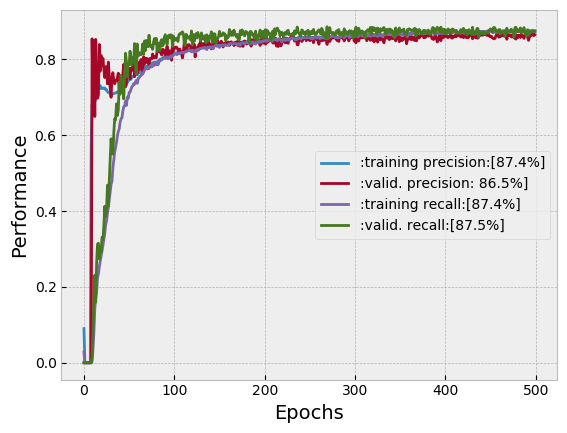

In [68]:
plt.style.use('bmh')
#plt.title('precision-recall performance',fontsize=14)

plt.plot(EvalResults.history['precision_2'],
         label=':training precision:['+str(str(format(EvalResults.history['precision_2'][-1]*100,'.1f'))+'%]'))
plt.plot(EvalResults.history['val_precision_2'],
         label=':valid. precision: '+str(str(format(EvalResults.history['val_precision_2'][-1]*100,'.1f'))+'%]'))

plt.plot(EvalResults.history['recall_2'],
         label=':training recall:['+str(str(format(EvalResults.history['recall_2'][-1]*100,'.1f'))+'%]'))
plt.plot(EvalResults.history['val_recall_2'],
         label=':valid. recall:['+str(str(format(EvalResults.history['val_recall_2'][-1]*100,'.1f'))+'%]'))

plt.ylabel('Performance',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.legend(loc='right');
plt.savefig('results/graph/precision-recall.tiff', dpi=1200)

## prediction on training data

In [42]:
PredictingData = random.randint(0, len(Xtrain))
Trainprediction = model.predict(Xtrain[:int(Xtrain.shape[0]*0.86)], verbose=1)
FaultRecogTrain = (Trainprediction > 0.5).astype(np.uint8)

577/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

 - 37s 63ms/sample


### sanity check on a random training sample

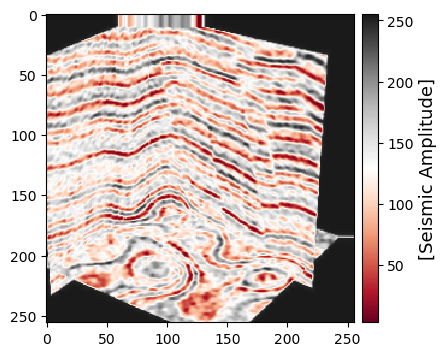

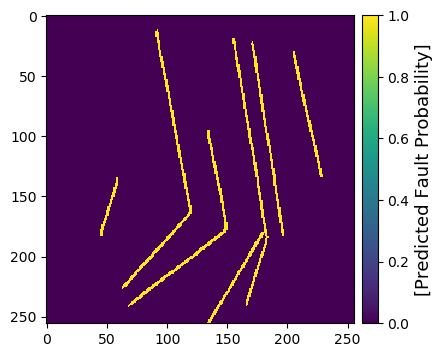

In [70]:
#PredTrainImg = random.randint(0, len(FaultRecogTrain))

def TrainPredictionPlot():
    plt.style.use('default')
    
    fig, (ax1) = plt.subplots(figsize=(5,4), ncols=1)
    im = ax1.imshow(Xtrain[PredTrainImg,...,1] , cmap = 'RdGy')
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="5%", pad=0.08)
    cbar1 = plt.colorbar(im, cax=cax1, orientation='vertical')
    cbar1.set_label('[Seismic Amplitude]', fontsize=13)
    #ax1.axis('off')
    #plt.savefig("results/images/imgtrain1.tif", dpi=600)
    
    fig, (ax3) = plt.subplots(figsize=(5,4), ncols=1)
    SegImg = ax3.imshow(np.squeeze(FaultRecogTrain[PredTrainImg]))
    divider3 = make_axes_locatable(ax3)
    cax3 = divider3.append_axes("right", size="5%", pad=0.08)
    cbar3 = plt.colorbar(SegImg, cax=cax3, orientation='vertical')
    cbar3.set_label('[Predicted Fault Probability]',fontsize=13)
    #ax3.axis('off')
    #plt.savefig("results/images/fprobtrain1.tif", dpi=600)

TrainPredictionPlot()

## make prediction on validation data

In [44]:
ValPrediction = model.predict(Xtrain[int(Xtrain.shape[0]*0.86):], verbose=1)
FaultRecogVal = (ValPrediction > 0.5).astype(np.uint8)
PredValImg = random.randint(0, len(FaultRecogVal))

95/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

### sanity check on a random validation sample

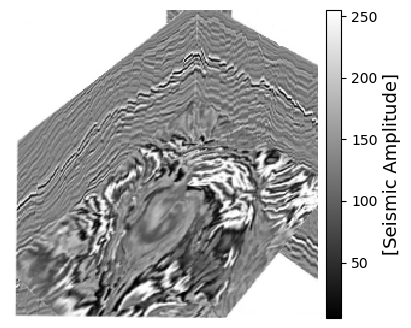

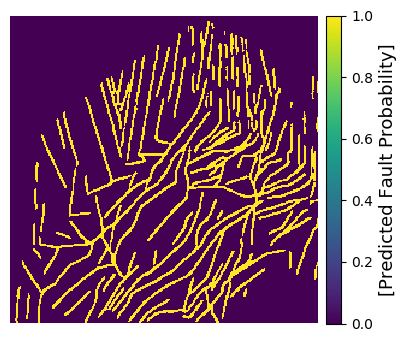

In [48]:
PredValImg = random.randint(0, len(FaultRecogVal))

def ValidPredictionPlot():
    plt.style.use('default')
    
    fig, (ax1) = plt.subplots(figsize=(5,4), ncols=1)
    im1 = ax1.imshow(Xtrain[int(Xtrain.shape[0]*0.86):][PredValImg,...,1],cmap = 'gray')
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="5%", pad=0.08)
    cbar1 = plt.colorbar(im1, cax=cax1, orientation='vertical')
    cbar1.set_label('[Seismic Amplitude]', fontsize=13)
    ax1.axis('off')
    #plt.savefig("results/images/imgval.tiff", dpi=600)
    
    fig, (ax3) = plt.subplots(figsize=(5,4), ncols=1)
    im3 = ax3.imshow(np.squeeze(FaultRecogVal[PredValImg]))
    divider3 = make_axes_locatable(ax3)
    cax3 = divider3.append_axes("right", size="5%", pad=0.08)
    cbar3 = plt.colorbar(im3, cax=cax3, orientation='vertical')
    cbar3.set_label('[Predicted Fault Probability]',fontsize=13)
    ax3.axis('off')
    #plt.savefig("results/images/fprobval.tiff", dpi=600)
    
ValidPredictionPlot()

## make an effective fault recognition

In [51]:
Predicting = random.randint(0, len(Xtrain))
samples = np.array(Xtrain[Predicting])
samples = np.expand_dims(samples, axis=0)
prediction = model.predict(samples, verbose=1)
FaultRecog = (prediction > 0.5).astype(np.uint8)

1/1 [==============================] - 0s 69ms/sample


### display results on a random sample

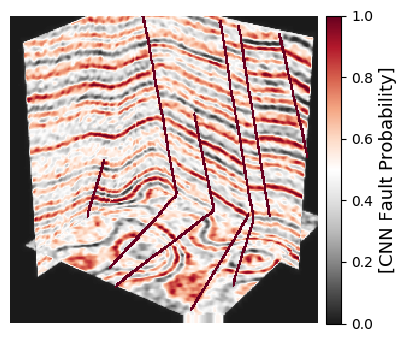

In [73]:
def FaultRecogPlot():
    Prob = ma.masked_where(np.squeeze(FaultRecog[0])<1, np.squeeze(FaultRecog[0]))
    Imag = ma.masked_array(Xtrain[Predicting,...,1], Prob)
    
    fig, (ax) = plt.subplots(figsize=(6,4), ncols=1)
    Seg = ax.imshow(np.squeeze(FaultRecog[0]) , cmap = 'RdGy_r' )
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.08)
    cbar = plt.colorbar(Seg, cax=cax, orientation='vertical')
    cbar.set_label('[CNN Fault Probability]',fontsize=13)
    ax.axis('off');
    FaultRecogImg = ax.imshow(Imag , cmap = 'RdGy')#, alpha=0.3)
    plt.savefig("results/images/fault recog/1.tiff", dpi=1200)

FaultRecogPlot()